In [21]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import os 
import shutil
# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, password=sqluser)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

In [23]:
query = query_schema + """
SELECT DISTINCT DIAGNOSES_ICD.subject_id
FROM icustays
JOIN DIAGNOSES_ICD ON DIAGNOSES_ICD.subject_id = icustays.subject_id
WHERE icd9_code IN {ARDS_list}
"""

ARDS_list = ('51881', '51882', '51884', '51851', '51852', '51853', '769')
ARDS_list = ('51882', 'None')
# df = pd.read_sql_query(query, con)
df = pd.read_sql_query(query.format(ARDS_list=ARDS_list), con)

# df = pd.read_sql_query(query, con)

subject_id = df.sample(1, random_state=0).values[0, 0]

print(f"Subject {subject_id} selected randomly from a cohort of {len(df)} patients.")

Subject 30941 selected randomly from a cohort of 404 patients.


In [25]:
patient_path = "patients/" + str(subject_id) + "/"
info_path = patient_path + "info/"
if os.path.exists(patient_path):
    shutil.rmtree(patient_path)
    
os.mkdir(patient_path)
os.mkdir(info_path)

def save_info(df, info_name):
    path_csv = info_path + info_name + ".csv"
    df.head(100).to_csv(path_csv)

In [26]:
query = query_schema + """
SELECT *
FROM PATIENTS
WHERE subject_id = {subject_id}
"""
df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
save_info(df, "PATIENT")
df.head()

Number of rows : 1


row_id  subject_id gender        dob        dod   dod_hosp    dod_ssn  \
0   29081       30941      F 2022-01-16 2103-01-06 2103-01-06 2103-01-06   

   expire_flag  
0            1

In [27]:
query = query_schema + """
SELECT *
FROM ADMISSIONS
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
save_info(df, "ADMISSIONS")
df.head()

Number of rows : 1


row_id  subject_id  hadm_id           admittime           dischtime  \
0   37664       30941   164022 2102-12-18 18:16:00 2103-01-06 01:30:00   

            deathtime admission_type    admission_location discharge_location  \
0 2103-01-06 01:30:00      EMERGENCY  EMERGENCY ROOM ADMIT       DEAD/EXPIRED   

  insurance language  religion marital_status ethnicity           edregtime  \
0  Medicare     ENGL  CATHOLIC        MARRIED     WHITE 2102-12-18 14:17:00   

            edouttime  diagnosis  hospital_expire_flag  has_chartevents_data  
0 2102-12-18 21:03:00  PNEUMONIA                     1                     1

In [28]:
query = query_schema + """
SELECT *
FROM ICUSTAYS
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
save_info(df, "ICUSTAYS")
df.head()

Number of rows : 1


row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0   39129       30941   164022      276555  carevue           MICU   

  last_careunit  first_wardid  last_wardid              intime  \
0          MICU            52           52 2102-12-18 18:47:37   

              outtime      los  
0 2103-01-06 05:27:19  18.4442

In [29]:
query = query_schema + """
SELECT *
FROM DIAGNOSES_ICD
JOIN D_ICD_DIAGNOSES ON D_ICD_DIAGNOSES.icd9_code = DIAGNOSES_ICD.icd9_code
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
save_info(df, "DIAGNOSES")
df.head(11)

Number of rows : 14


row_id  subject_id  hadm_id  seq_num icd9_code  row_id icd9_code  \
0   355881       30941   164022        1     03843     656     03843   
1   355882       30941   164022        2      4821    5502      4821   
2   355883       30941   164022        3      5849    5908      5849   
3   355884       30941   164022        4      2762    2787      2762   
4   355885       30941   164022        5     51882    5280     51882   
5   355886       30941   164022        6     43311    4510     43311   
6   355887       30941   164022        7     99592   11404     99592   
7   355888       30941   164022        8      3320    3621      3320   
8   355889       30941   164022        9     27651    2155     27651   
9   355890       30941   164022       10      4589    5396      4589   
10  355891       30941   164022       11      9331   12332      9331   

                 short_title  \
0     Pseudomonas septicemia   
1      Pseudomonal pneumonia   
2   Acute kidney failure NOS   
3                   Acidosis   
4     Other pulmonary insuff   
5      Ocl crtd art w infrct   
6              Severe sepsis   
7          Paralysis agitans   
8                Dehydration   
9            Hypotension NOS   
10    Foreign body in larynx   

                                           long_title  
0                       Septicemia due to pseudomonas  
1                        Pneumonia due to Pseudomonas  
2                   Acute kidney failure, unspecified  
3                                            Acidosis  
4   Other pulmonary insufficiency, not elsewhere c...  
5   Occlusion and stenosis of carotid artery with ...  
6                                       Severe sepsis  
7                                   Paralysis agitans  
8                                         Dehydration  
9                            Hypotension, unspecified  
10                             Foreign body in larynx

In [30]:
query = query_schema + """
SELECT *
FROM PROCEDURES_ICD
JOIN D_ICD_PROCEDURES ON D_ICD_PROCEDURES.icd9_code = PROCEDURES_ICD.icd9_code
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
save_info(df, "PROCEDURES")
df.head(7)

Number of rows : 9


row_id  subject_id  hadm_id  seq_num icd9_code  row_id icd9_code  \
0  155815       30941   164022        1       311     552       311   
1  155816       30941   164022        2      4311    1528      4311   
2  155817       30941   164022        3      3893     801      3893   
3  155818       30941   164022        4      9604    3607      9604   
4  155819       30941   164022        5      9672    3679      9672   
5  155820       30941   164022        6       966    3676       966   
6  155821       30941   164022        7      9605    3608      9605   

                short_title                                         long_title  
0    Temporary tracheostomy                             Temporary tracheostomy  
1  Percu endosc gastrostomy        Percutaneous [endoscopic] gastrostomy [PEG]  
2           Venous cath NEC   Venous catheterization, not elsewhere classified  
3  Insert endotracheal tube                     Insertion of endotracheal tube  
4  Cont inv mec ven 96+ hrs  Continuous invasive mechanical ventilation for...  
5   Entral infus nutrit sub  Enteral infusion of concentrated nutritional s...  
6    Resp tract intubat NEC              Other intubation of respiratory tract

In [31]:
query = query_schema + """
SELECT *
FROM NOTEEVENTS
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
df.head(10)

Number of rows : 105


row_id  subject_id  hadm_id  chartdate           charttime storetime  \
0  989277       30941   164022 2102-12-18 2102-12-18 14:58:00       NaT   
1  989284       30941   164022 2102-12-18 2102-12-18 15:29:00       NaT   
2  990165       30941   164022 2102-12-24 2102-12-24 05:03:00       NaT   
3  989329       30941   164022 2102-12-19 2102-12-19 05:50:00       NaT   
4  989387       30941   164022 2102-12-19 2102-12-19 11:09:00       NaT   
5  989459       30941   164022 2102-12-19 2102-12-19 18:12:00       NaT   
6  989490       30941   164022 2102-12-19 2102-12-19 23:35:00       NaT   
7  989690       30941   164022 2102-12-21 2102-12-21 04:55:00       NaT   
8  989865       30941   164022 2102-12-22 2102-12-22 05:36:00       NaT   
9  990032       30941   164022 2102-12-23 2102-12-23 05:20:00       NaT   

    category                 description  cgid iserror  \
0  Radiology         CHEST (PORTABLE AP)   NaN    None   
1  Radiology        CT HEAD W/O CONTRAST   NaN    None   
2  Radiology         CHEST (PORTABLE AP)   NaN    None   
3  Radiology         CHEST (PORTABLE AP)   NaN    None   
4  Radiology         CHEST (PORTABLE AP)   NaN    None   
5  Radiology  CHEST PORT. LINE PLACEMENT   NaN    None   
6  Radiology         CHEST (PORTABLE AP)   NaN    None   
7  Radiology         CHEST (PORTABLE AP)   NaN    None   
8  Radiology         CHEST (PORTABLE AP)   NaN    None   
9  Radiology         CHEST (PORTABLE AP)   NaN    None   

                                                text  
0  [**2102-12-18**] 2:58 PM\n CHEST (PORTABLE AP)...  
1  [**2102-12-18**] 3:29 PM\n CT HEAD W/O CONTRAS...  
2  [**2102-12-24**] 5:03 AM\n CHEST (PORTABLE AP)...  
3  [**2102-12-19**] 5:50 AM\n CHEST (PORTABLE AP)...  
4  [**2102-12-19**] 11:09 AM\n CHEST (PORTABLE AP...  
5  [**2102-12-19**] 6:12 PM\n CHEST PORT. LINE PL...  
6  [**2102-12-19**] 11:35 PM\n CHEST (PORTABLE AP...  
7  [**2102-12-21**] 4:55 AM\n CHEST (PORTABLE AP)...  
8  [**2102-12-22**] 5:36 AM\n CHEST (PORTABLE AP)...  
9  [**2102-12-23**] 5:20 AM\n CHEST (PORTABLE AP)...

In [32]:
note_path = patient_path + "doctor_notes" + "/"
if not os.path.exists(note_path):
    os.mkdir(note_path)
else:
    shutil.rmtree(note_path)
    os.mkdir(note_path)
    
notes = df["text"]
notes_all = ""
for i, note in enumerate(notes):
    with open(note_path+f"note_{i}.txt", 'w') as f:
        f.write(note)
    print(note)
    notes_all += note
with open(note_path+f"all_notes.txt", 'w') as f:
        f.write(notes_all)

[**2102-12-18**] 2:58 PM
 CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 95185**]
 Reason: please eval for PNA
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  80 yo F p/w ALOC and cough recently, afebrile, diminished bibasilar lung sounds
 REASON FOR THIS EXAMINATION:
  please eval for PNA
 ______________________________________________________________________________
                                 FINAL REPORT
 AP CHEST

 INDICATION:  80-year-old female with acute loss of consciousness and cough.
 Diminished bibasilar lung sounds.

 COMPARISON:  Not available.

 FINDINGS:  Evaluation is limited by suboptimal technique, patient is markedly
 rotated to the right. Cardiac silhouette is enlarged.  Lung volumes are low,
 with a greater degree of volume loss on the left. Left lower lobe opacity
 likely represents combination of consolidation and collapse; pleural effus

In [33]:
query = query_schema + """
SELECT *
FROM PROCEDUREEVENTS_MV
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
df.head()

Number of rows : 0


Empty DataFrame
Columns: [row_id, subject_id, hadm_id, icustay_id, starttime, endtime, itemid, value, valueuom, location, locationcategory, storetime, cgid, orderid, linkorderid, ordercategoryname, secondaryordercategoryname, ordercategorydescription, isopenbag, continueinnextdept, cancelreason, statusdescription, comments_editedby, comments_canceledby, comments_date]
Index: []

[0 rows x 25 columns]

In [34]:
query = query_schema + """
SELECT *
FROM CHARTEVENTS
JOIN D_ITEMS ON CHARTEVENTS.itemid = D_ITEMS.itemid
WHERE subject_id = {subject_id}
"""

df_CHARTEVENTS = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df_CHARTEVENTS))
df_CHARTEVENTS.head()

Number of rows : 25015


row_id  subject_id  hadm_id  icustay_id itemid           charttime  \
0  186096739       30941   164022      276555   1089 2102-12-19 08:00:00   
1  186110535       30941   164022      276555   1089 2103-01-03 04:00:00   
2  186110611       30941   164022      276555   1089 2103-01-03 06:30:00   
3  186110893       30941   164022      276555   1089 2103-01-03 14:00:00   
4  186096659       30941   164022      276555     50 2102-12-19 08:00:00   

            storetime   cgid          value  valuenum  ... row_id itemid  \
0 2102-12-19 09:24:00  20814            Yes       NaN  ...   1236   1089   
1 2103-01-03 06:51:00  14605            Yes       NaN  ...   1236   1089   
2 2103-01-03 06:51:00  14605            Yes       NaN  ...   1236   1089   
3 2103-01-03 14:25:00  20814  Other/Remarks       NaN  ...   1236   1089   
4 2102-12-19 10:48:00  21319             20      20.0  ...     56     50   

                  label abbreviation dbsource      linksto  category unitname  \
0  PainLevel Acceptable         None  carevue  chartevents      None     None   
1  PainLevel Acceptable         None  carevue  chartevents      None     None   
2  PainLevel Acceptable         None  carevue  chartevents      None     None   
3  PainLevel Acceptable         None  carevue  chartevents      None     None   
4   Apnea Time Interval         None  carevue  chartevents      None     None   

  param_type conceptid  
0       None      None  
1       None      None  
2       None      None  
3       None      None  
4       None      None  

[5 rows x 25 columns]

In [35]:
query = query_schema + """
SELECT DISTINCT label
FROM CHARTEVENTS
JOIN D_ITEMS ON CHARTEVENTS.itemid = D_ITEMS.itemid
WHERE subject_id = {subject_id}
"""
df_CHARTEVENTS = pd.read_sql_query(query.format(subject_id=subject_id), con)
save_info(df_CHARTEVENTS, "LABELS_CHARTEVENTS")

query = query_schema + """
SELECT charttime, label, value, valueuom
FROM CHARTEVENTS
JOIN D_ITEMS ON CHARTEVENTS.itemid = D_ITEMS.itemid
WHERE subject_id = {subject_id}
"""

df_CHARTEVENTS = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df_CHARTEVENTS))
df_CHARTEVENTS.sample(frac=1, random_state=0).head(50)

Number of rows : 25015


charttime                   label               value valueuom
6151  2102-12-26 12:00:00                    Turn        Side to Side     None
17527 2103-01-03 04:00:00              Pain Level     Unable to score     None
8272  2102-12-25 08:00:00       INV Line#1 [Type]         Multi-lumen     None
12177 2102-12-29 22:00:00            Heart Rhythm        Normal Sinus     None
9187  2102-12-29 10:00:00     ETT Position Change                Done     None
18618 2102-12-25 21:00:00        Arterial BP Mean                  63     mmHg
16352 2102-12-22 17:00:00            Service Type               MSICU     None
18795 2102-12-25 18:00:00          Risk for Falls                 Yes     None
5435  2102-12-24 09:00:00              Heart Rate                  98      BPM
6010  2102-12-28 12:00:00                     HOB          30 degrees     None
15911 2102-12-20 15:00:00        Ectopy Frequency                None     None
3239  2102-12-25 10:00:00               Diet Type        Tube Feeding     None
18654 2102-12-20 00:00:00          Risk for Falls                 Yes     None
20048 2102-12-28 08:00:00             Tank A psi.                1500     None
6940  2102-12-22 19:00:00        ABP Alarm [High]                 160     mmHg
556   2102-12-28 18:00:00  Anti-Embolism [Status]                  On     None
8828  2103-01-02 05:00:00              calprevflg                   1       kg
20536 2102-12-31 04:00:00     Low Exhaled Min Vol                   5     None
10529 2103-01-02 08:00:00      Level of Conscious        Unresponsive     None
1361  2103-01-01 21:15:00         CVP Alarm [Low]                   4     mmHg
17973 2102-12-24 08:00:00          Sputum [Color]               White     None
4914  2102-12-25 16:00:00          ETT [Location]                 Lip     None
24104 2103-01-02 13:25:00        Resp Alarm [Low]                   8      BPM
12613 2102-12-24 06:00:00              Creatinine                  .8     None
1341  2103-01-01 03:00:00         CVP Alarm [Low]                   4     mmHg
3268  2102-12-29 16:00:00               Diet Type        Tube Feeding     None
6473  2102-12-29 05:00:00     Peak Insp. Pressure                  33    cmH2O
10965 2103-01-04 03:00:00       Health Care Proxy                 Yes     None
11080 2102-12-20 04:00:00         Braden Moisture        Rarely Moist     None
4936  2102-12-26 04:00:00       INV Line#2 [Site]        Right Radial     None
16354 2102-12-22 18:00:00            Service Type               MSICU     None
7840  2102-12-26 00:00:00     INV Line#1 Zero/Cal                  No     None
6733  2103-01-03 12:00:00             Orientation    Unable to Assess     None
21085 2102-12-20 14:00:00                FiO2 Set                   1     torr
3161  2102-12-31 08:00:00             Oral Cavity    Teeth/Tissue WNL     None
888   2102-12-27 05:00:00        CVP Alarm [High]                  12     mmHg
1533  2102-12-20 04:00:00       IV Site Appear #2                 WNL     None
13660 2102-12-24 06:00:00             Code Status           Full Code     None
12938 2103-01-01 04:00:00       GI Tube #1 [Site]          Salem Sump     None
17373 2103-01-02 04:00:00            Bowel Sounds             Present     None
8516  2102-12-20 14:30:00              calprevflg                   1       kg
6443  2102-12-27 16:00:00               Pain Type                None     None
21363 2103-01-04 06:00:00        Previous WeightF  48.299999237060547       kg
2655  2102-12-21 04:00:00         LLL Lung Sounds          Diminished     None
14089 2103-01-04 04:00:00               Back Care                Done     None
8493  2102-12-19 18:30:00              calprevflg                   1       kg
10284 2102-12-31 07:00:00        Respiratory Rate                  35      BPM
4890  2102-12-25 00:00:00  Dorsal PedPulse [Left]     Easily Palpable     None
15300 2102-12-24 12:00:00      Tidal Volume (Set)                 380     ml/B
6664  2102-12-23 04:00:00             Orientation    Unable to Ass

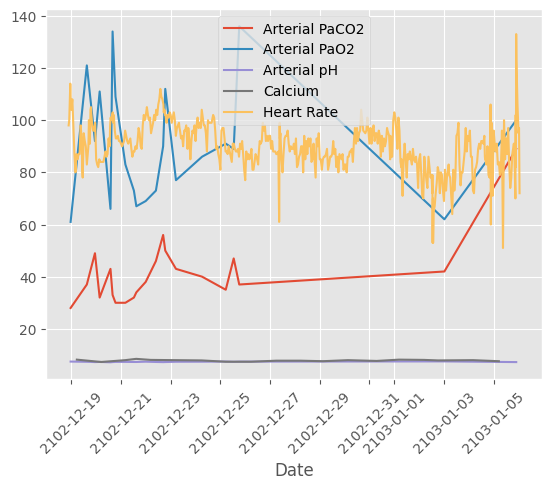

In [36]:
plot_path = patient_path + "plots" + "/"
if not os.path.exists(plot_path):
    os.mkdir(plot_path)
else:
    shutil.rmtree(plot_path)
    os.mkdir(plot_path)

num_list = ["temp axiliary", "SaO2", "Resp Rate", "Present Weight (kg)",
            "Heart Rate", "Glucometer", "BP Cuff [Systolic]", "Arterial PaCO2", "Arterial PaO2", "Arterial pH", "Calcium"]

for label in np.unique(num_list):
    # try:
    df_work_of_breathing = df_CHARTEVENTS[df_CHARTEVENTS["label"]==label]
    if len(df_work_of_breathing) != 0:
    # if None not in list(df_work_of_breathing["value"]) and len(list(df_work_of_breathing["value"]))>1:
    #     try:
    # print(label)
    # print(list(df_work_of_breathing["value"]))
        list_plot = list(map(float, list(df_work_of_breathing["value"])))
        plt.plot(df_work_of_breathing["charttime"], list_plot, '-', label=label)
        plt.xlabel("Date")
        plt.xticks(rotation=45)
            # except Exception as e:
            # 	print("ERROR 1: "+str(e))
            #     # list_plot = df_work_of_breathing["value"]
            
    # except Exception as e:
    # 	print("ERROR : "+str(e))
        # pass

plt.legend()
plt.savefig(plot_path+f'a_total.png')
plt.show()

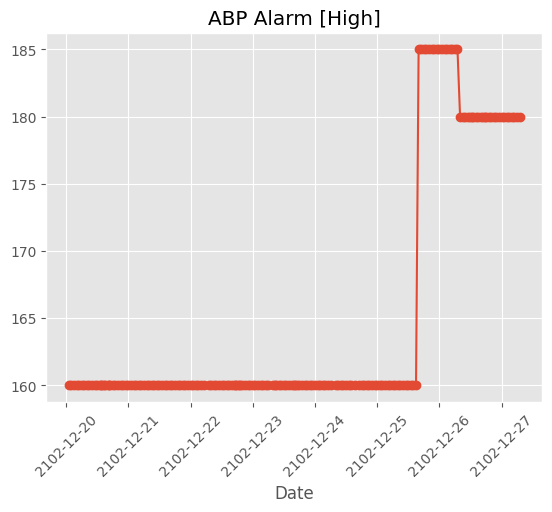

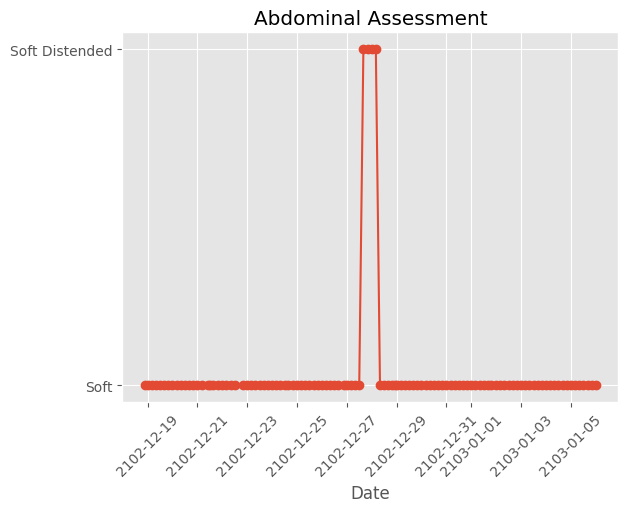

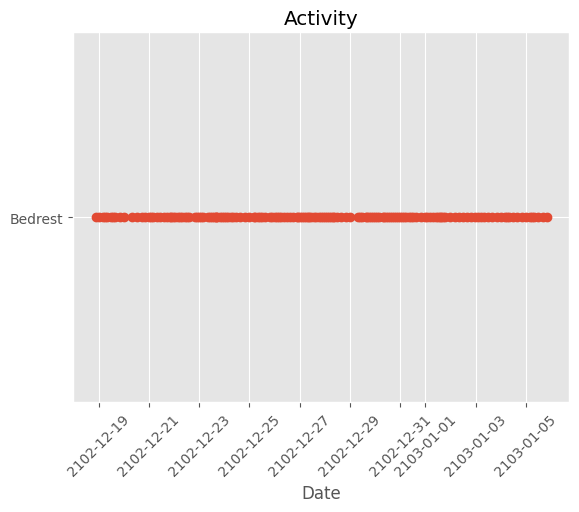

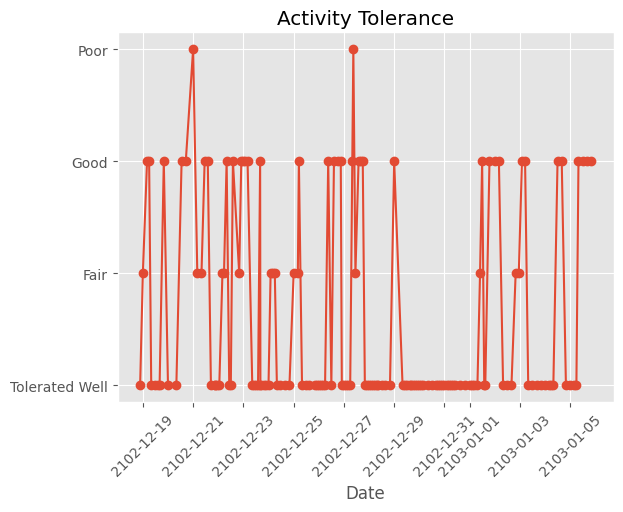

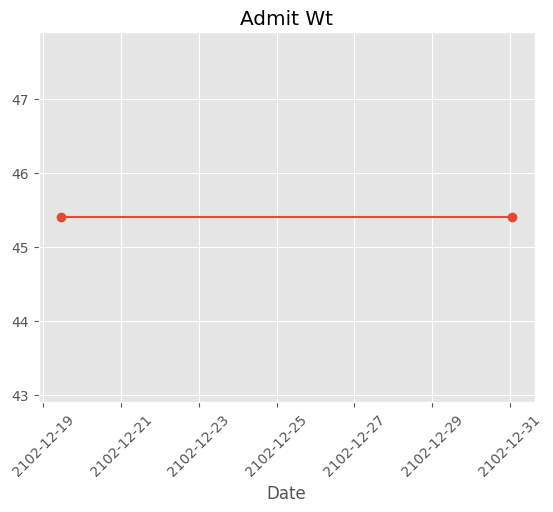

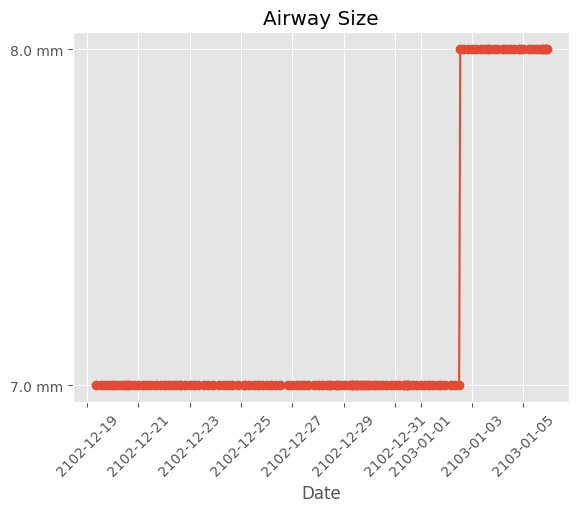

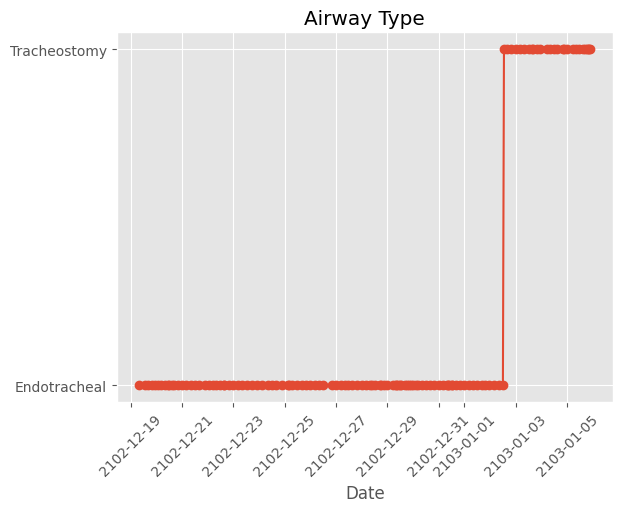

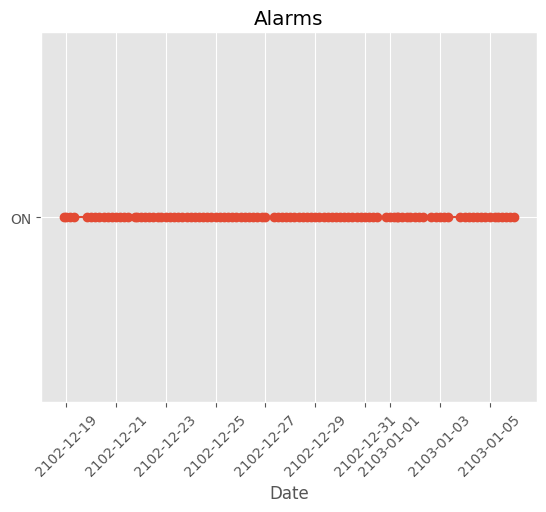

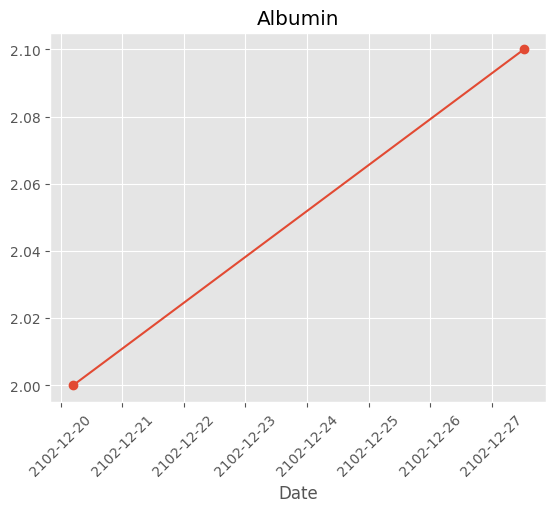

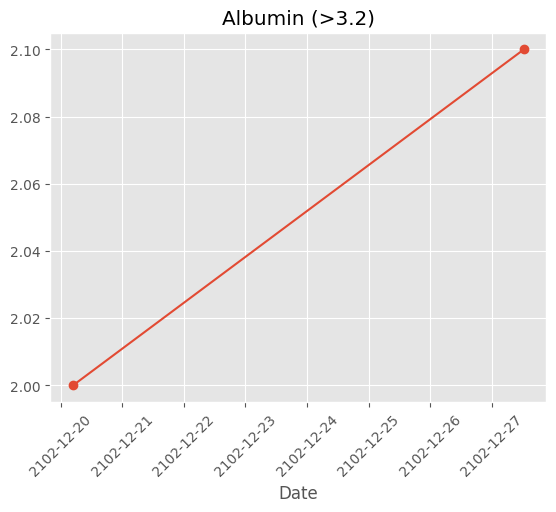

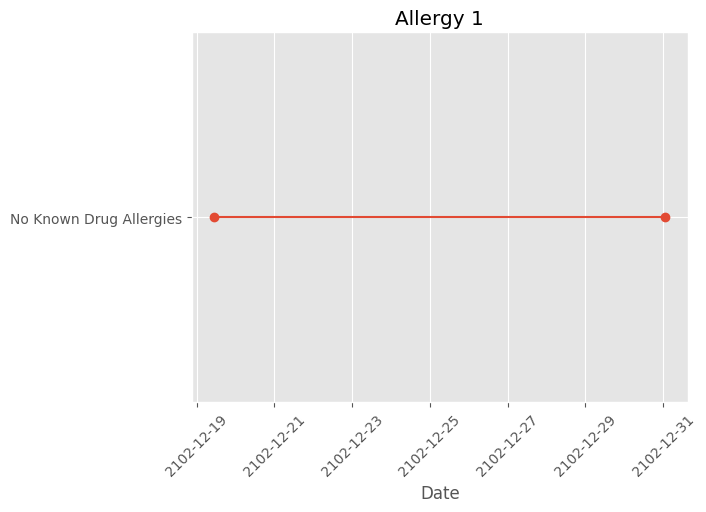

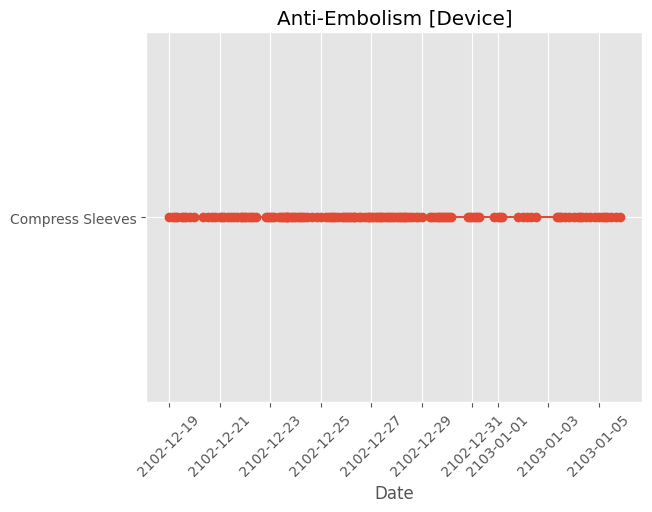

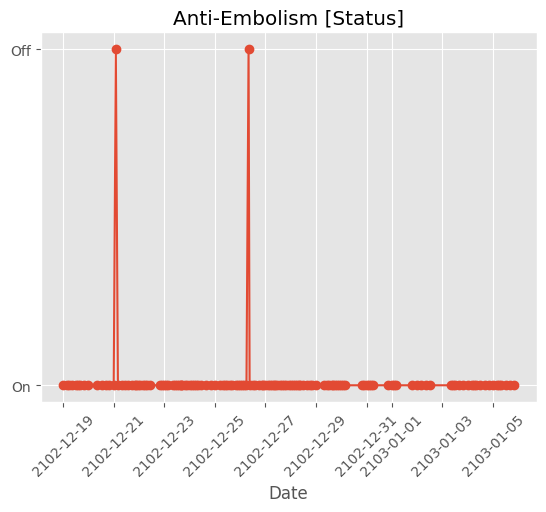

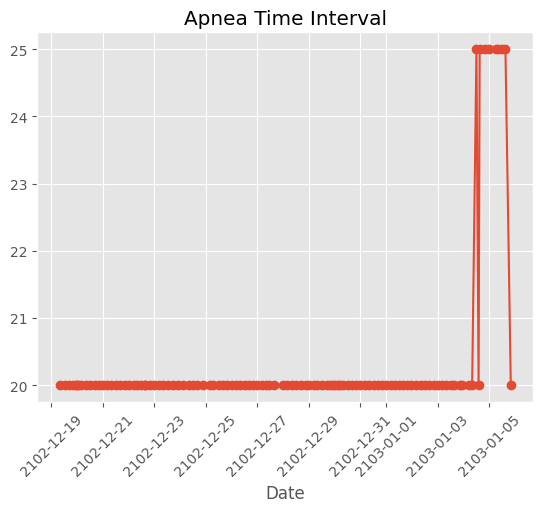

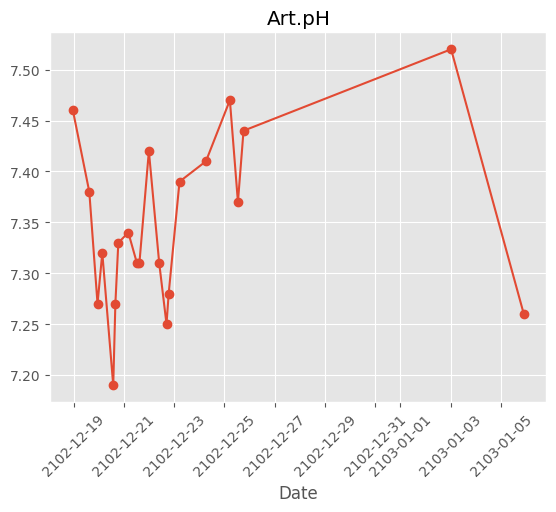

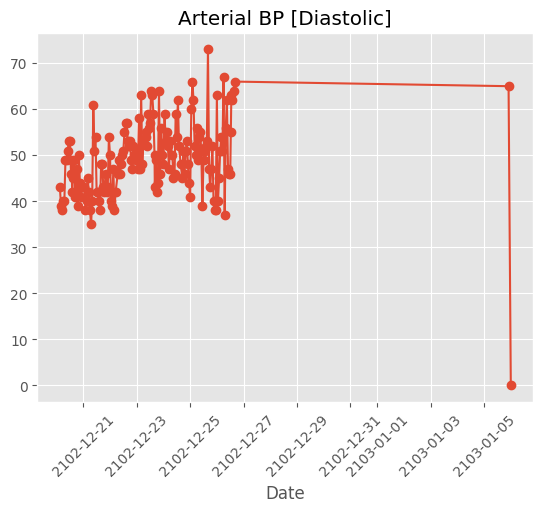

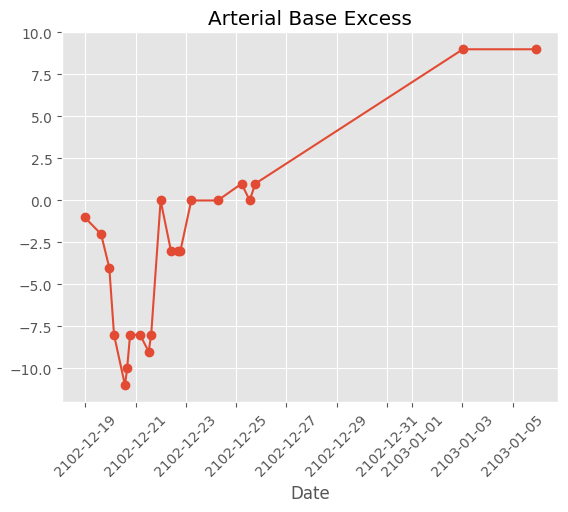

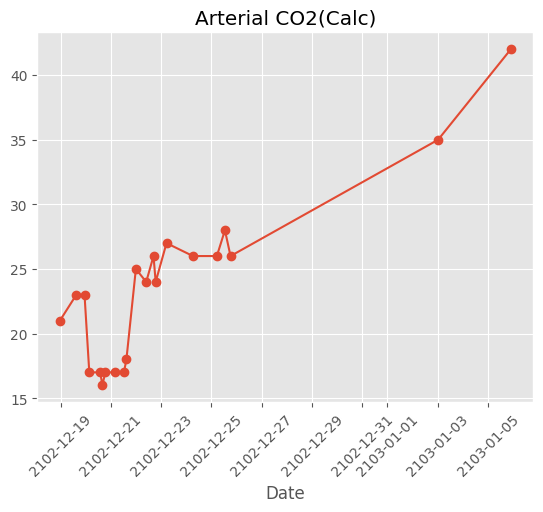

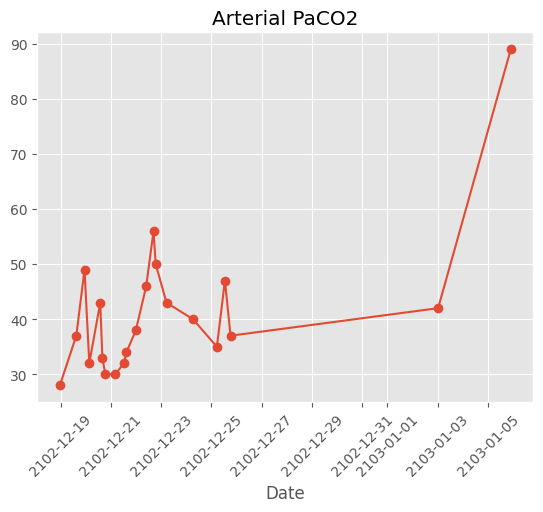

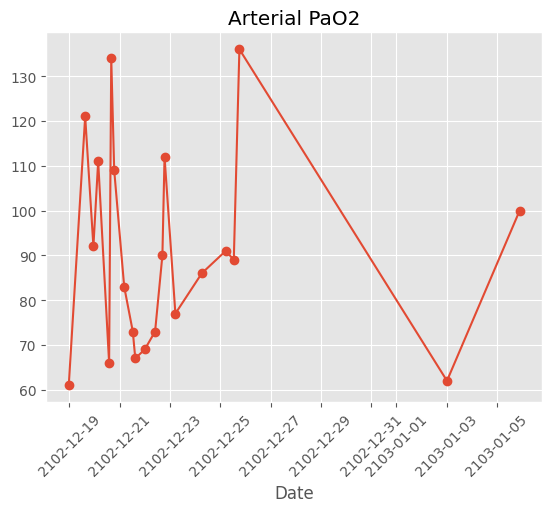

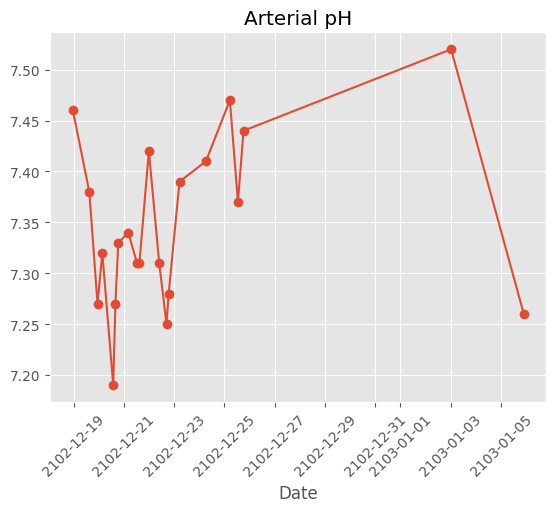

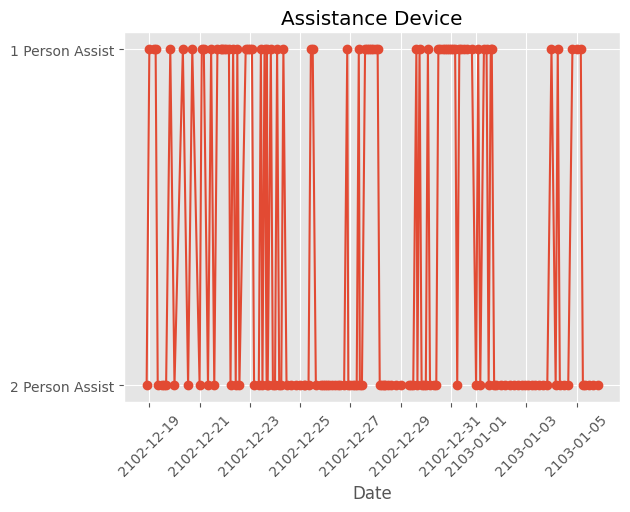

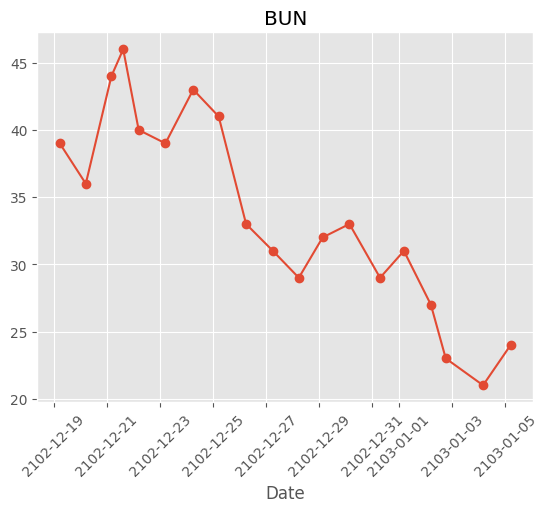

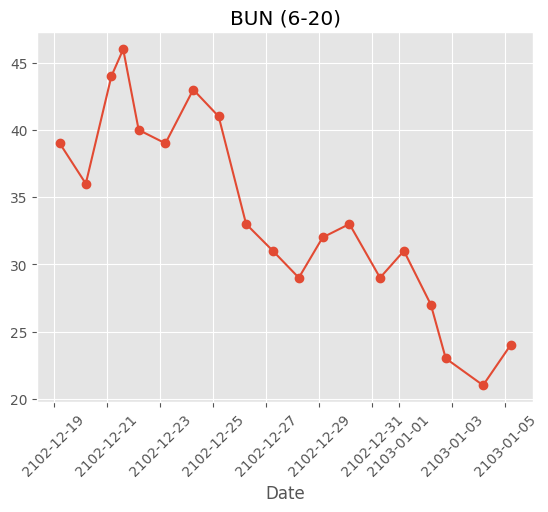

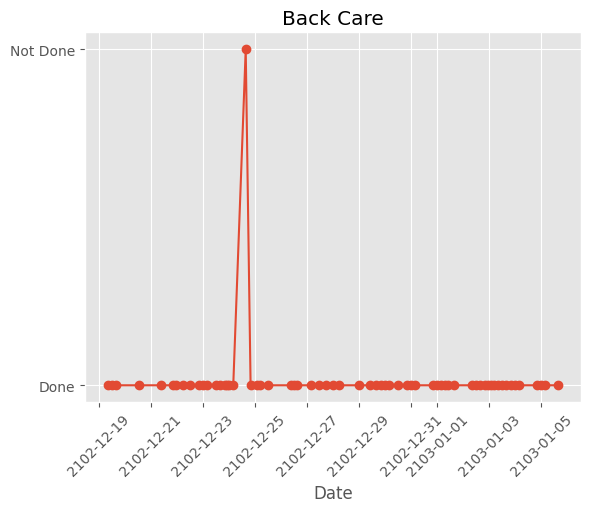

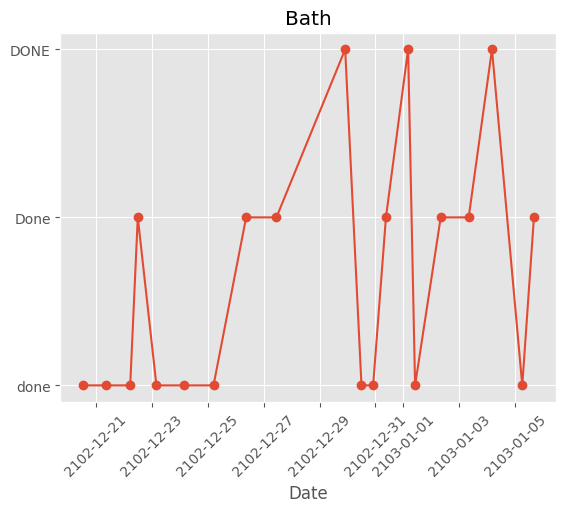

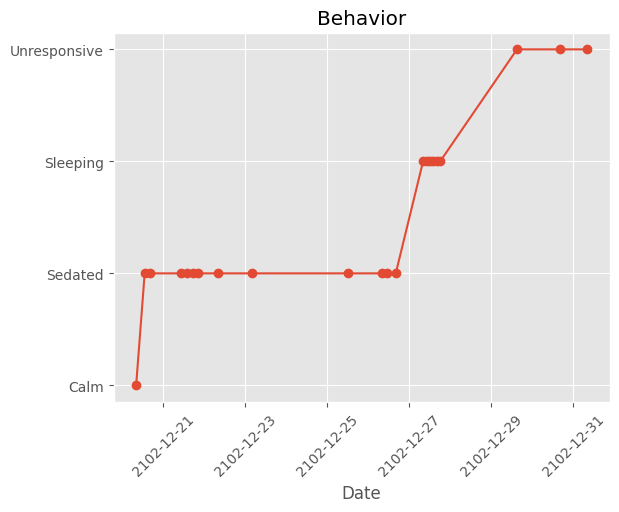

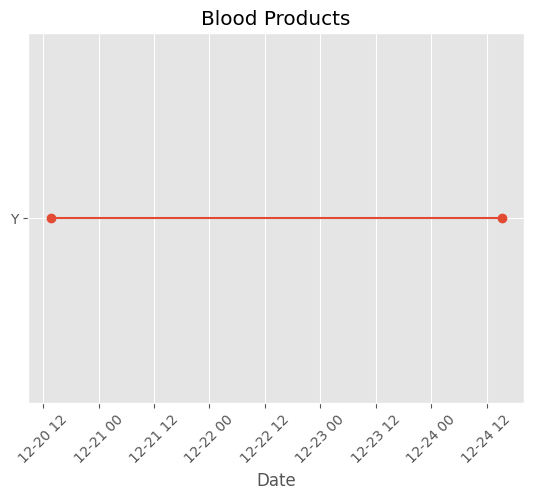

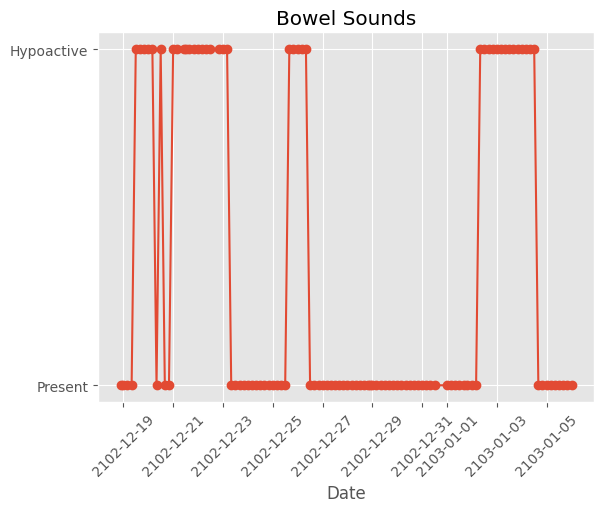

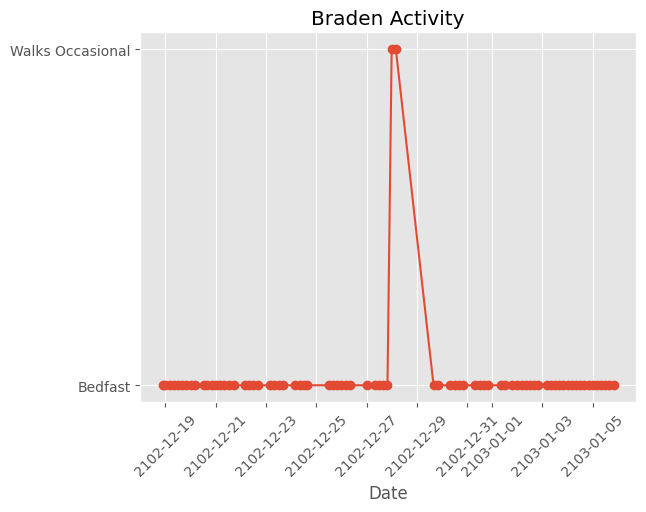

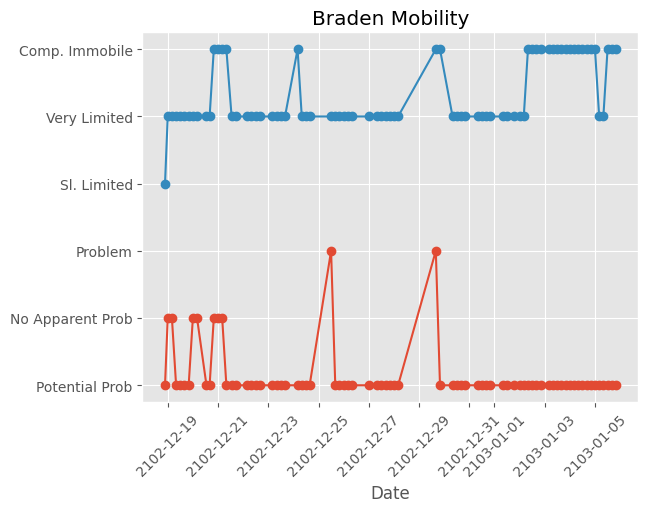

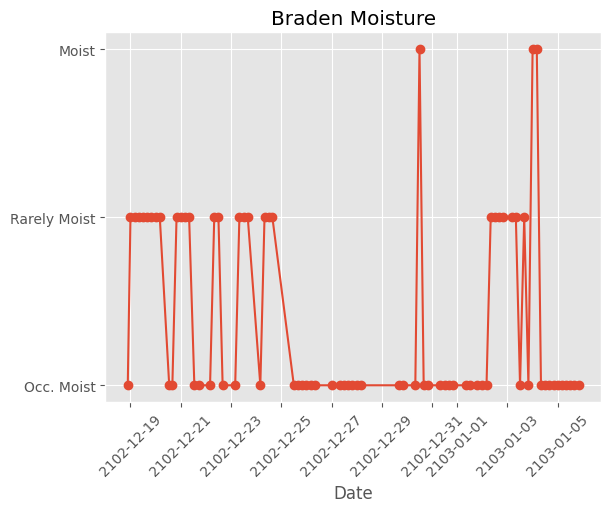

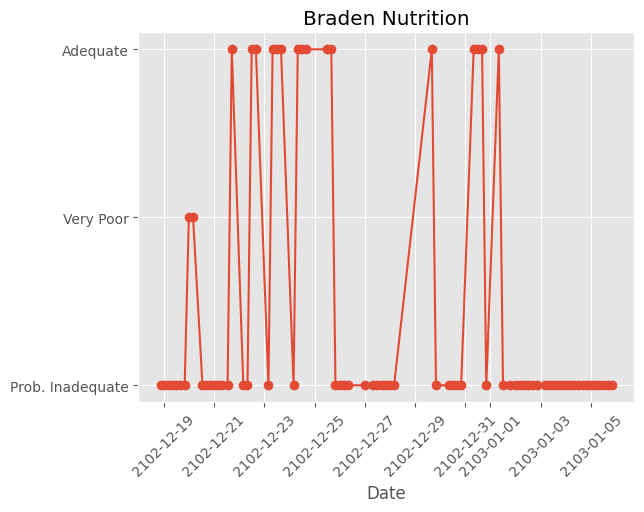

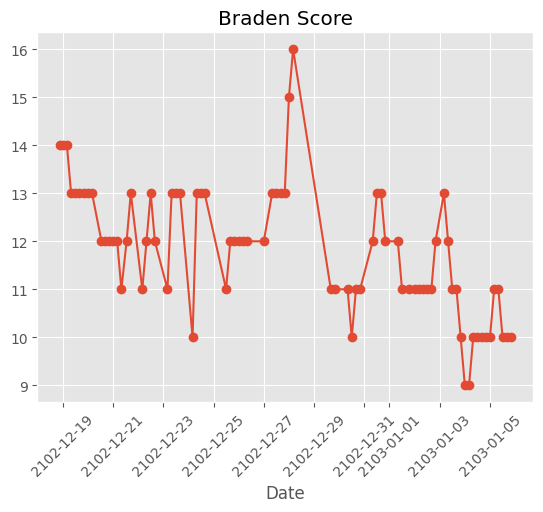

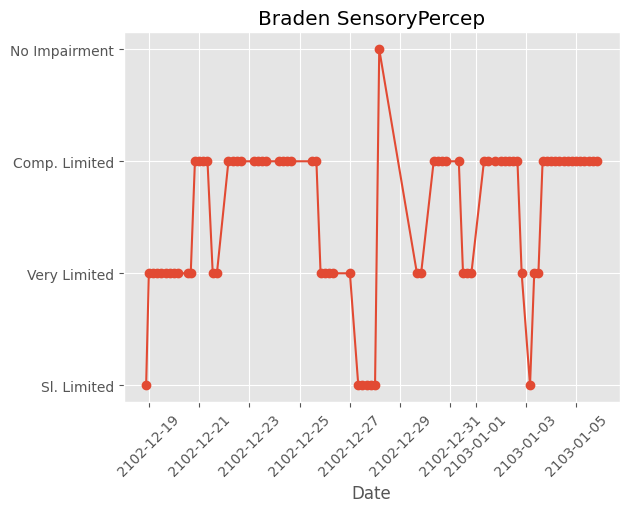

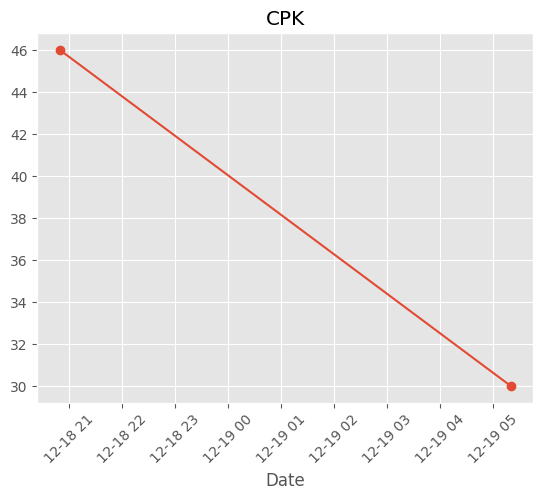

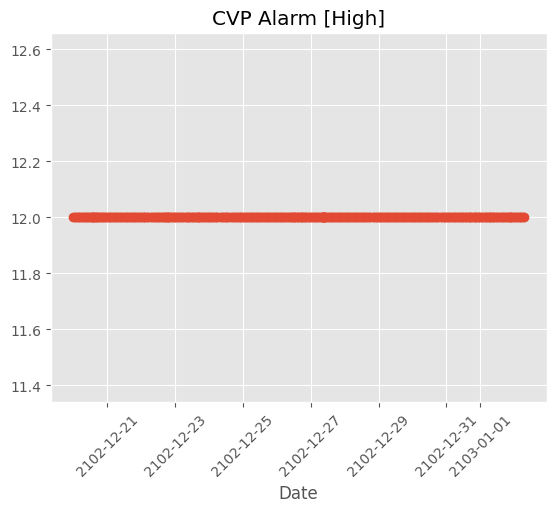

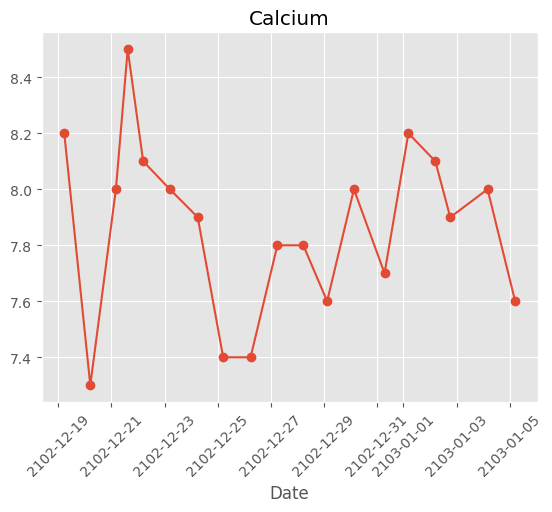

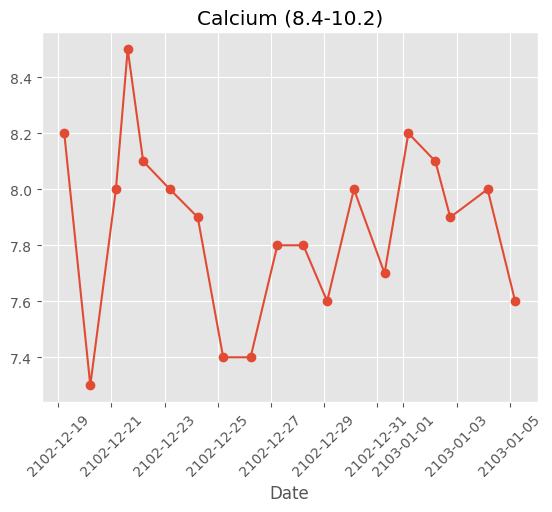

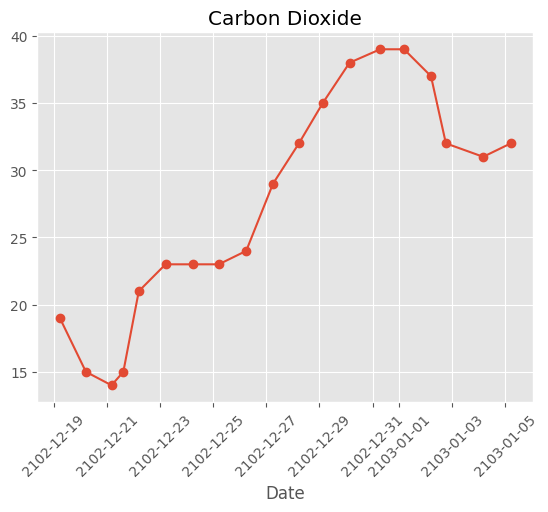

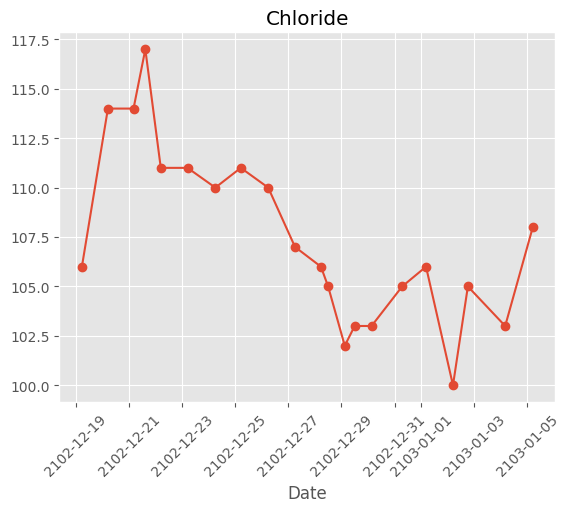

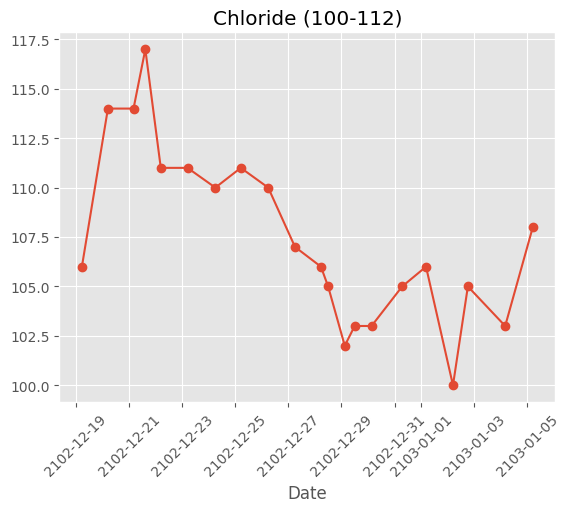

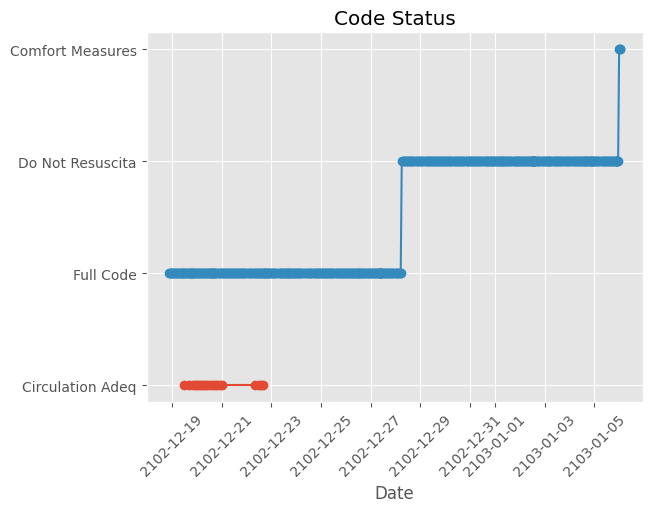

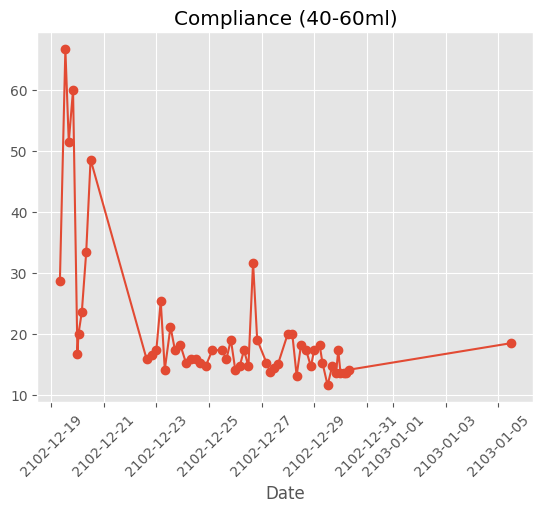

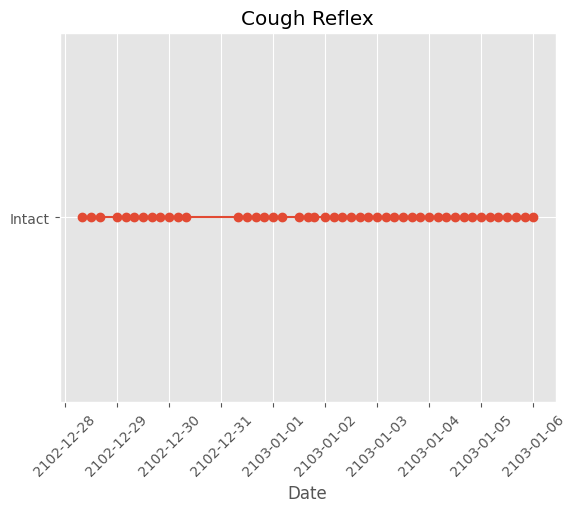

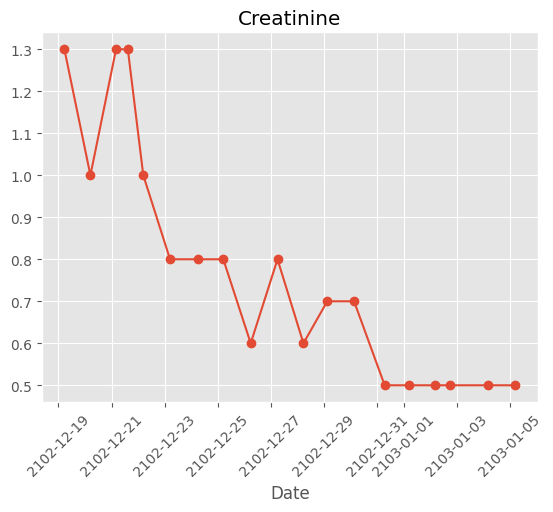

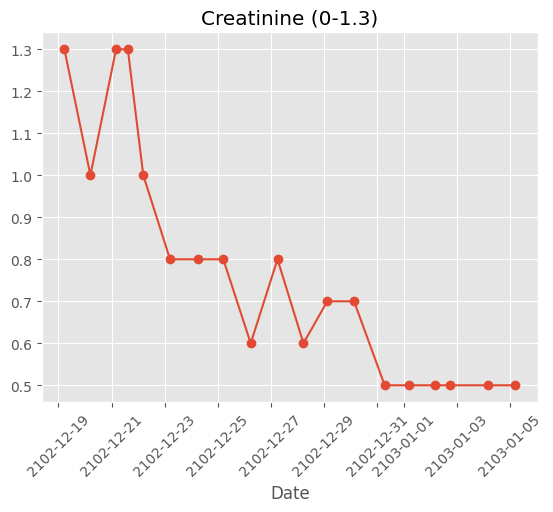

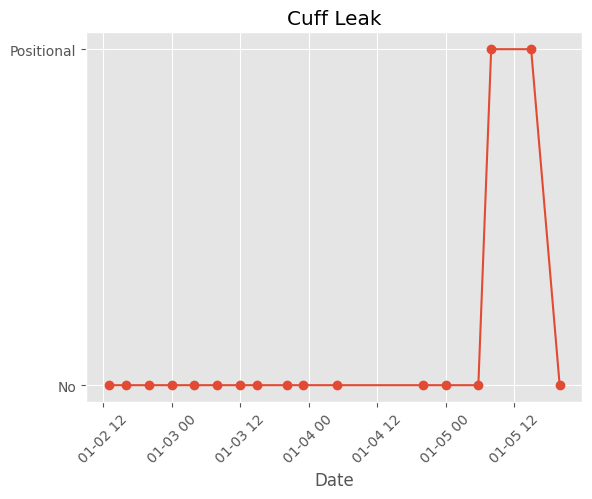

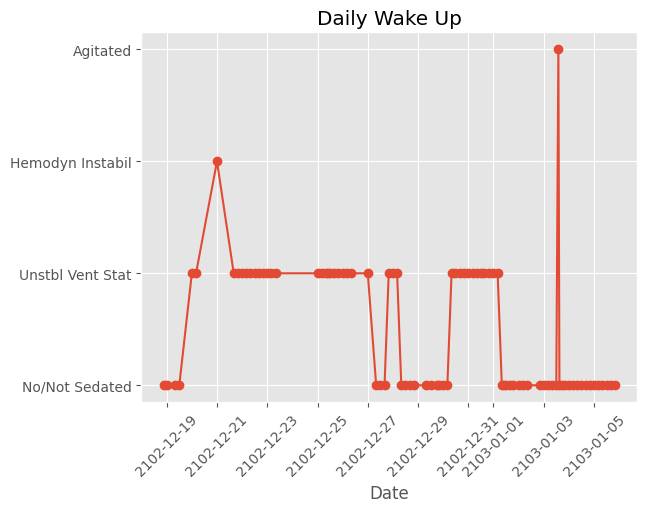

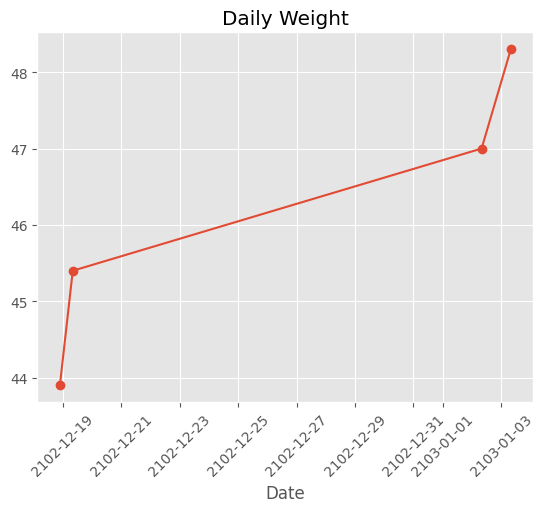

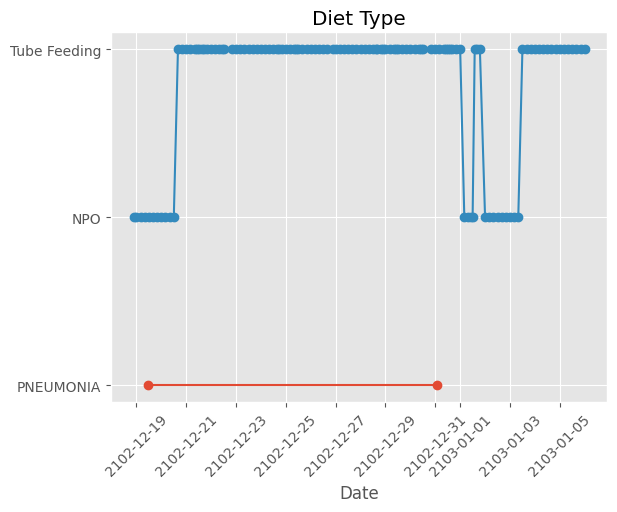

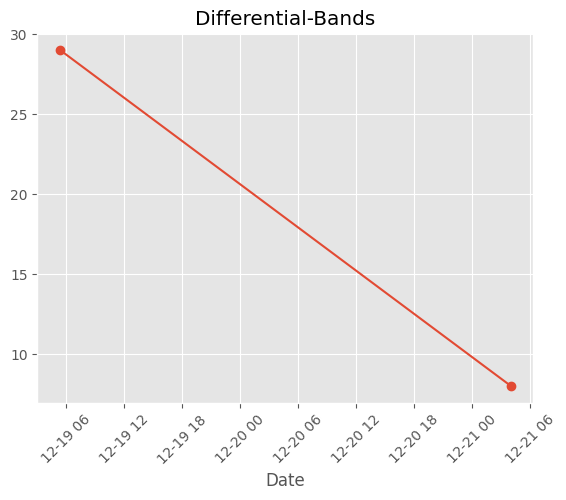

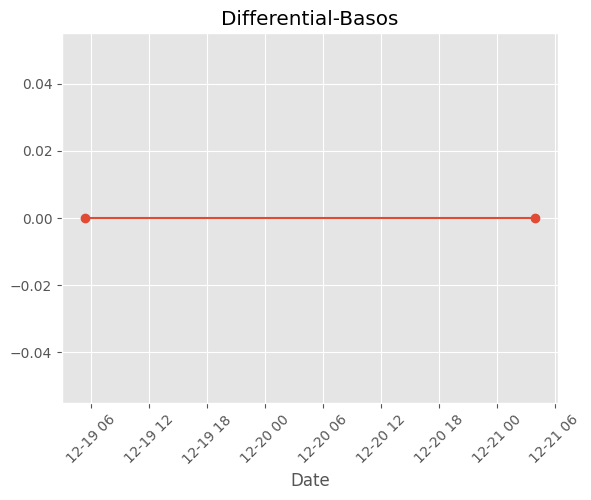

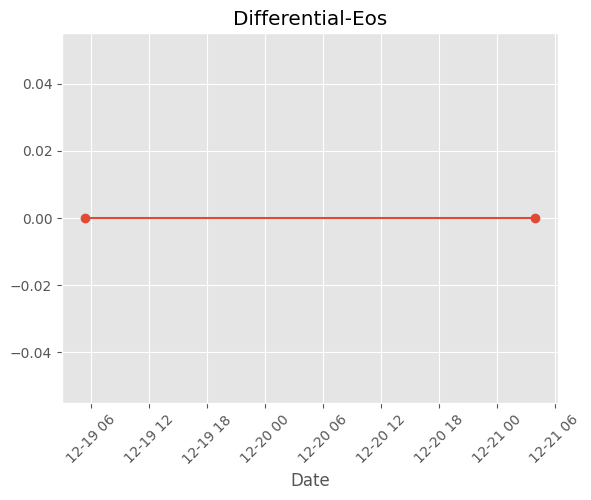

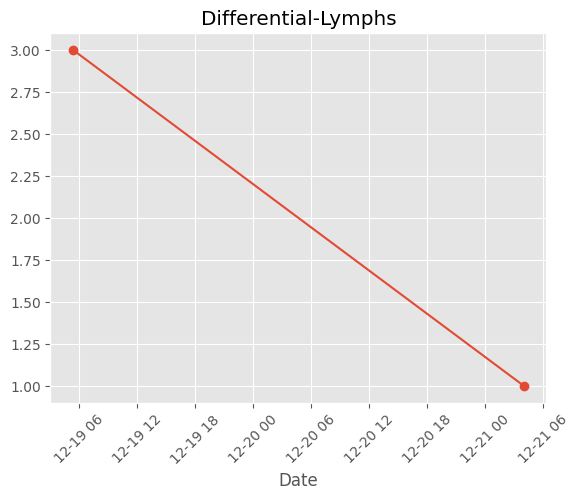

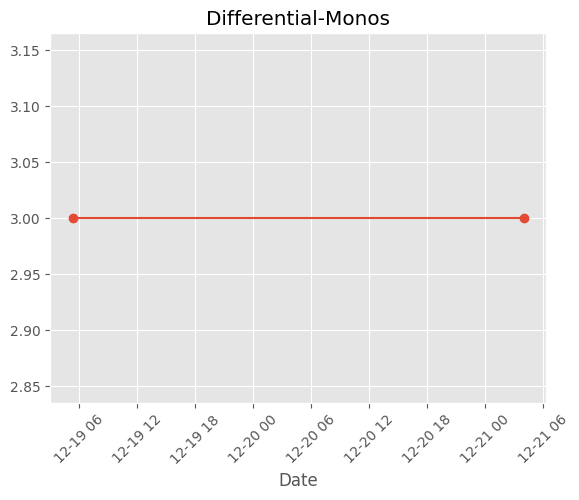

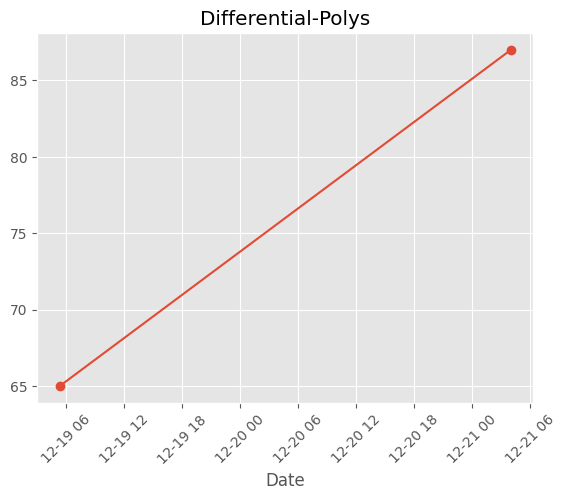

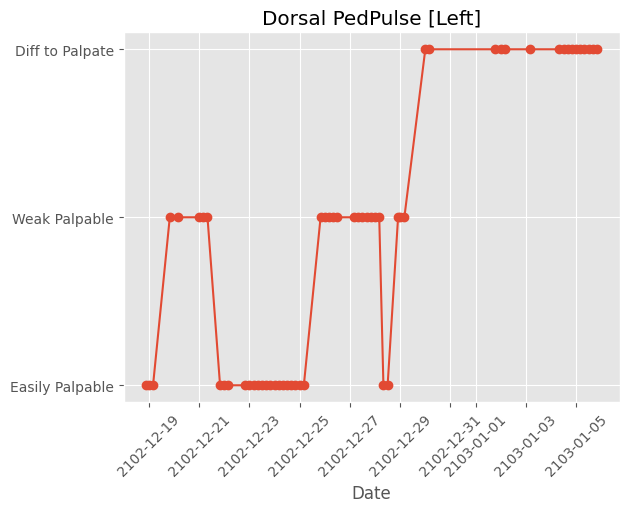

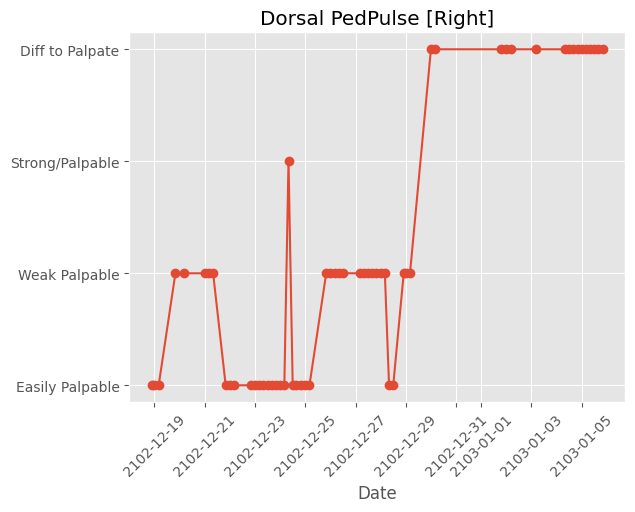

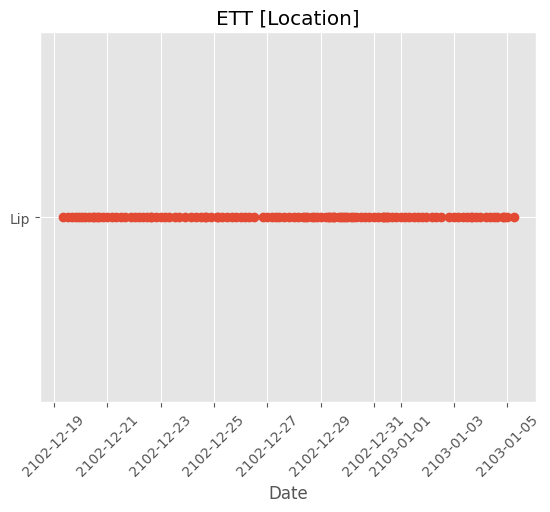

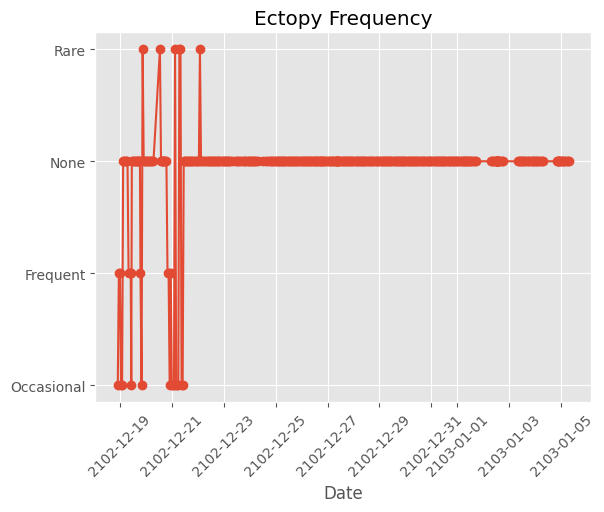

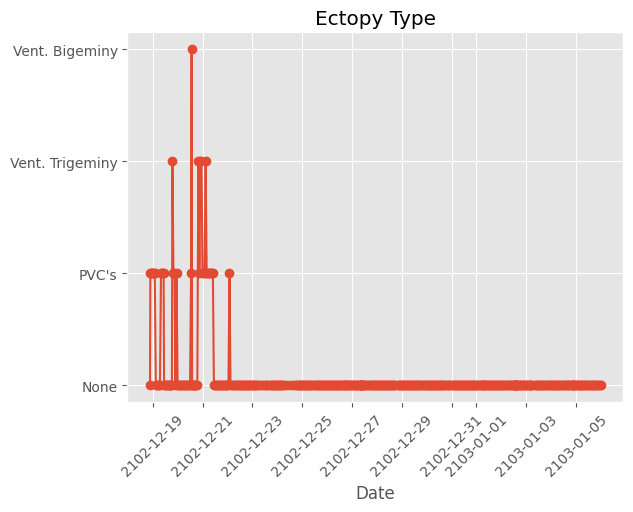

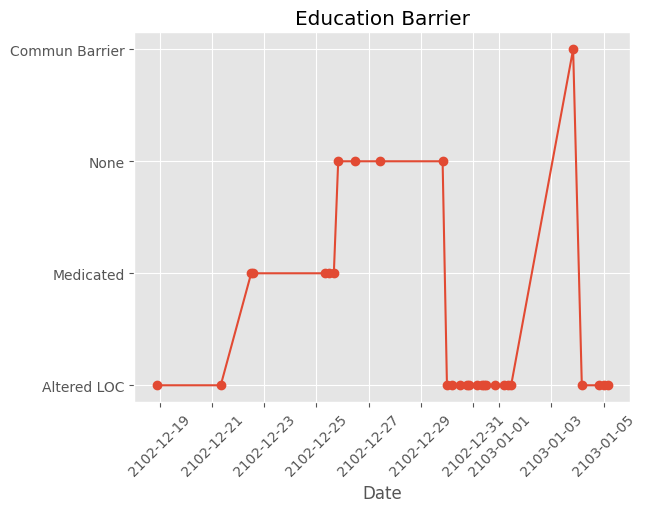

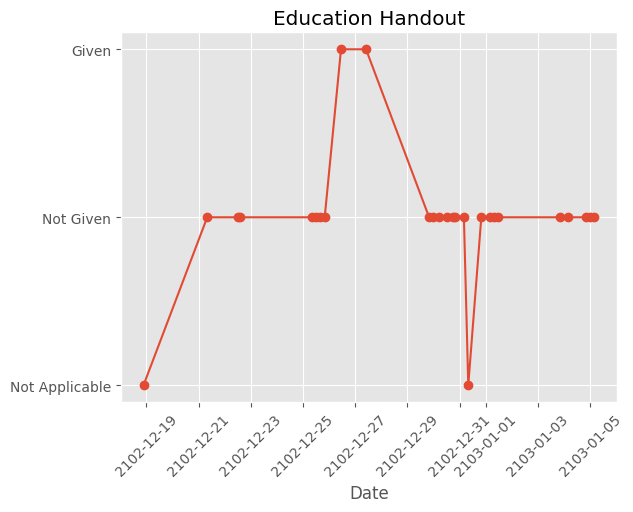

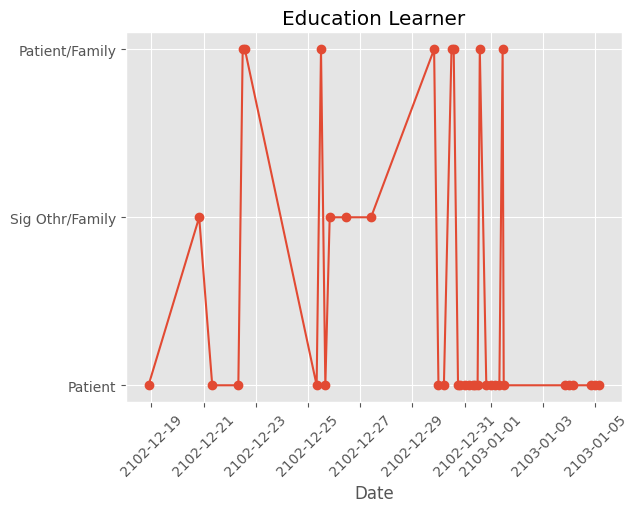

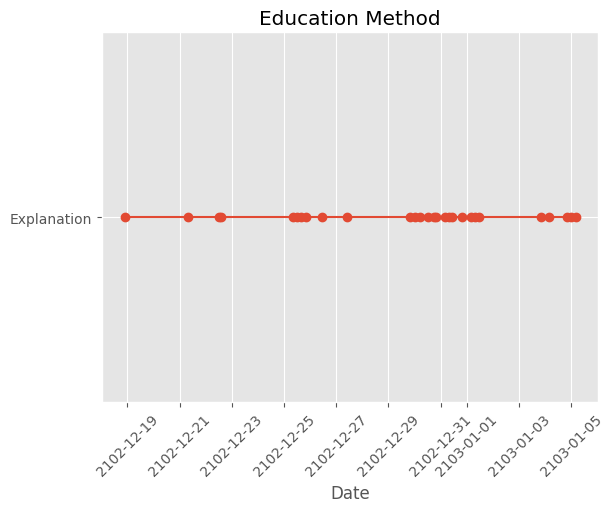

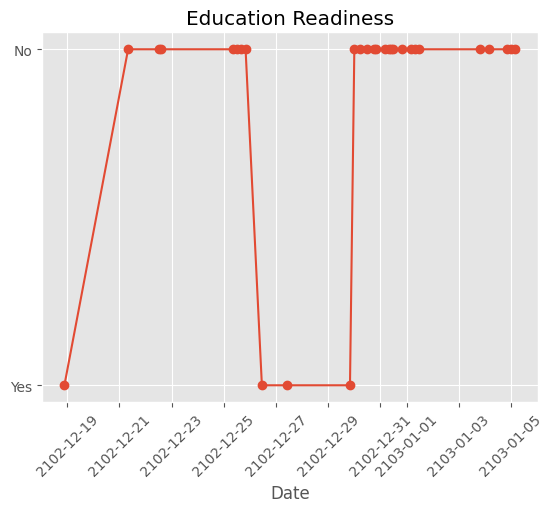

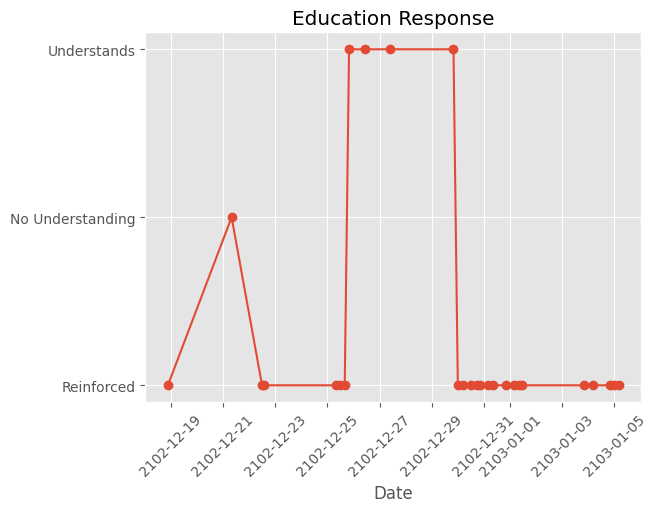

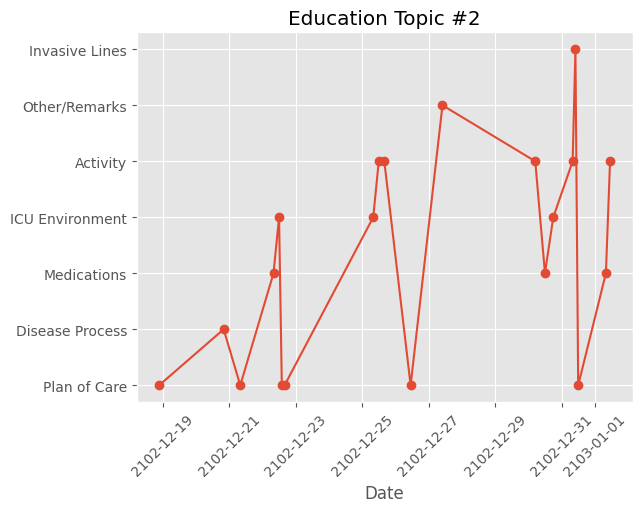

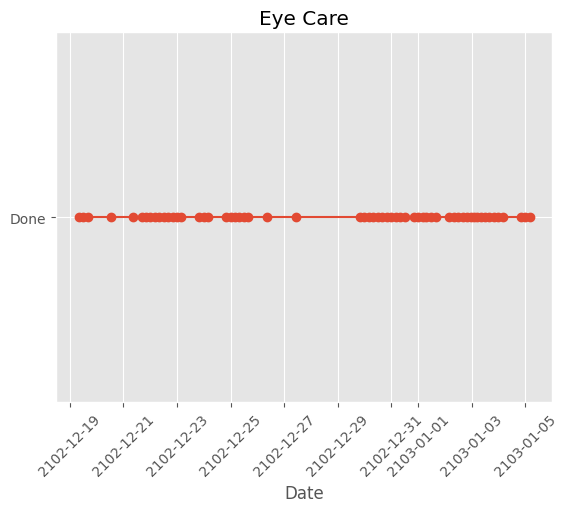

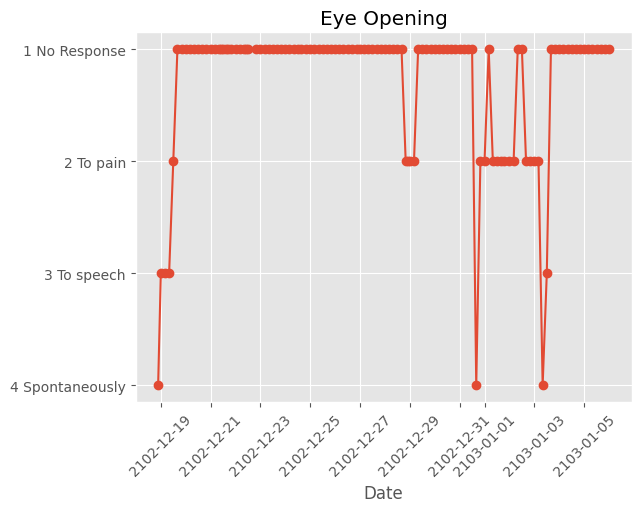

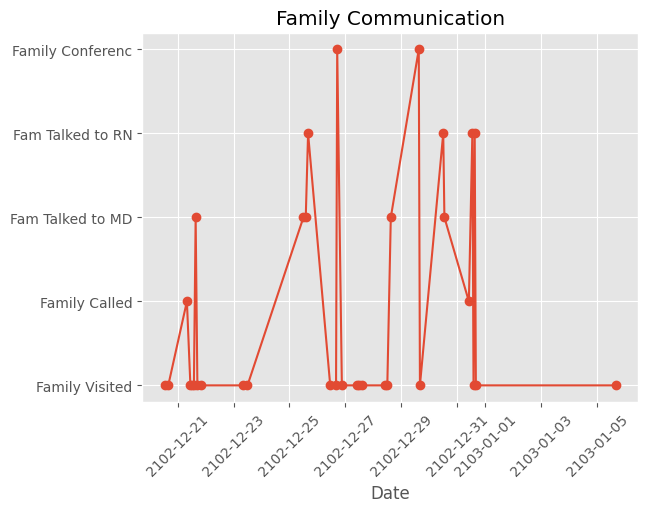

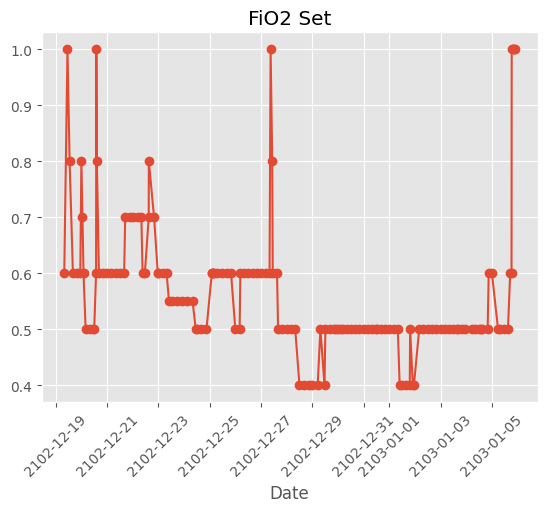

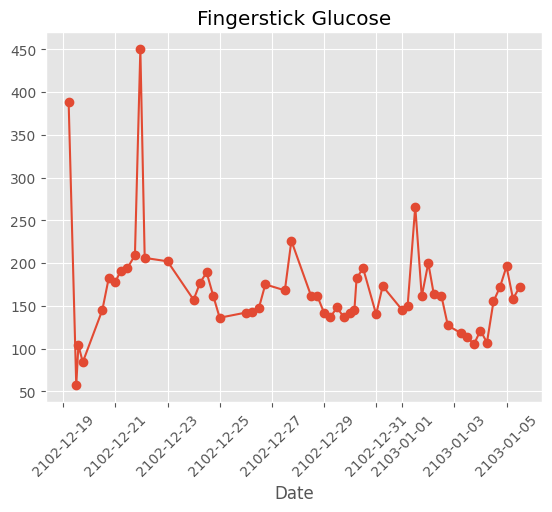

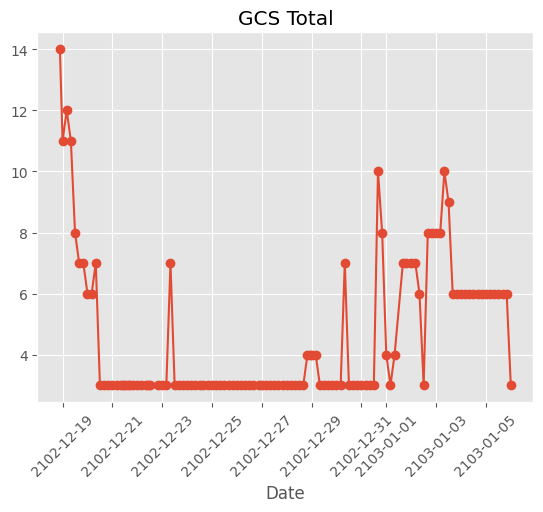

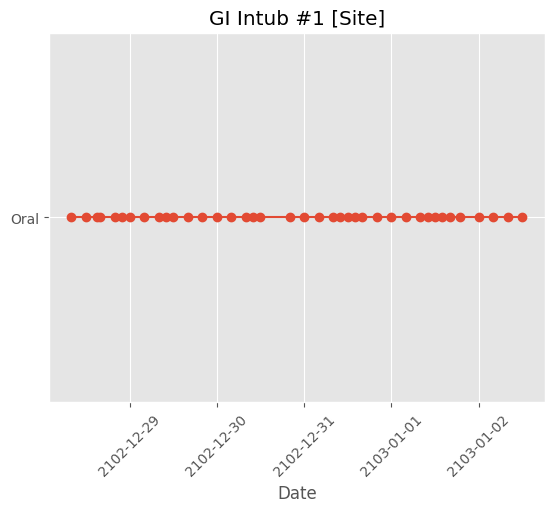

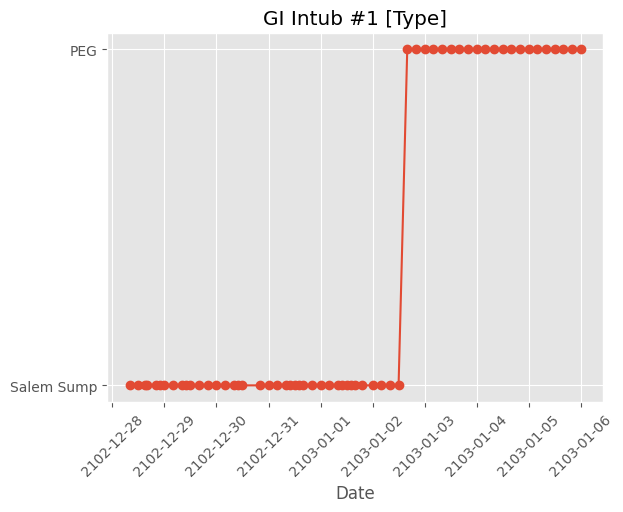

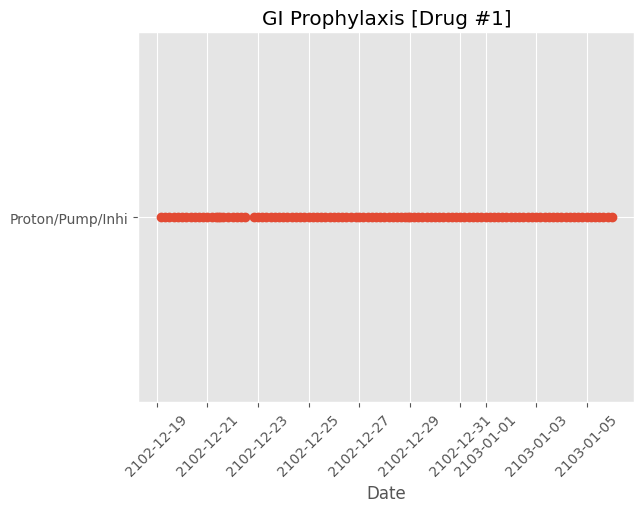

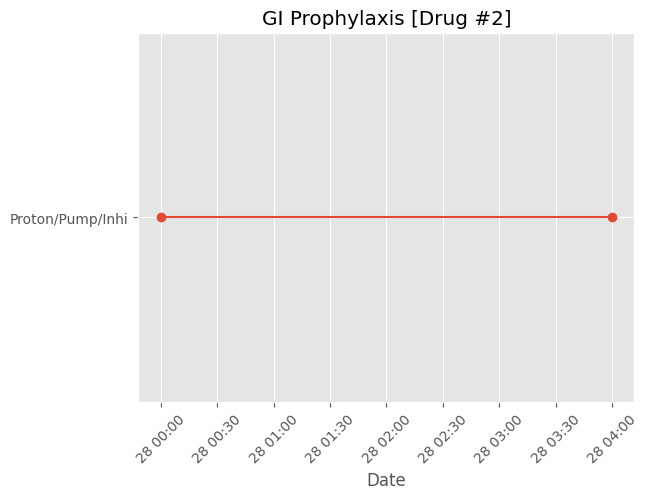

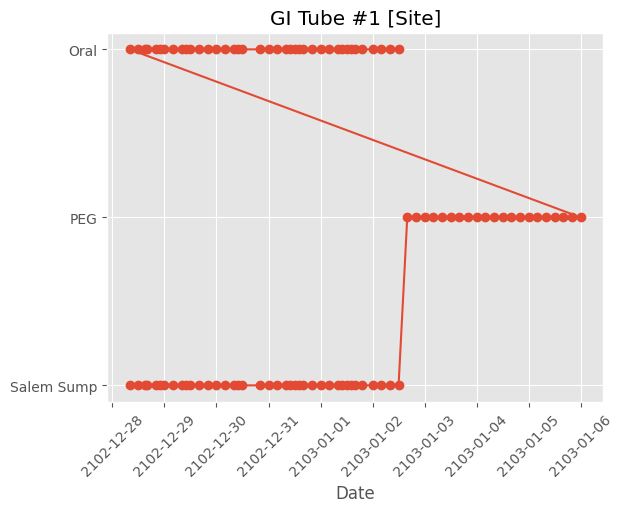

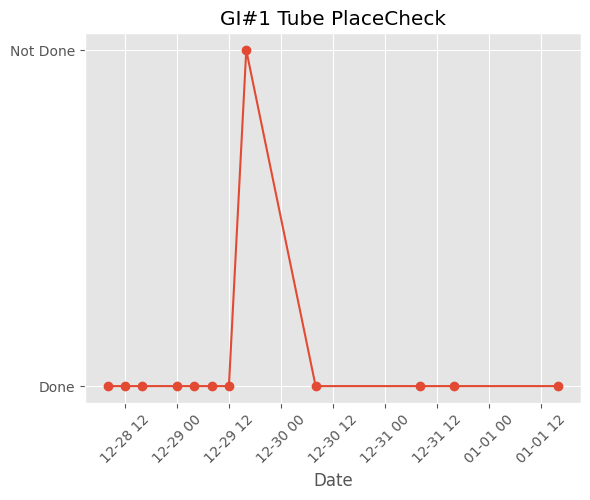

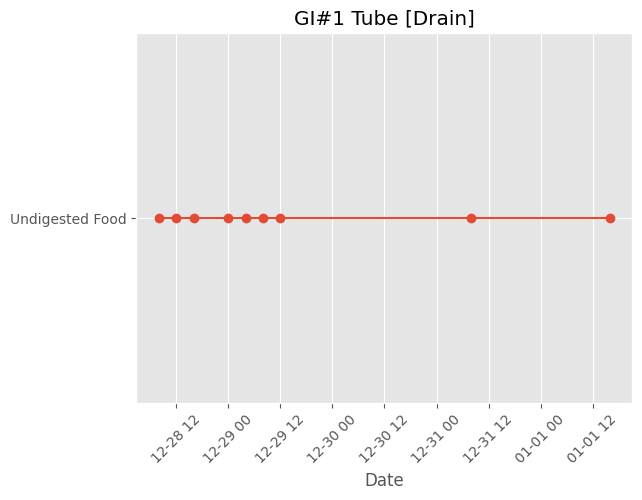

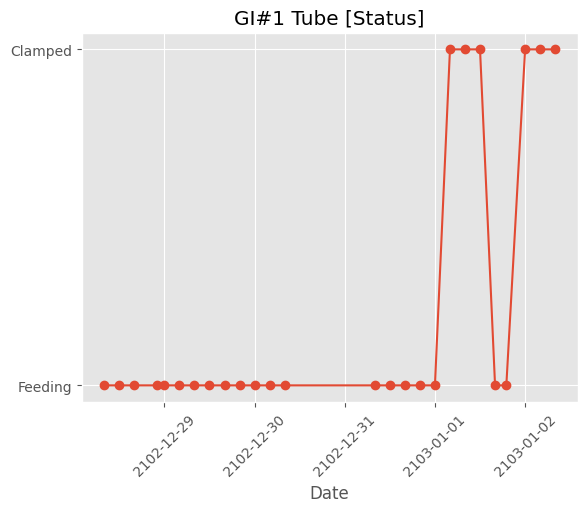

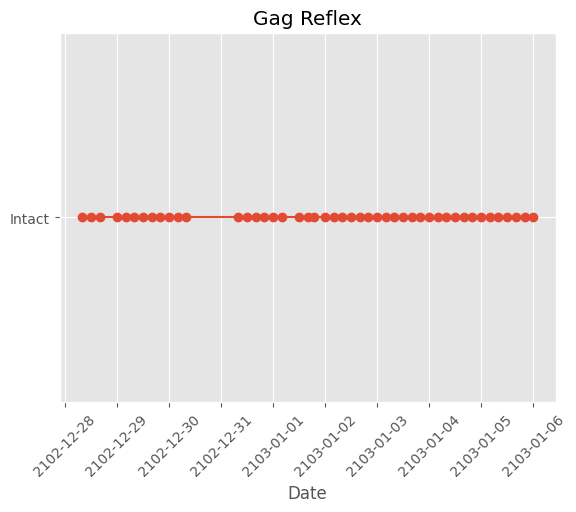

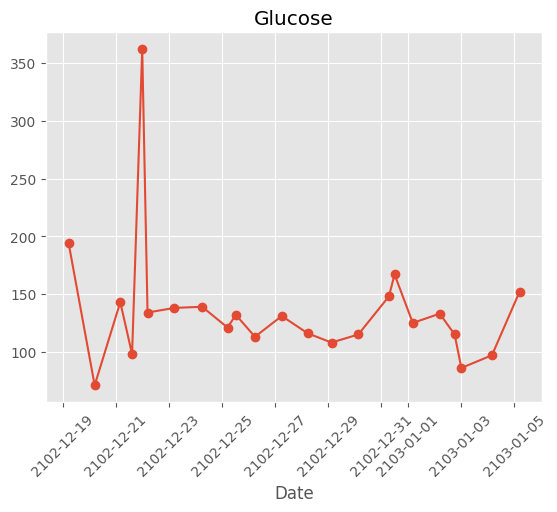

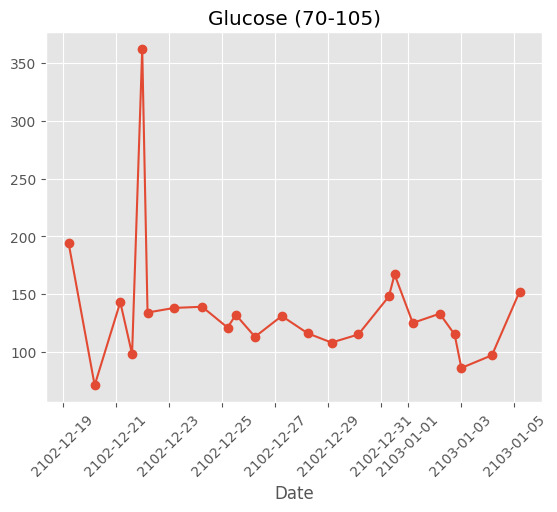

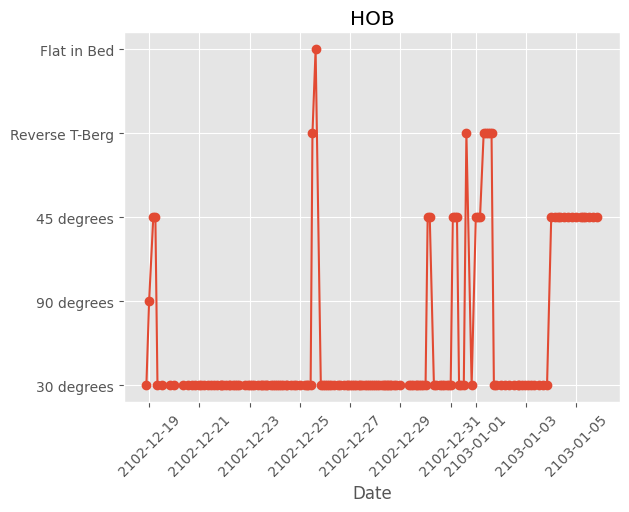

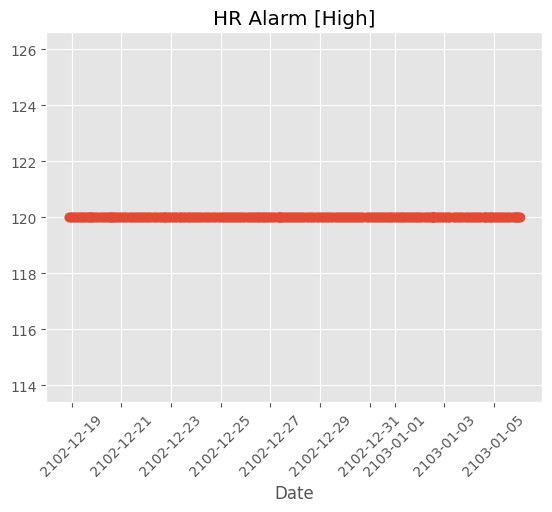

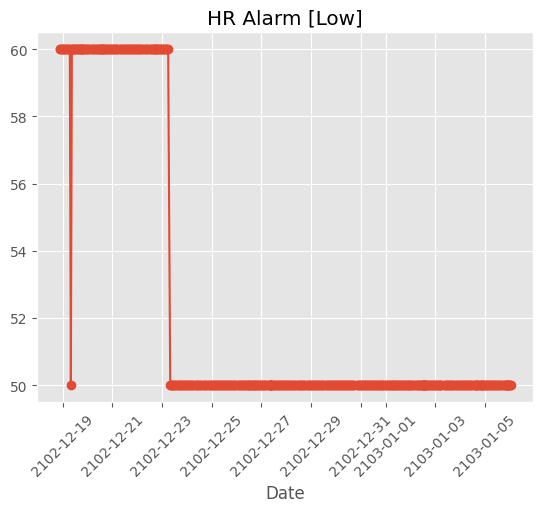

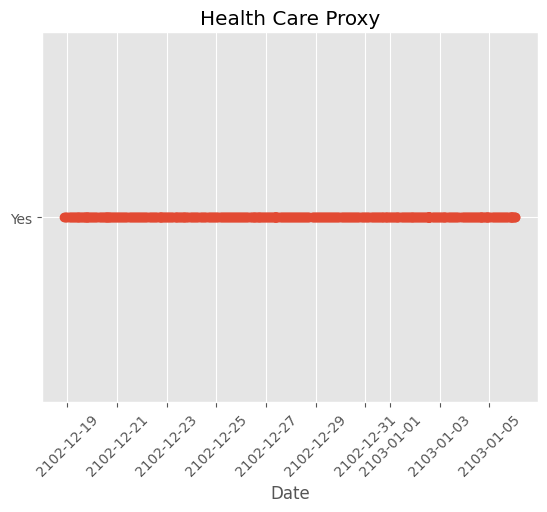

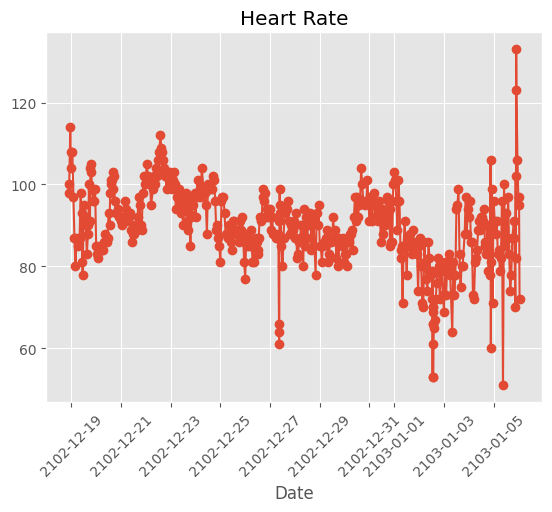

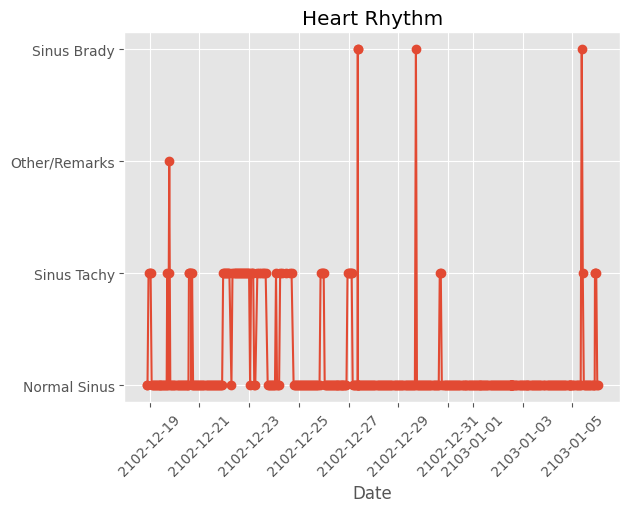

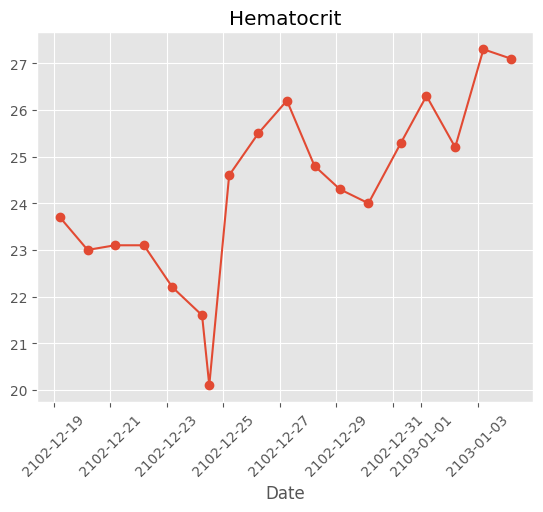

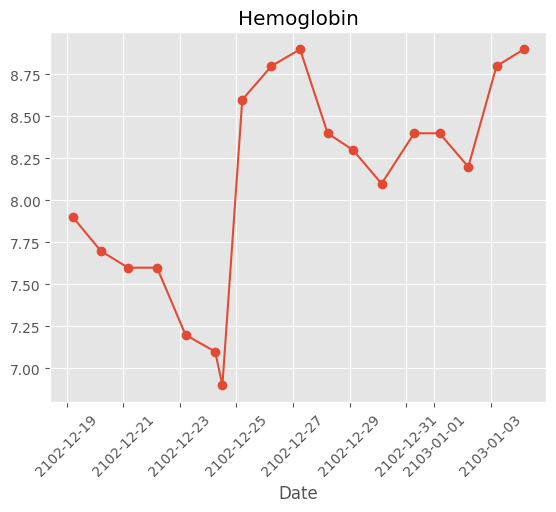

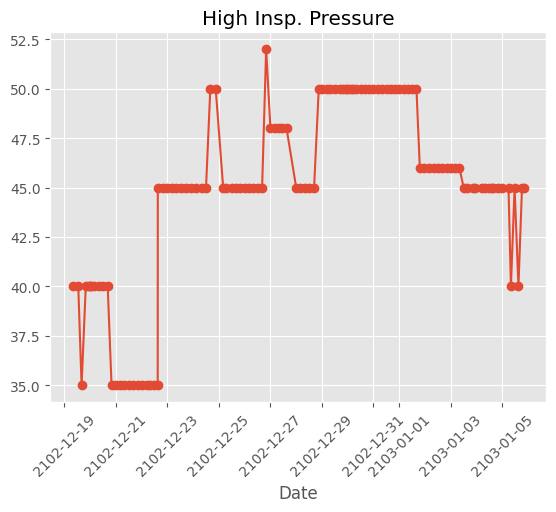

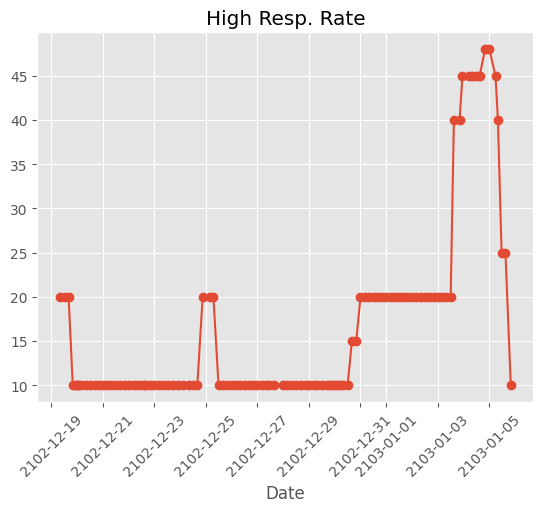

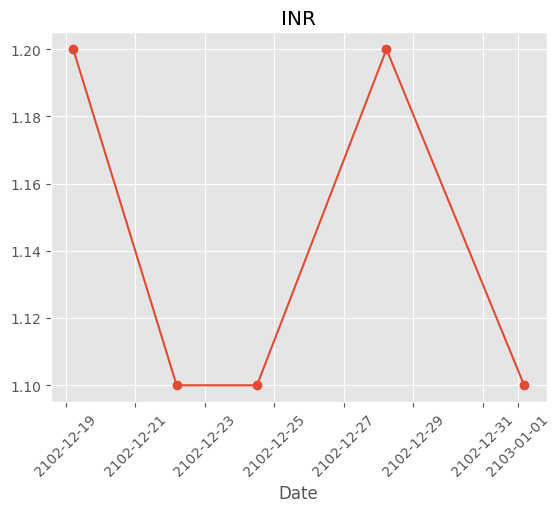

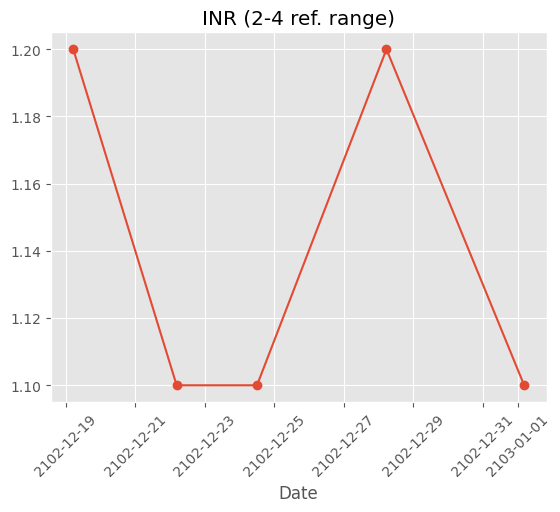

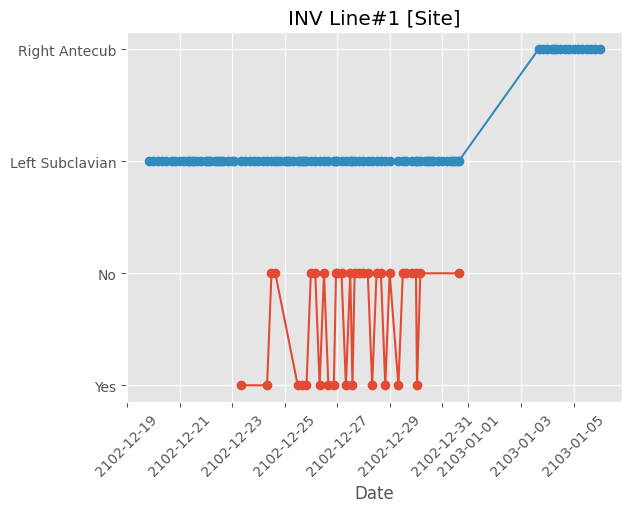

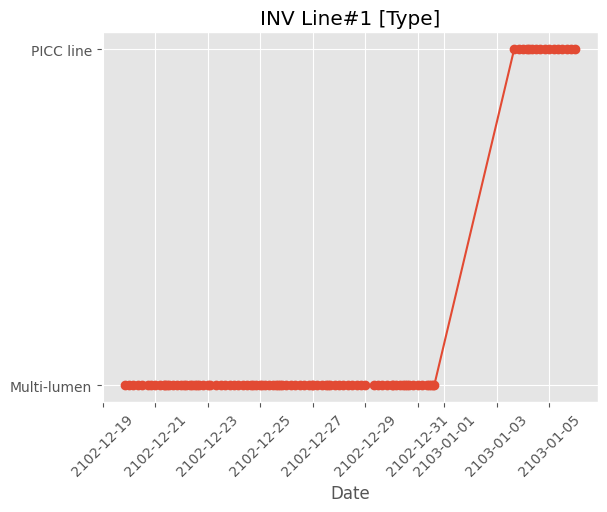

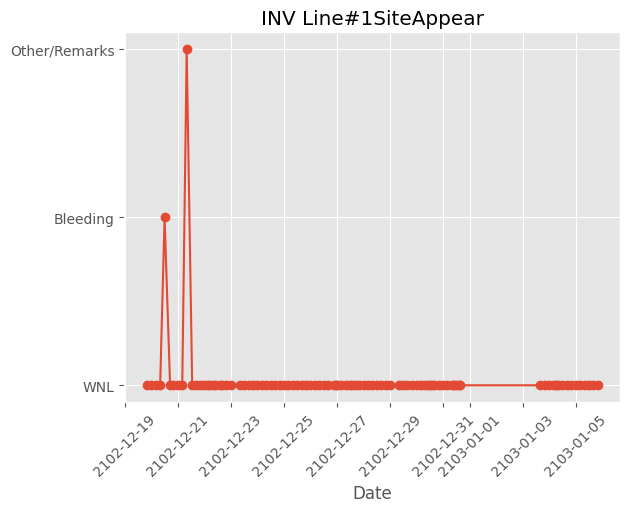

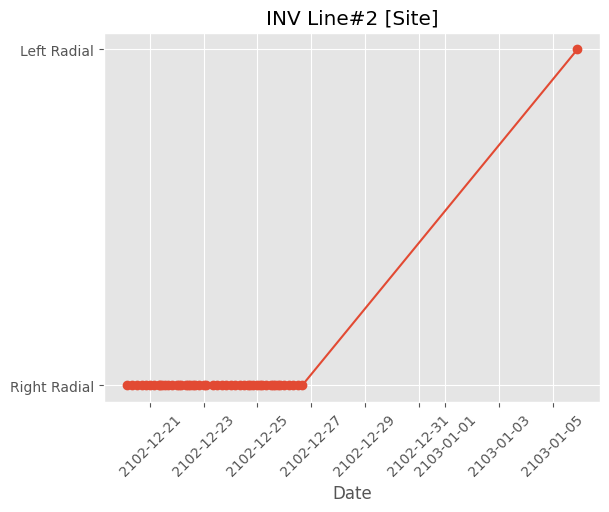

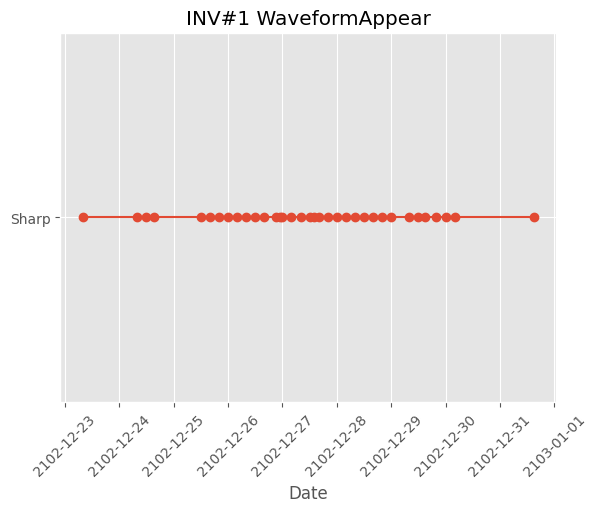

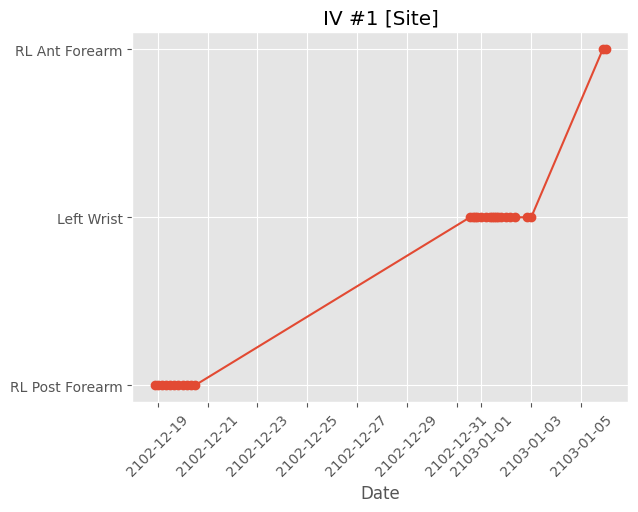

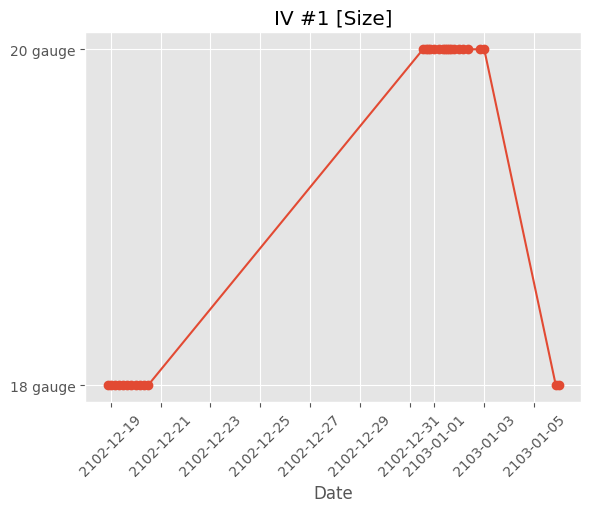

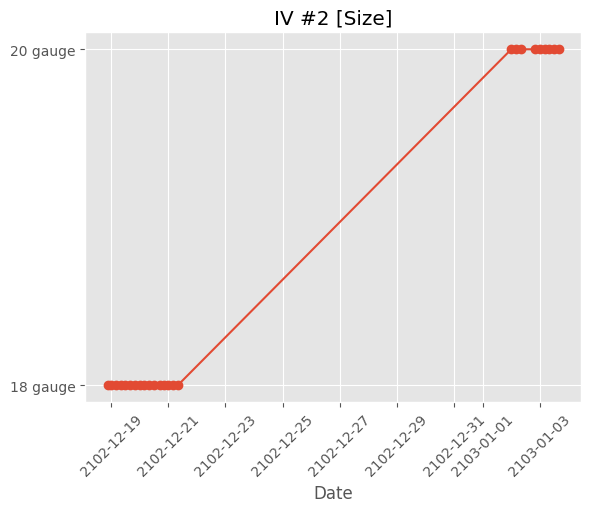

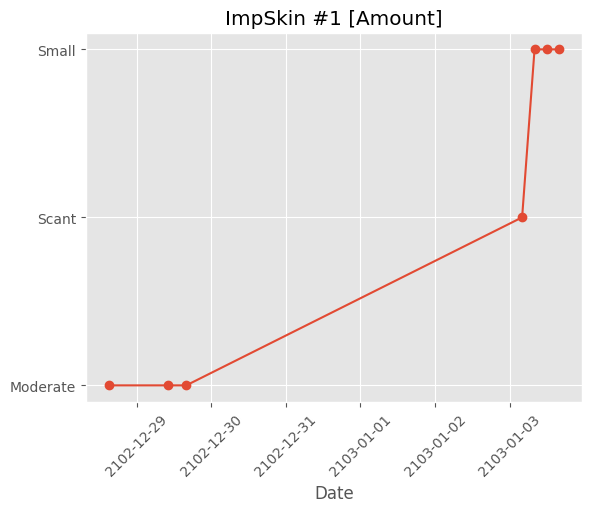

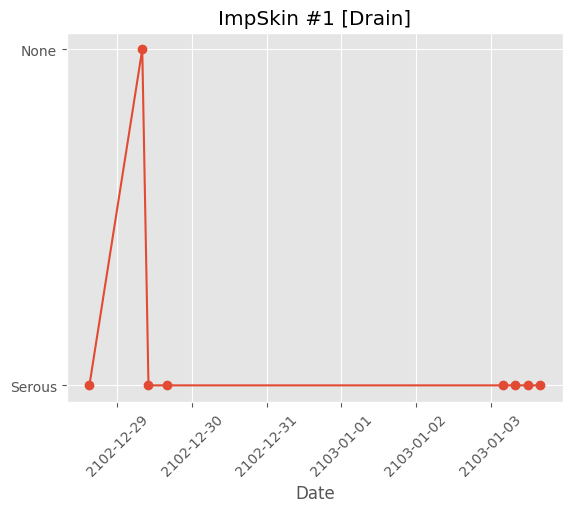

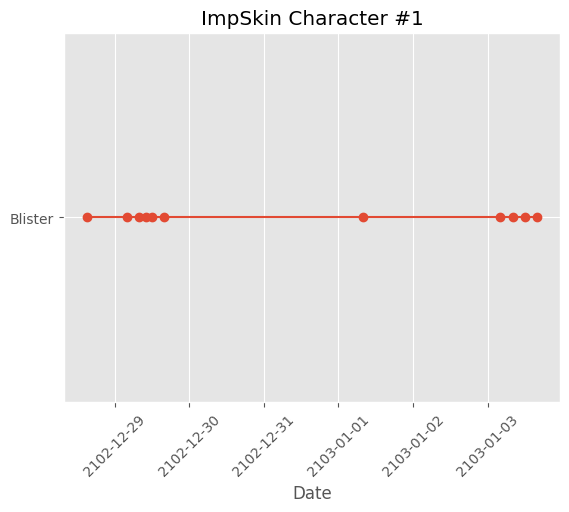

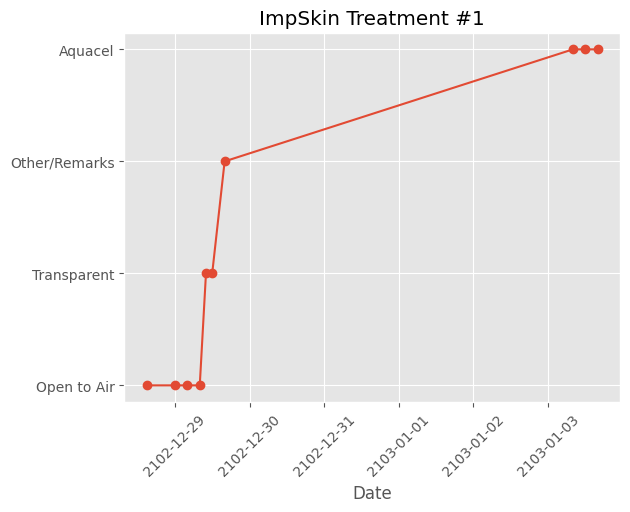

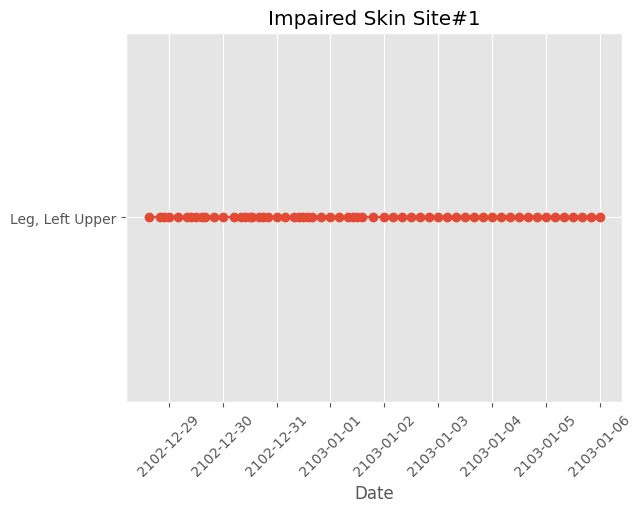

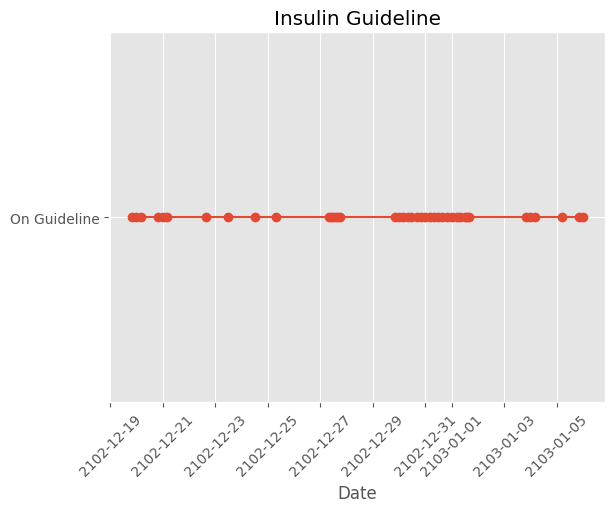

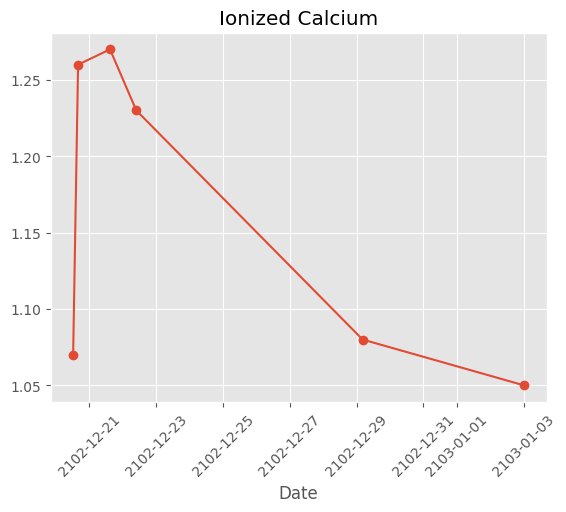

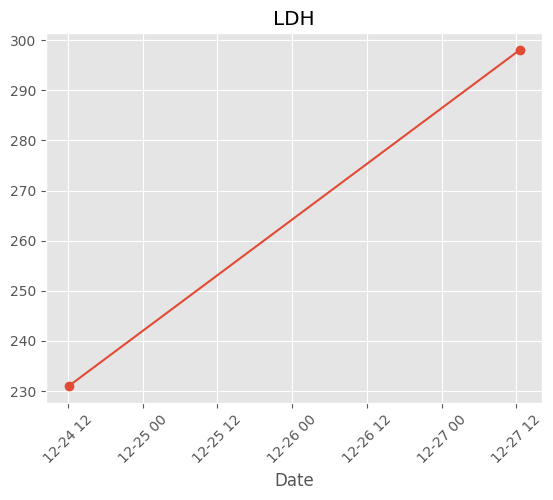

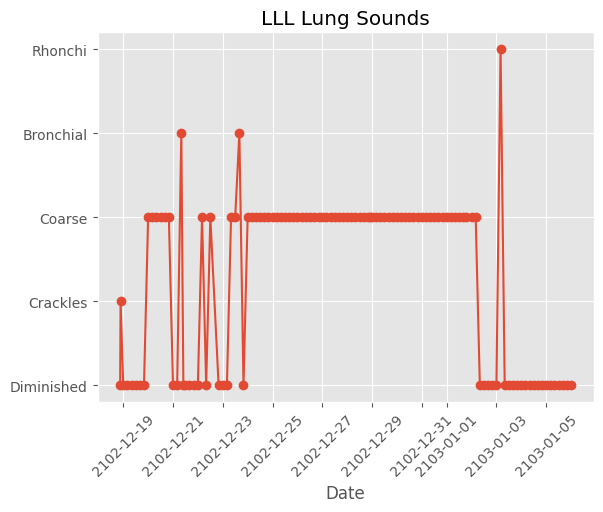

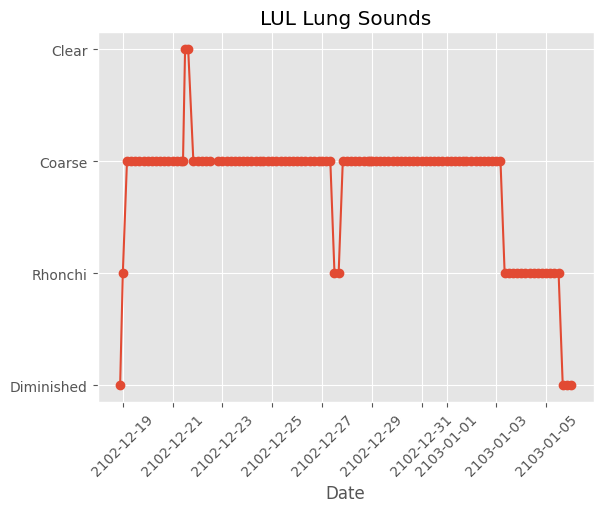

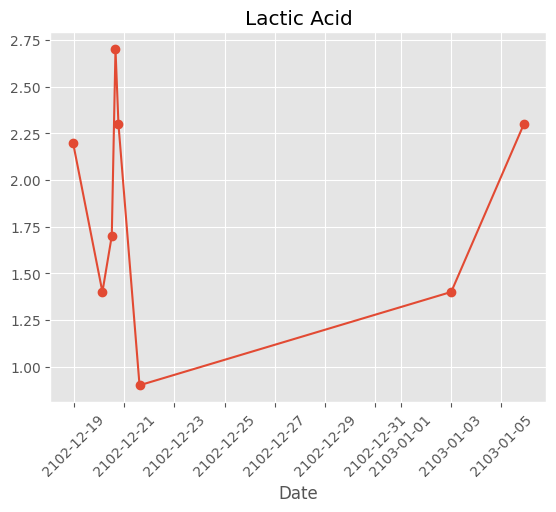

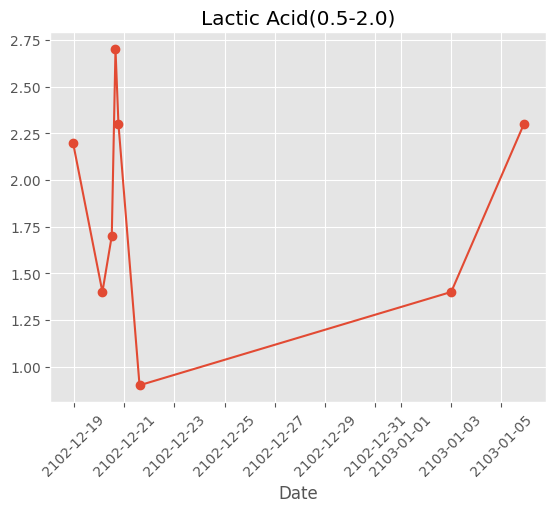

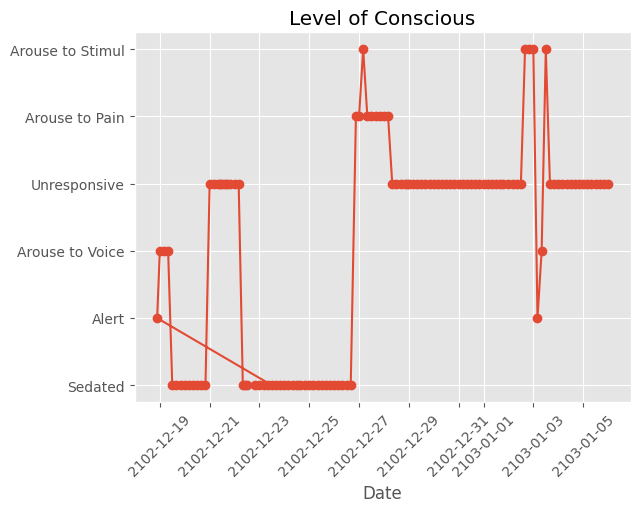

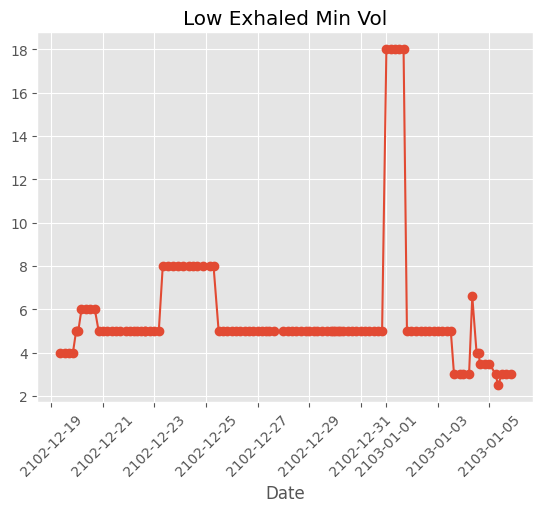

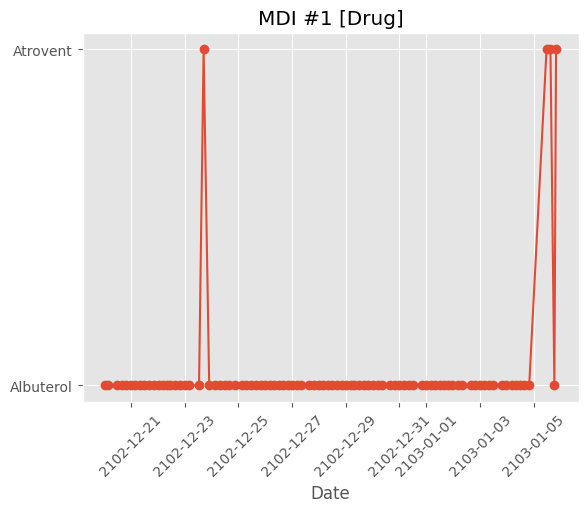

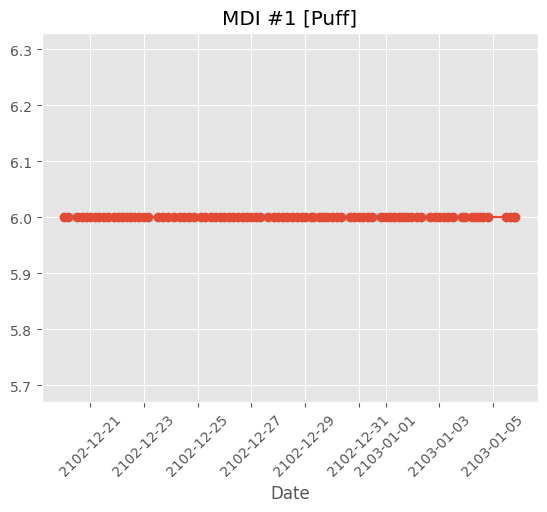

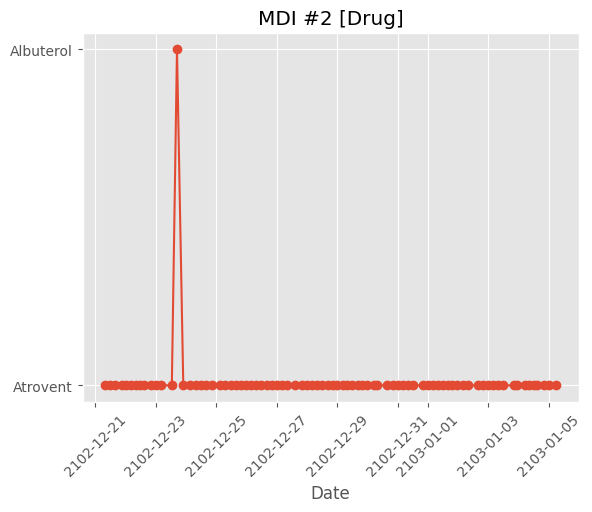

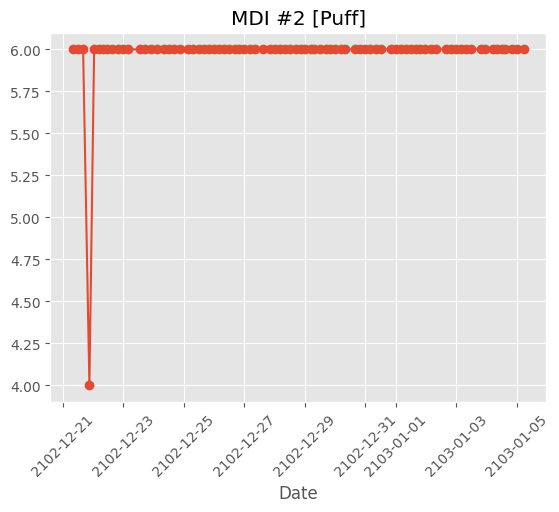

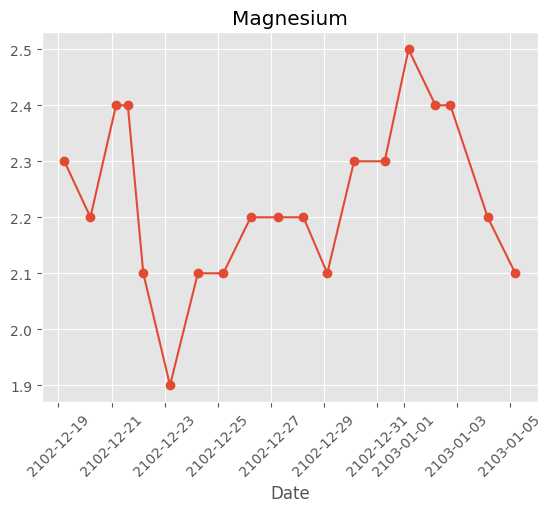

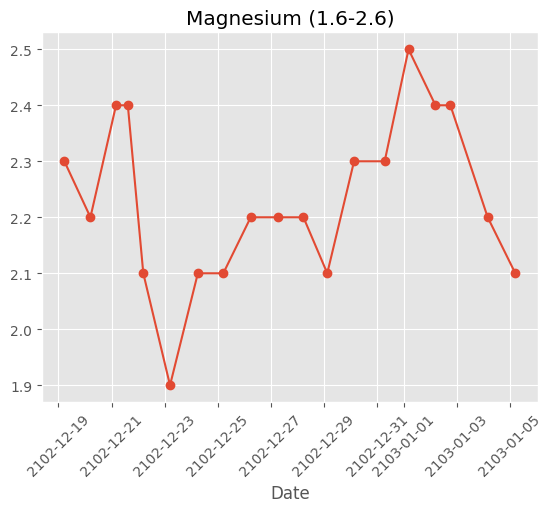

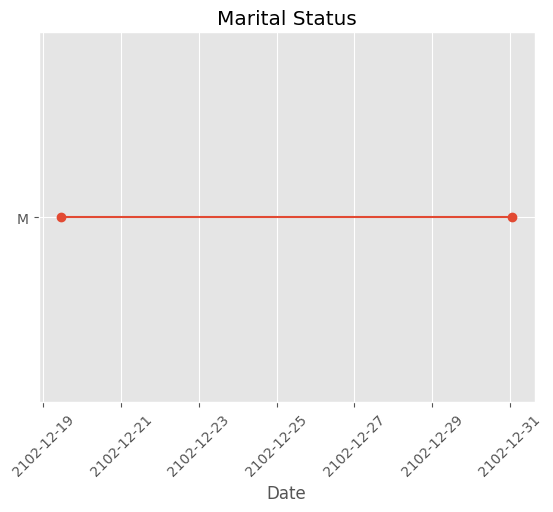

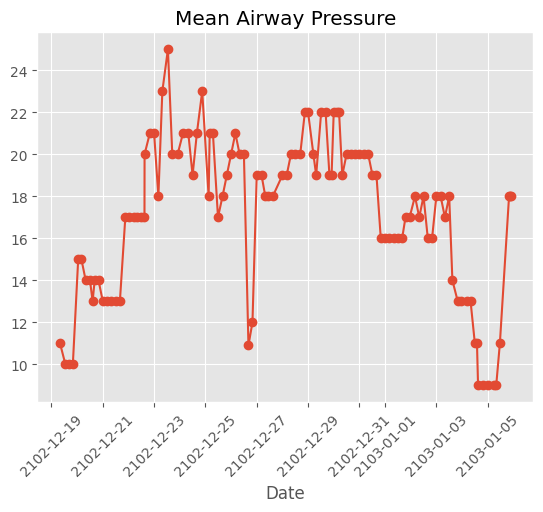

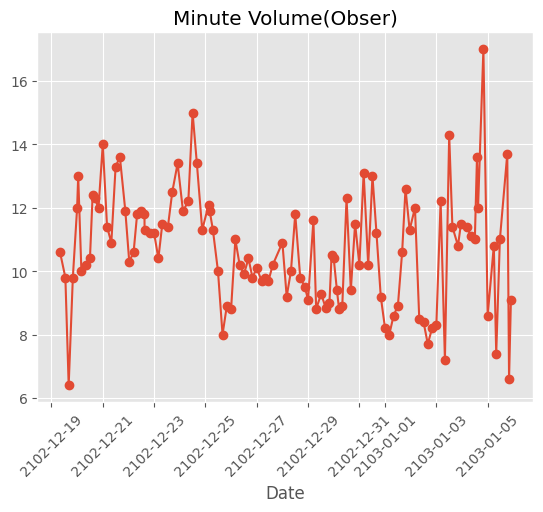

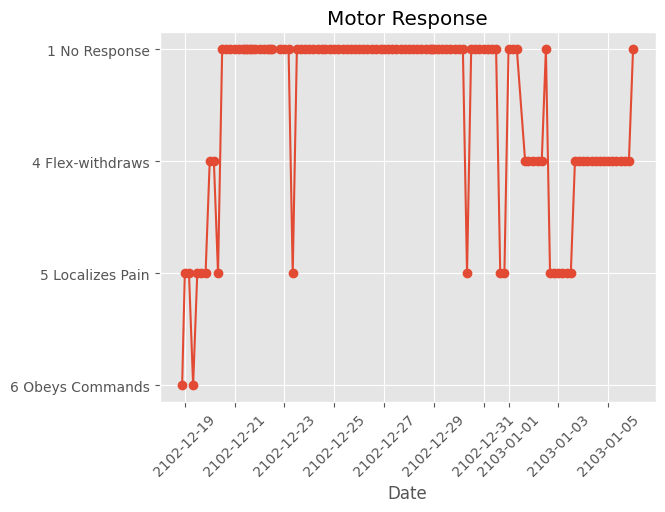

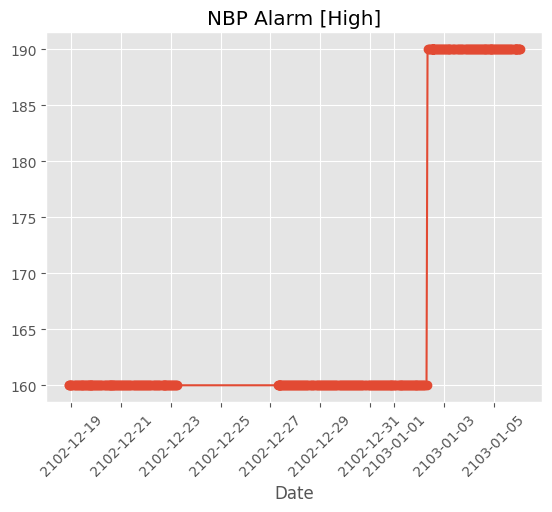

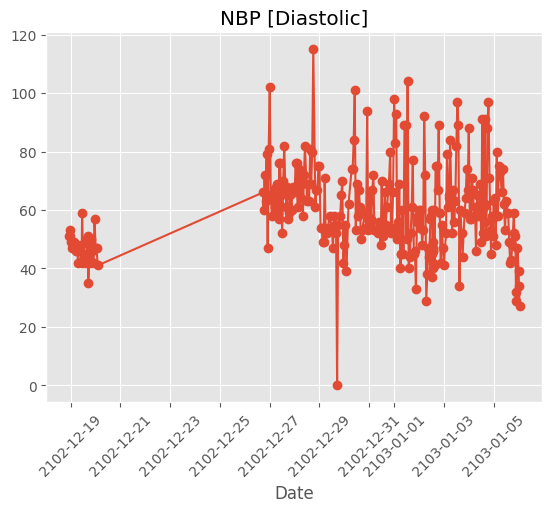

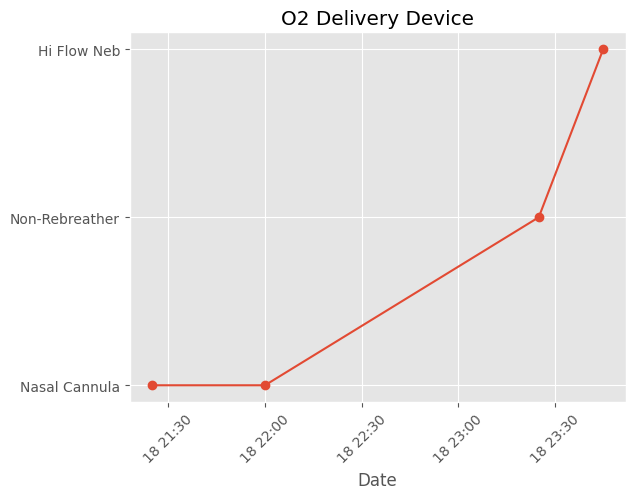

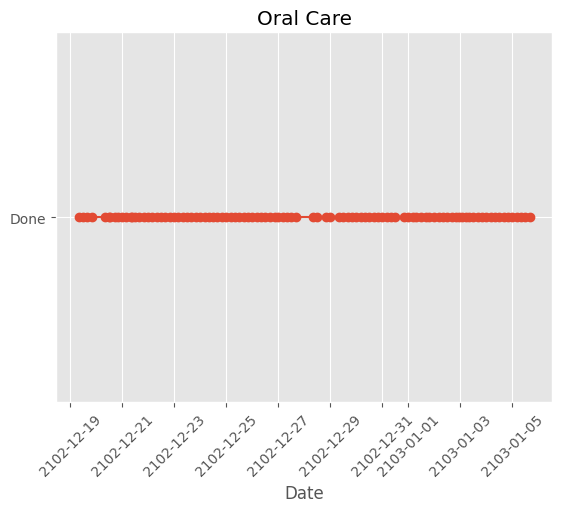

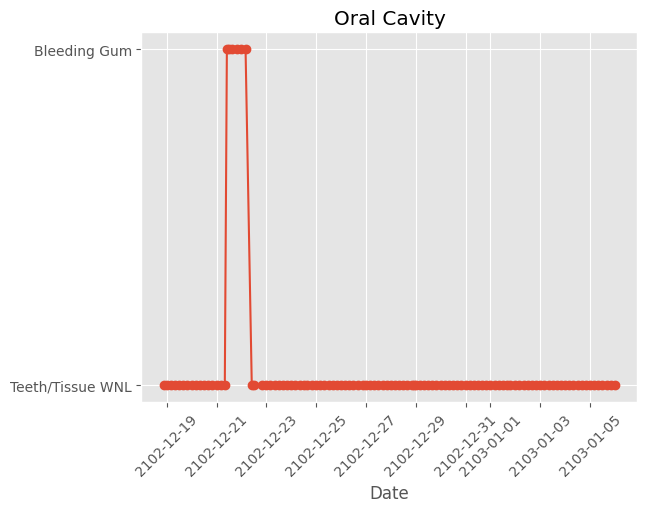

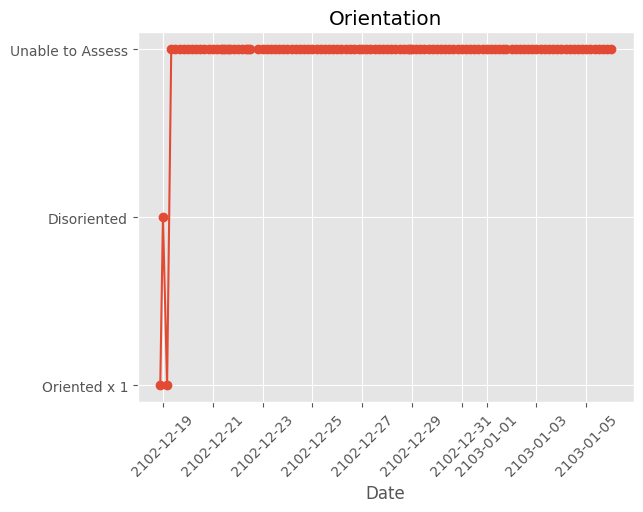

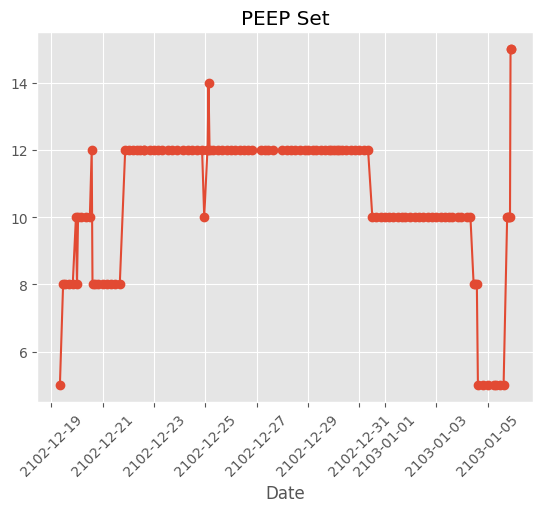

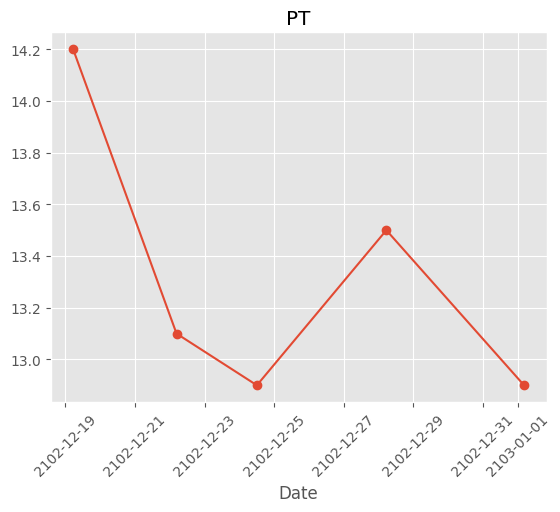

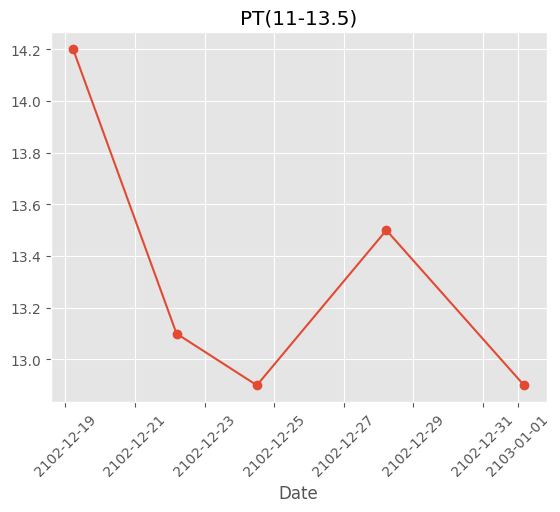

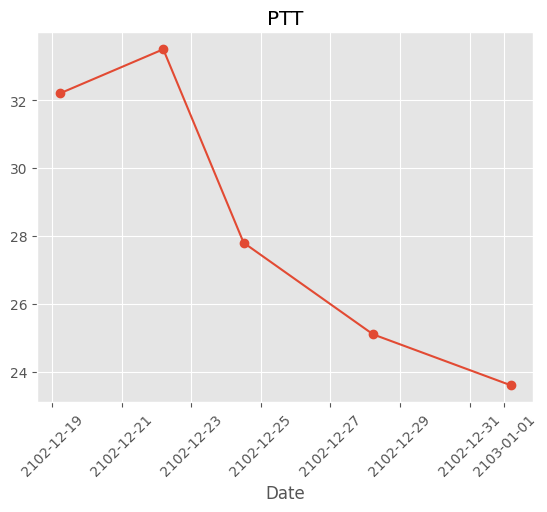

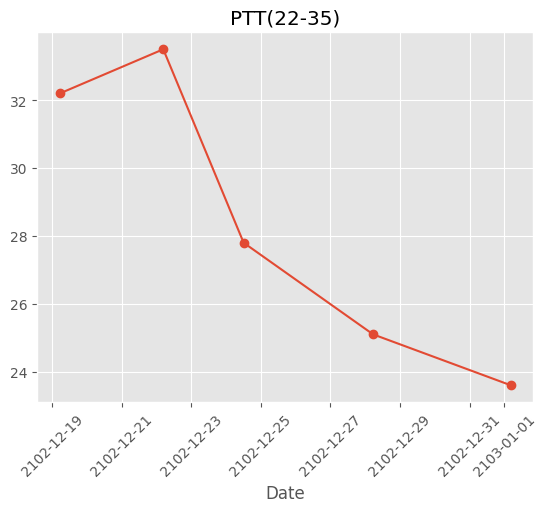

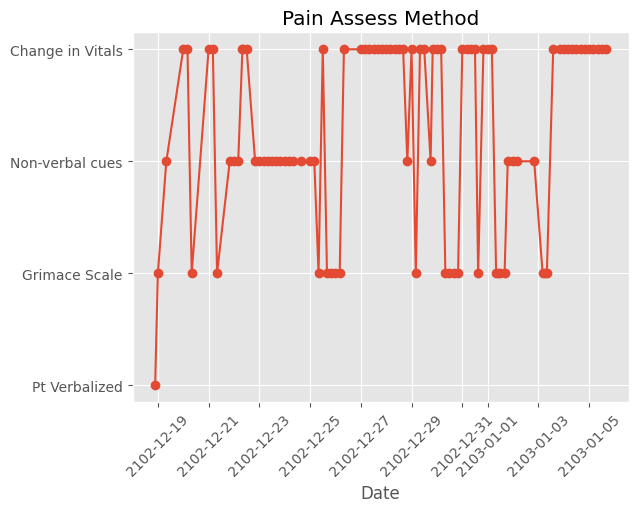

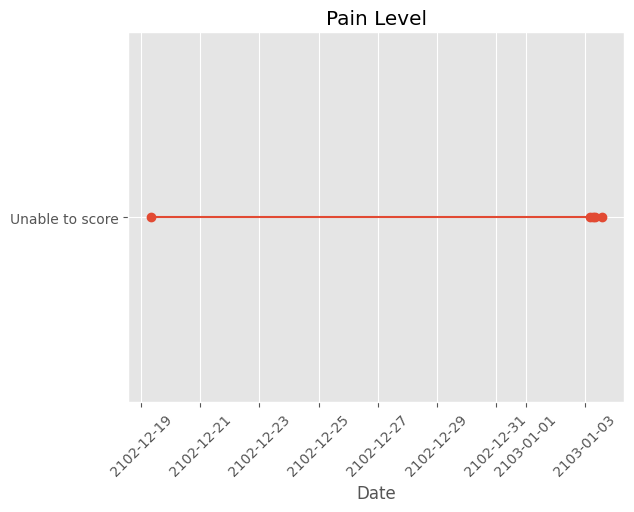

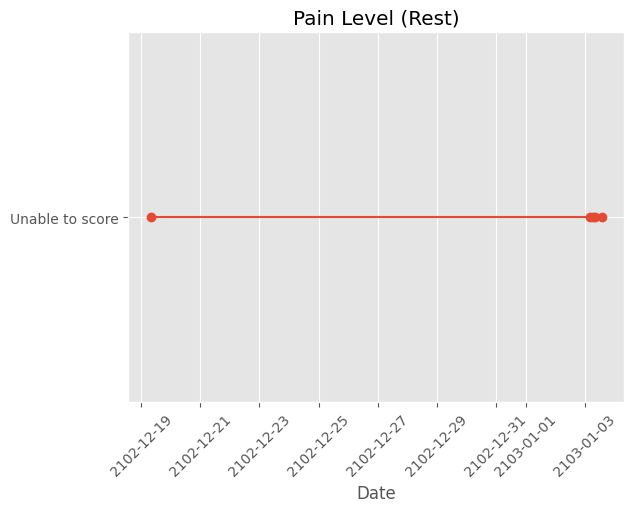

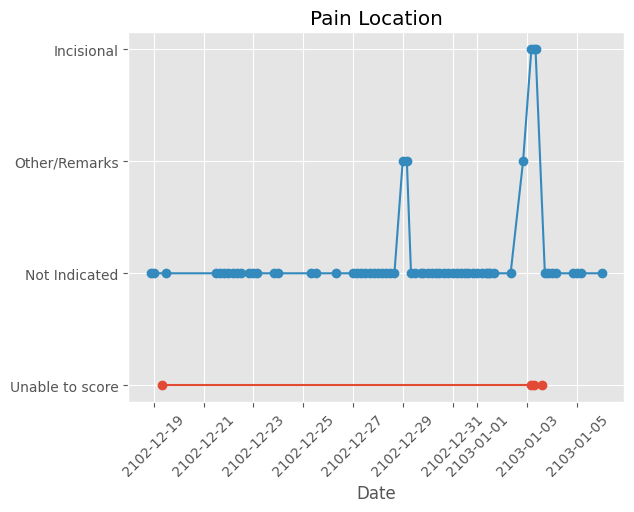

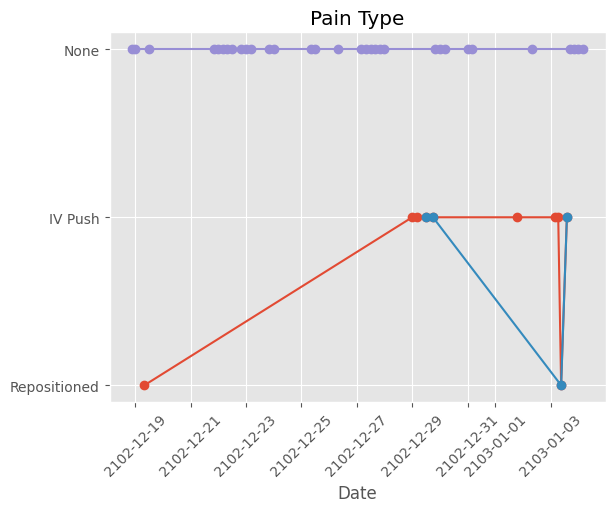

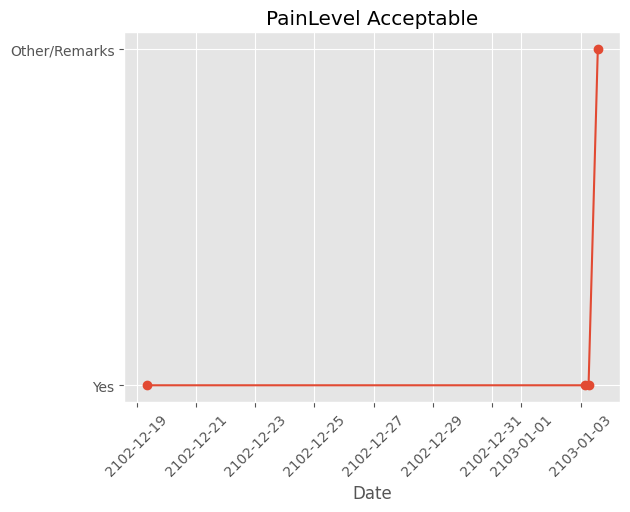

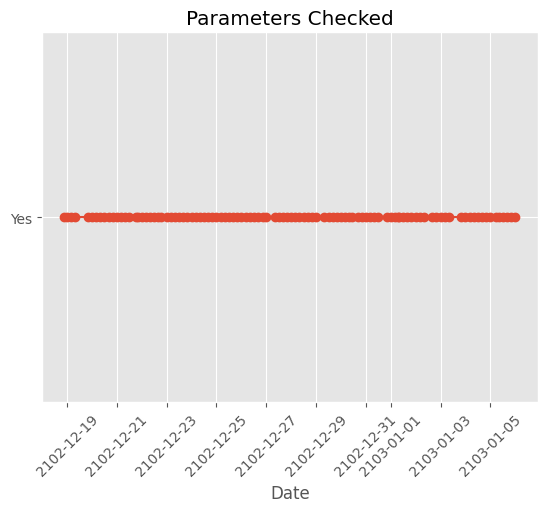

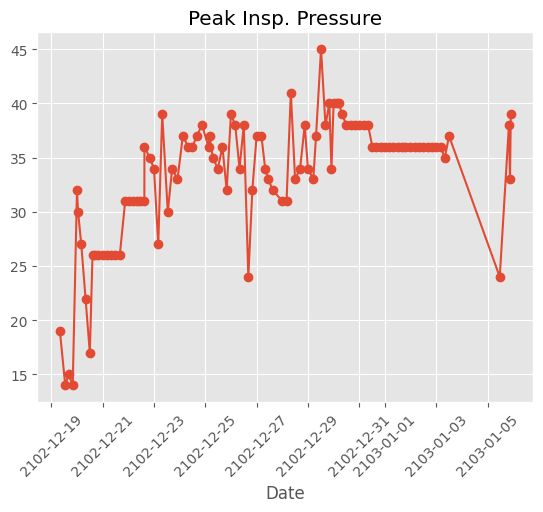

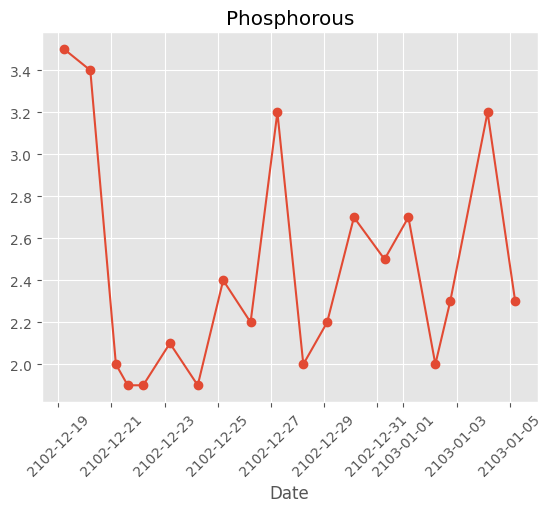

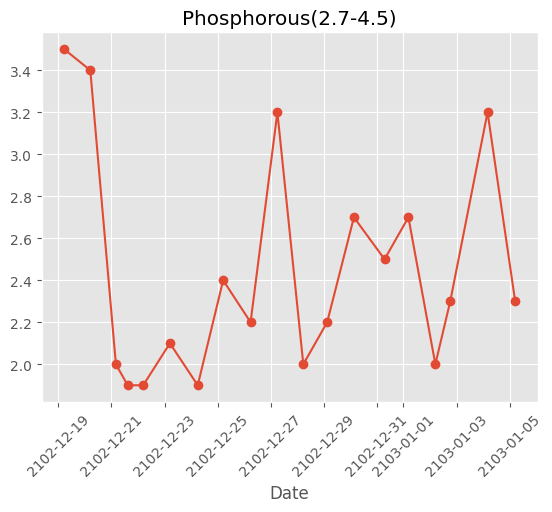

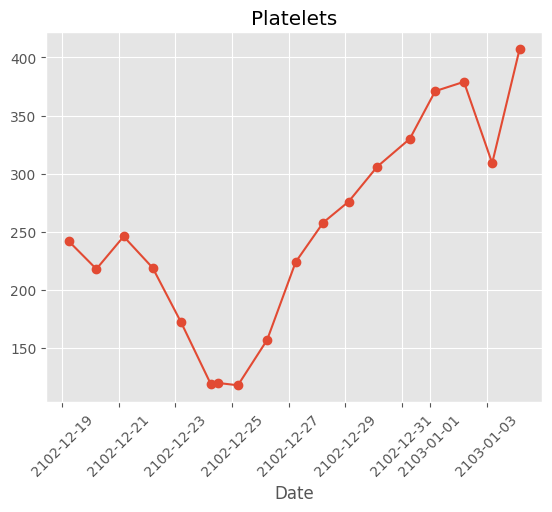

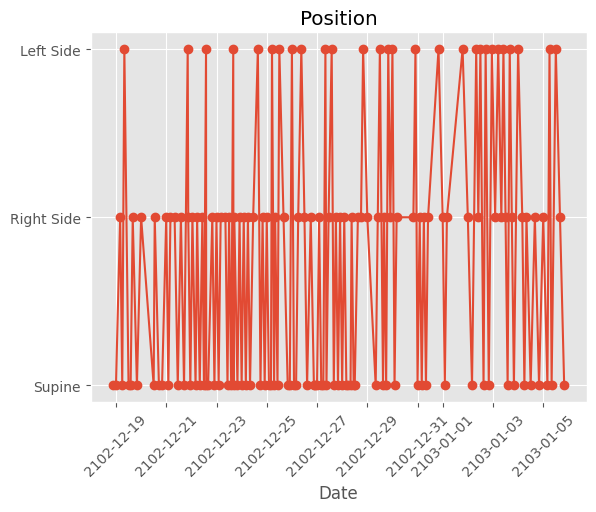

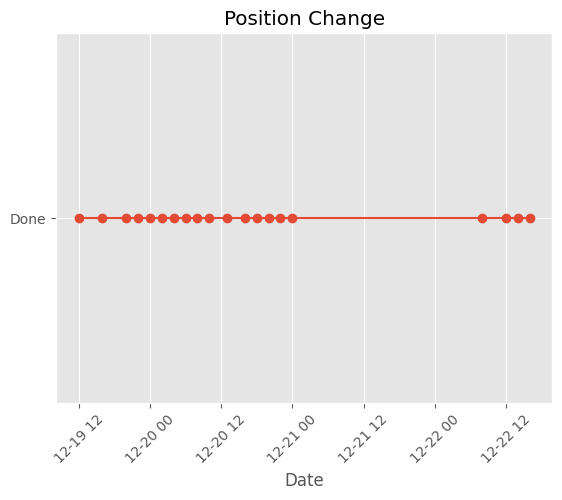

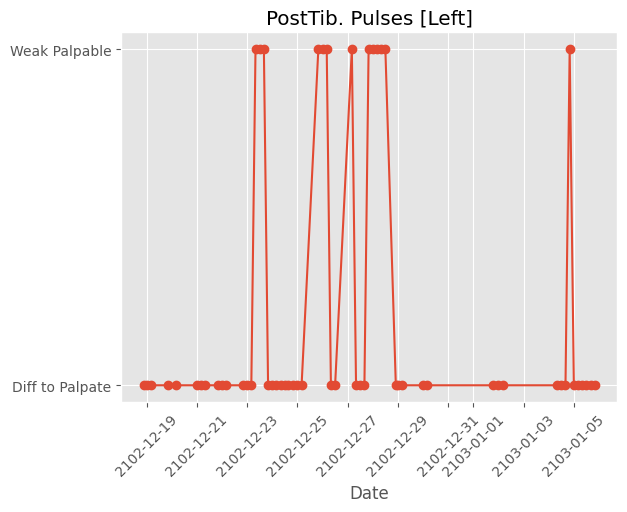

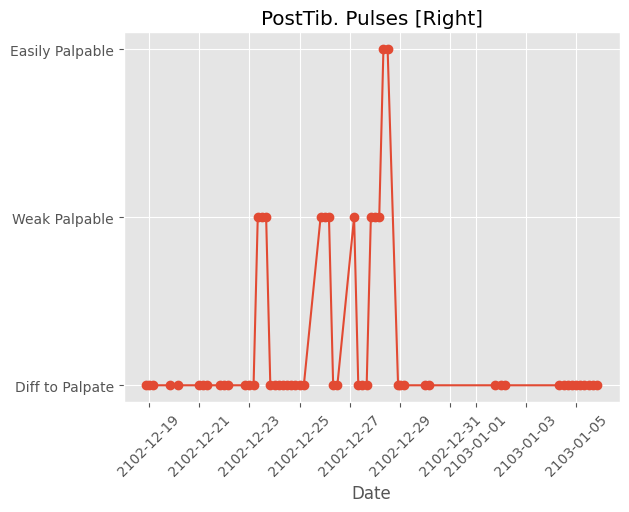

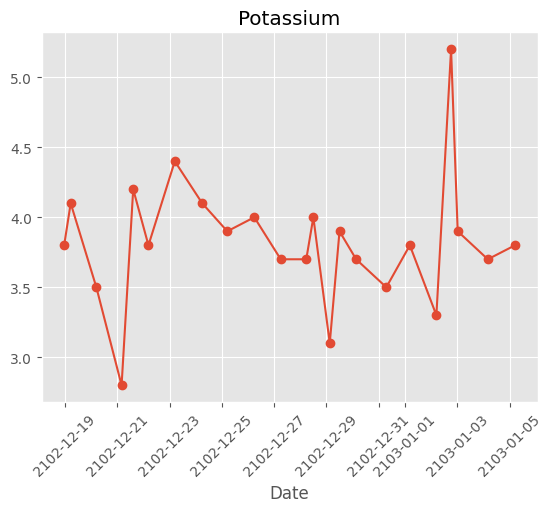

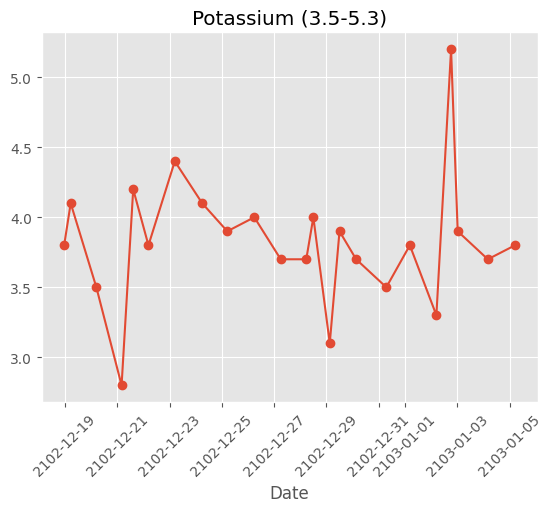

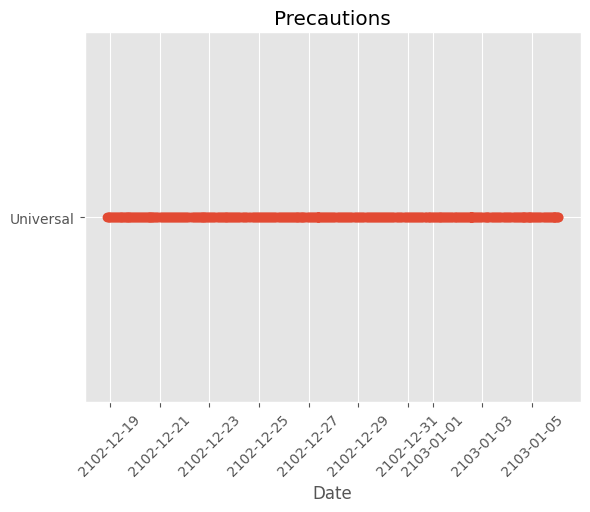

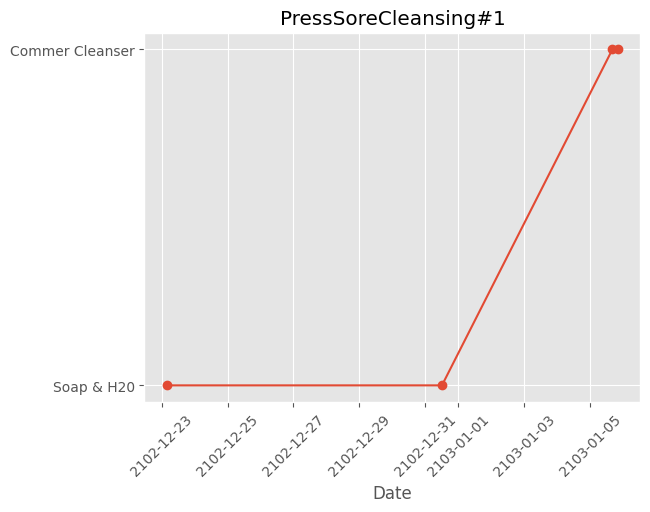

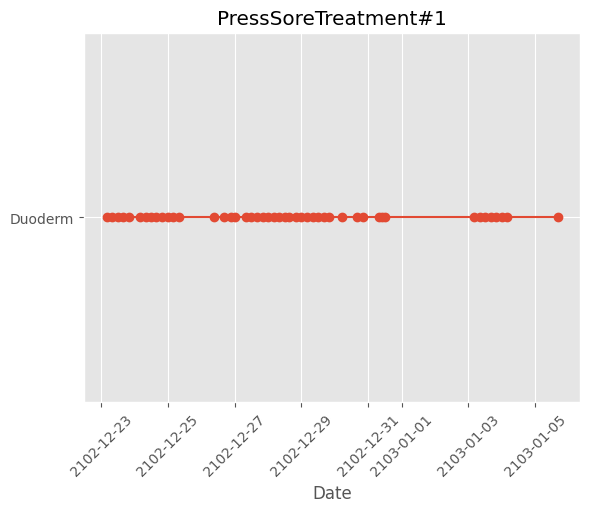

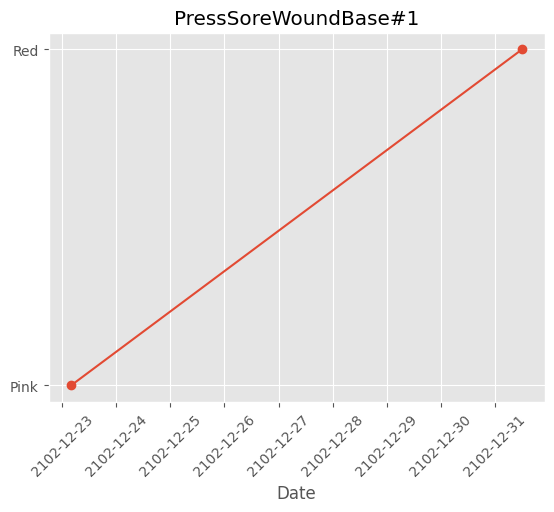

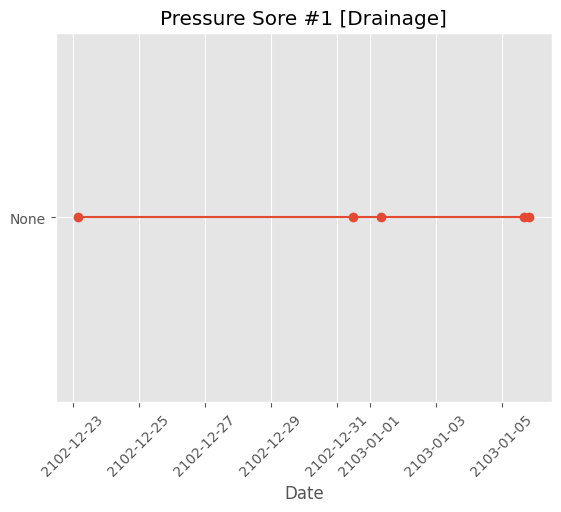

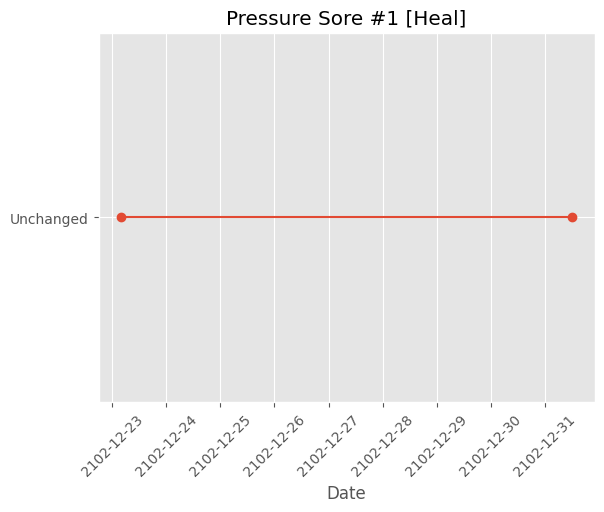

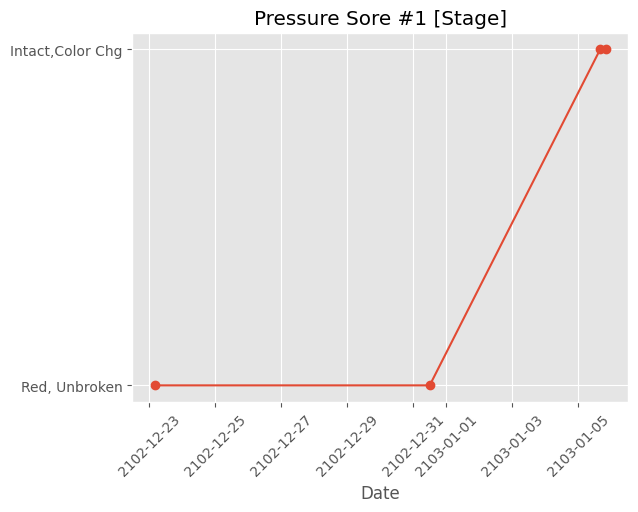

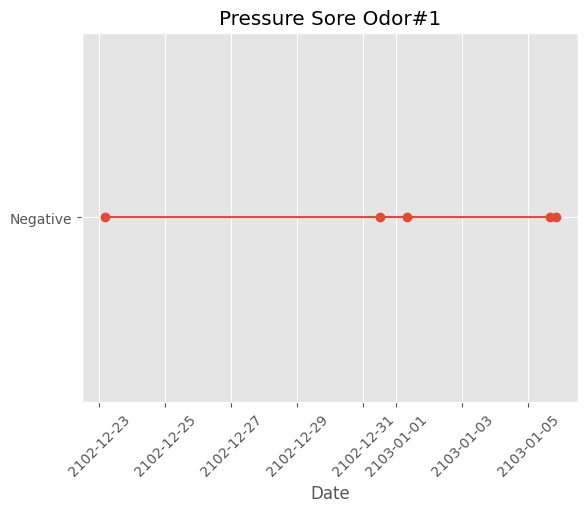

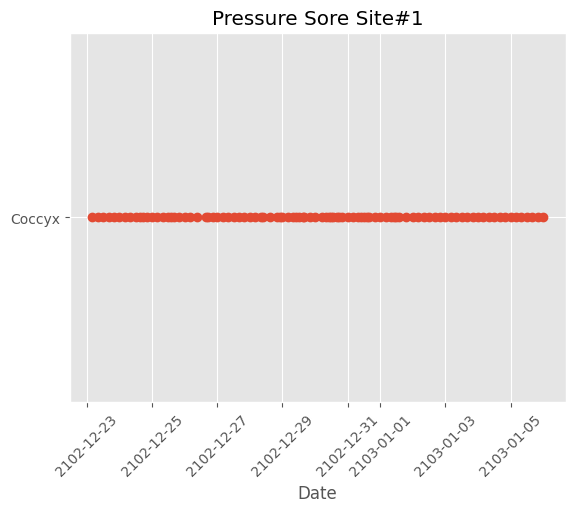

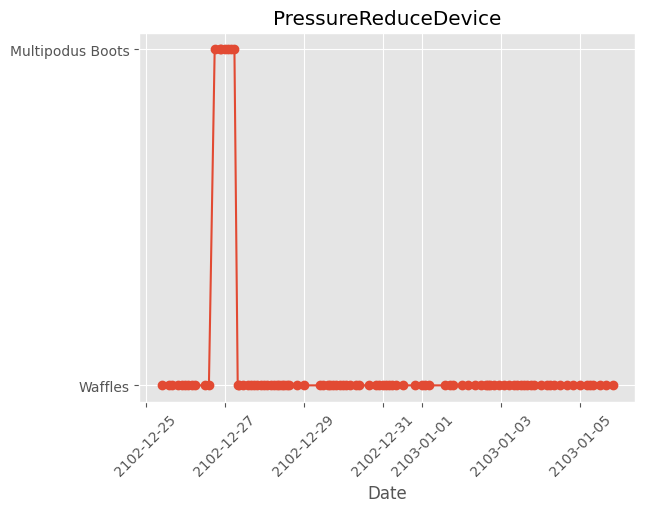

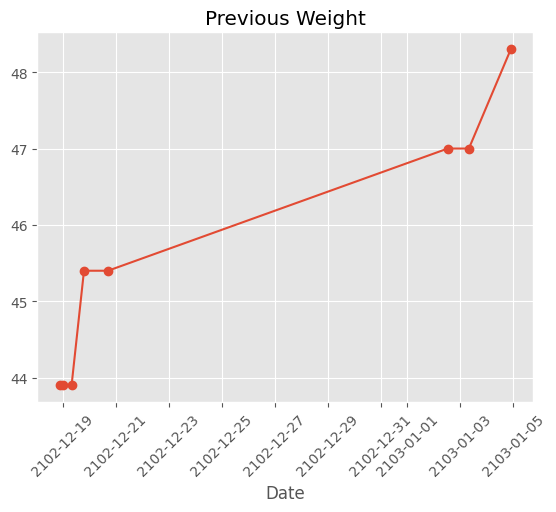

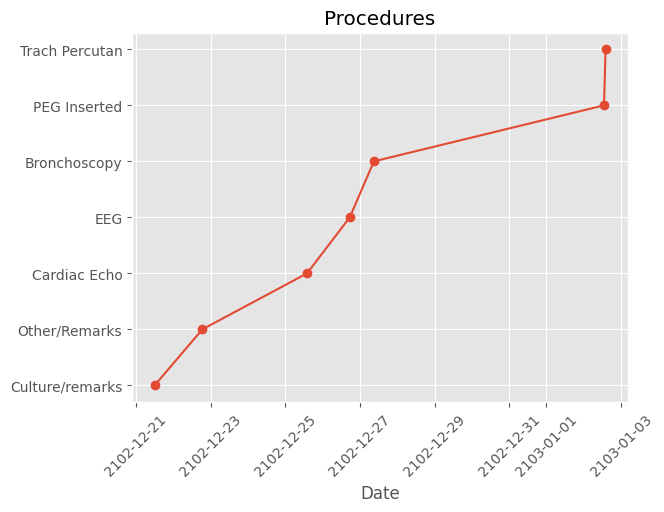

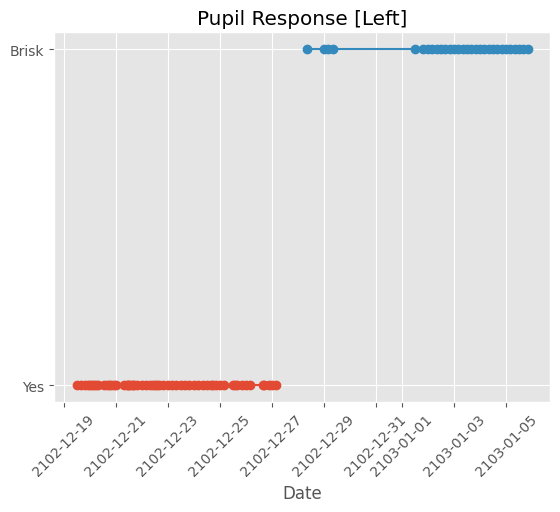

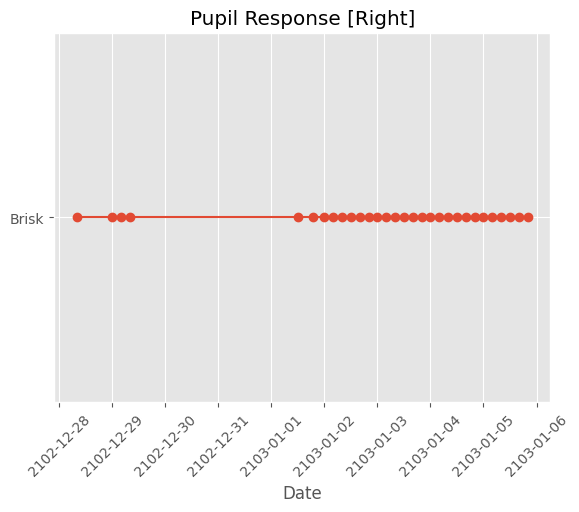

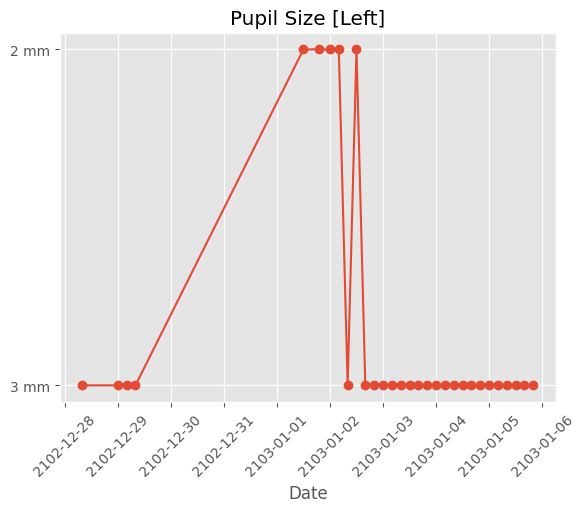

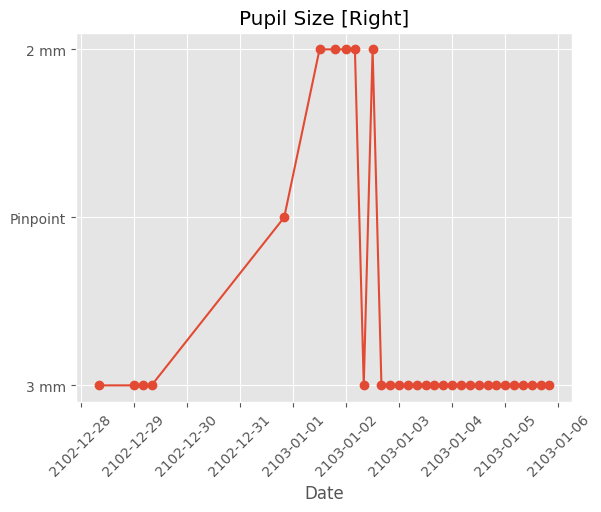

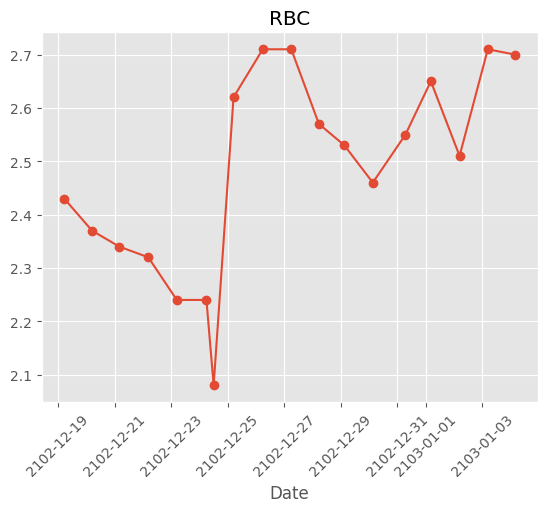

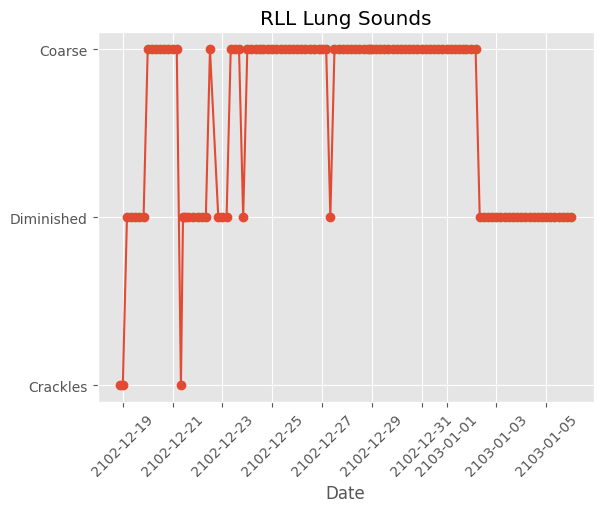

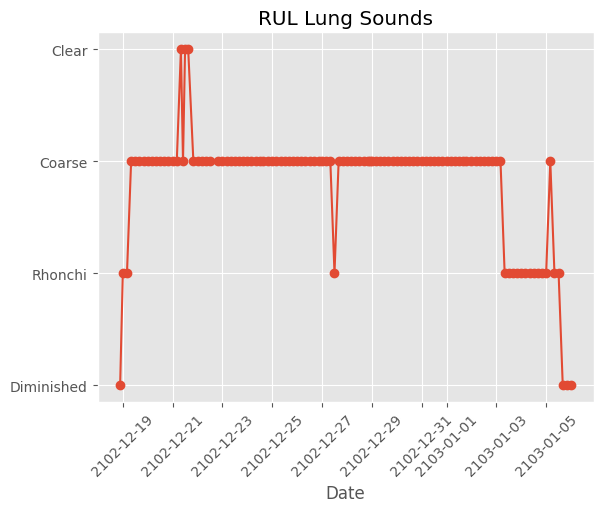

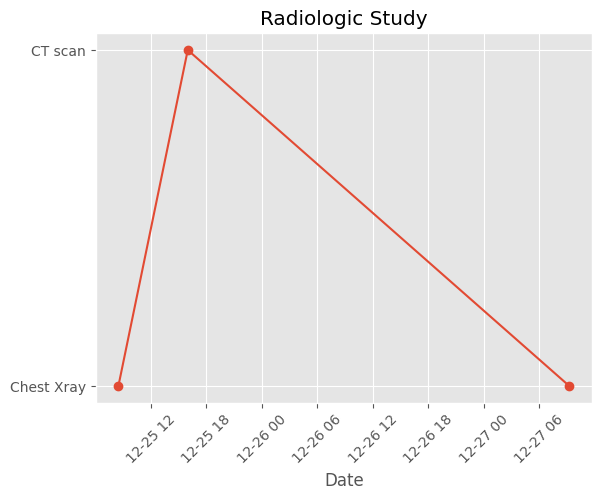

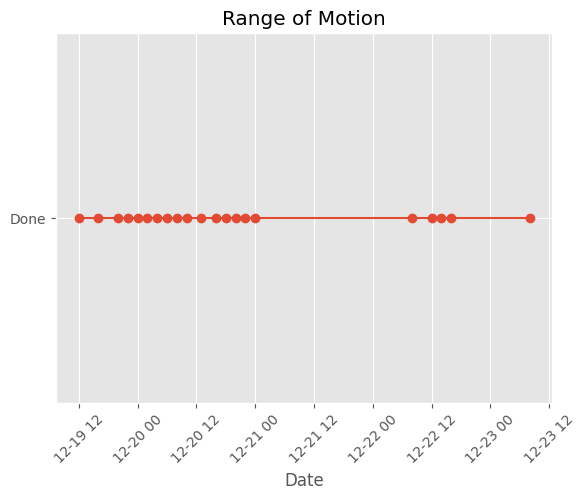

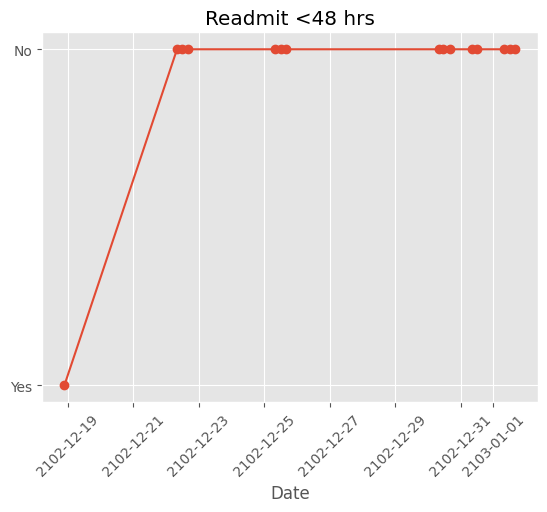

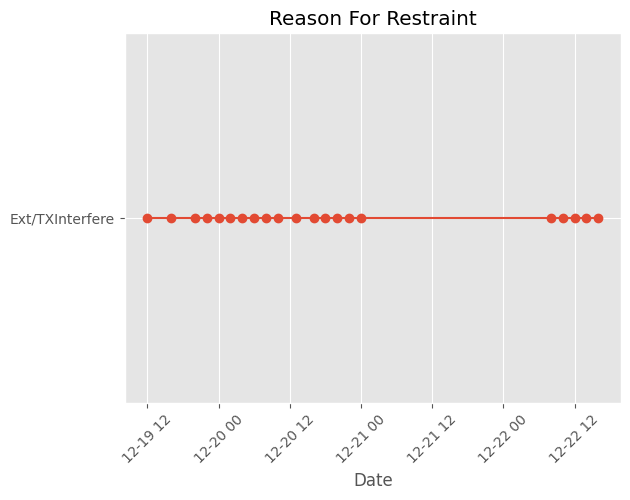

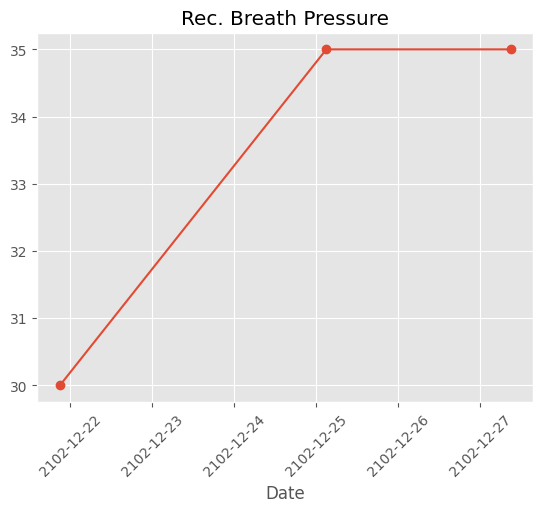

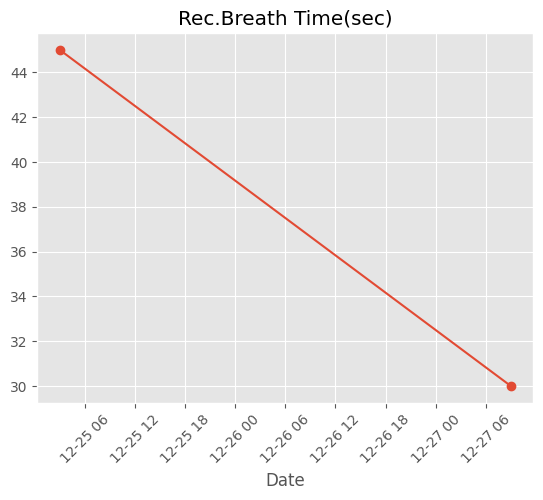

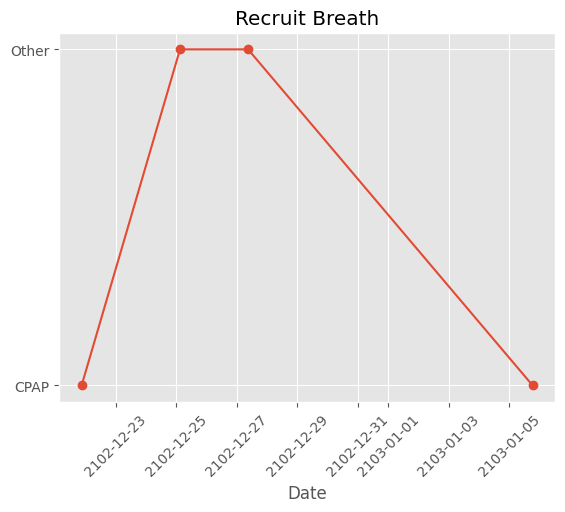

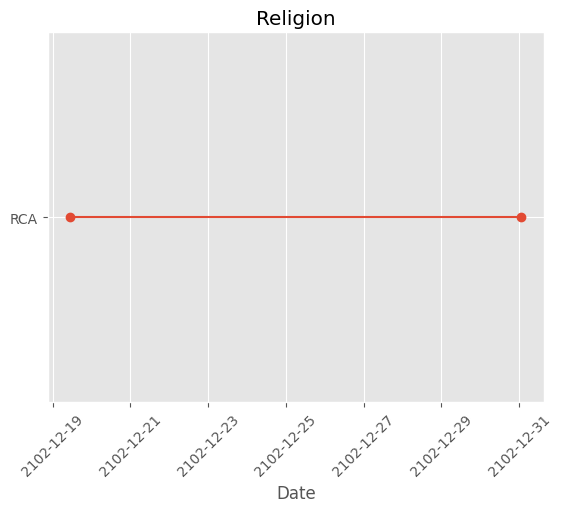

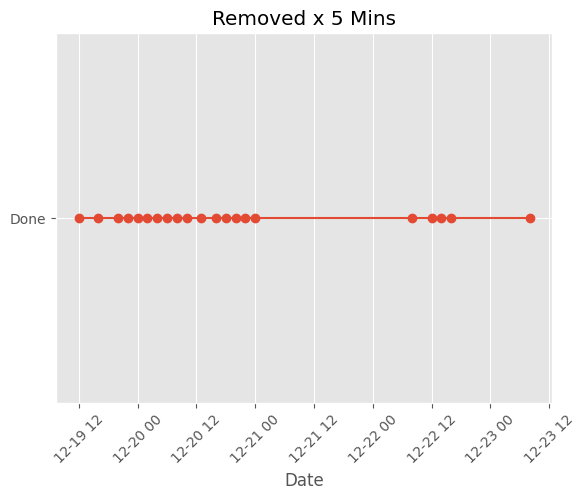

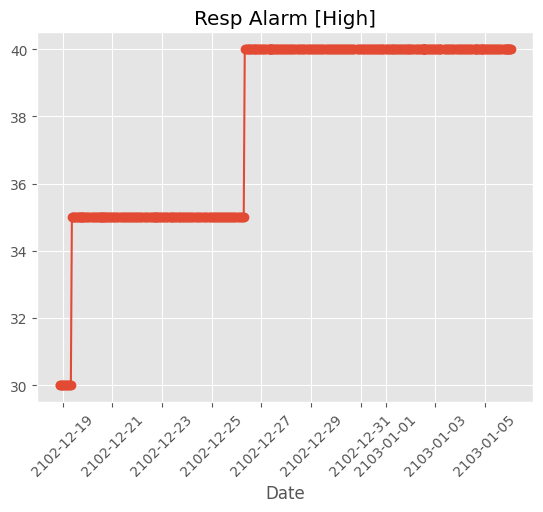

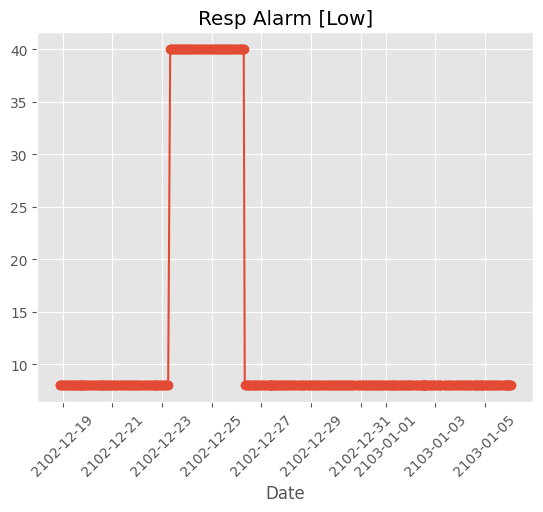

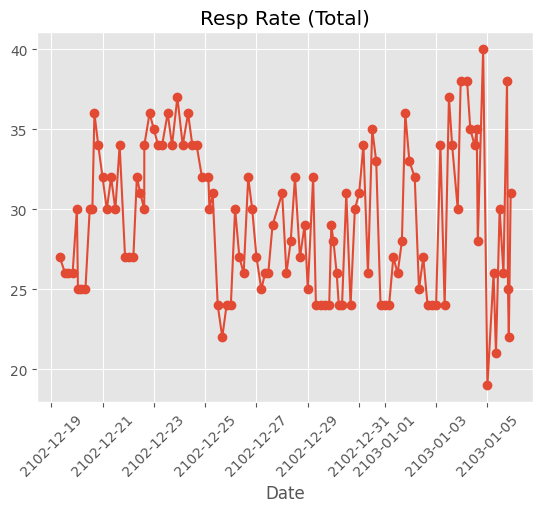

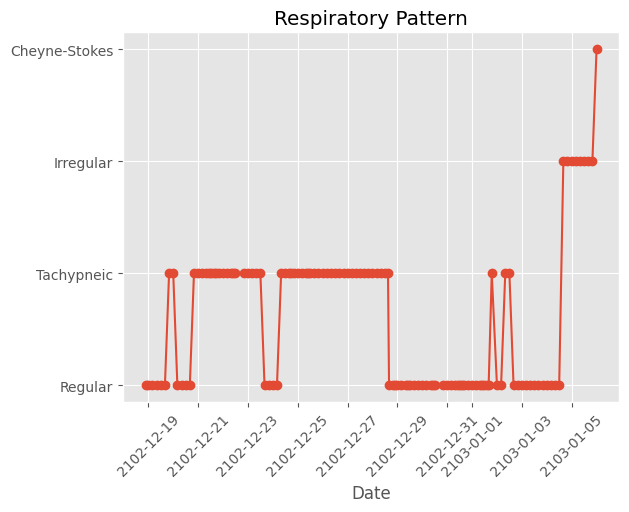

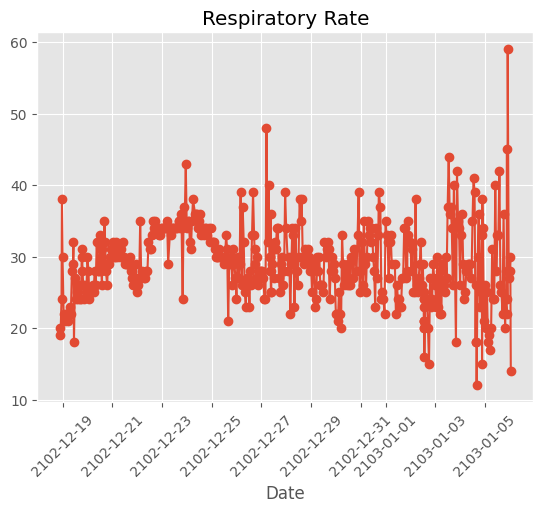

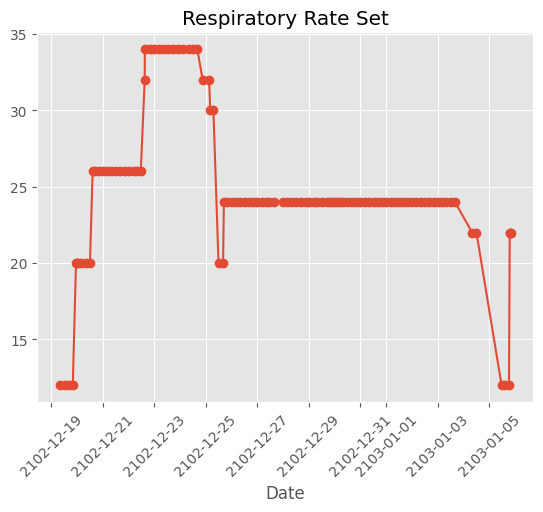

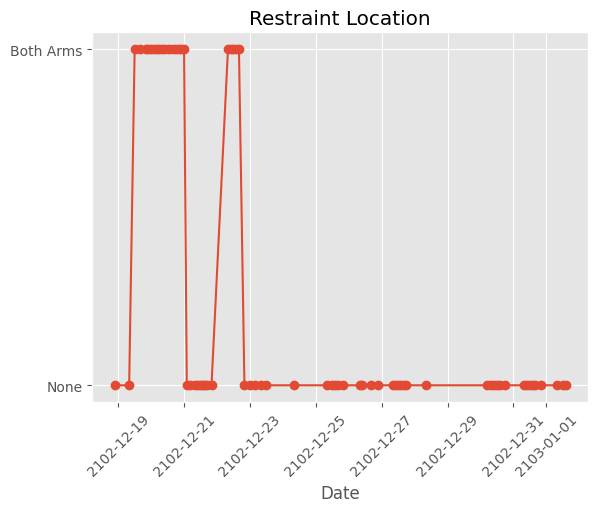

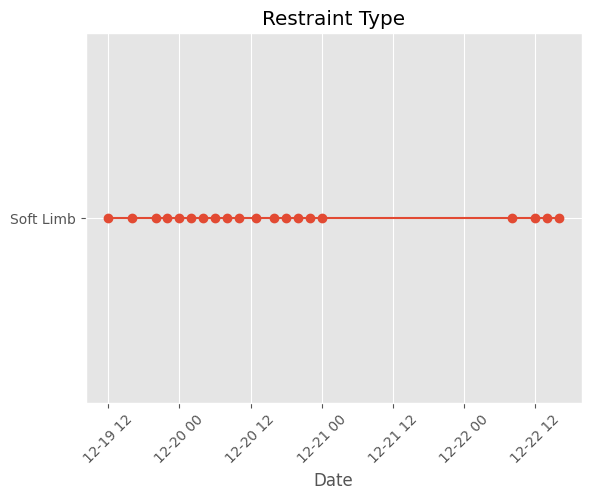

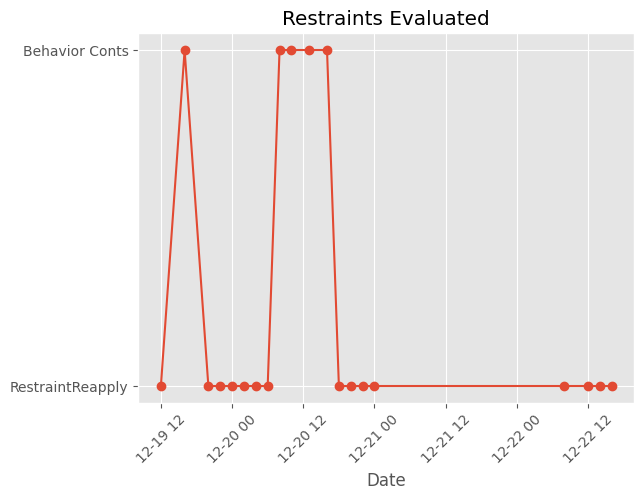

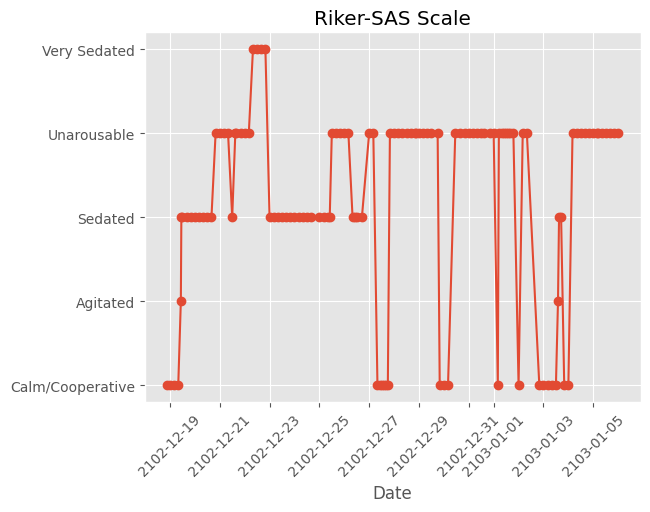

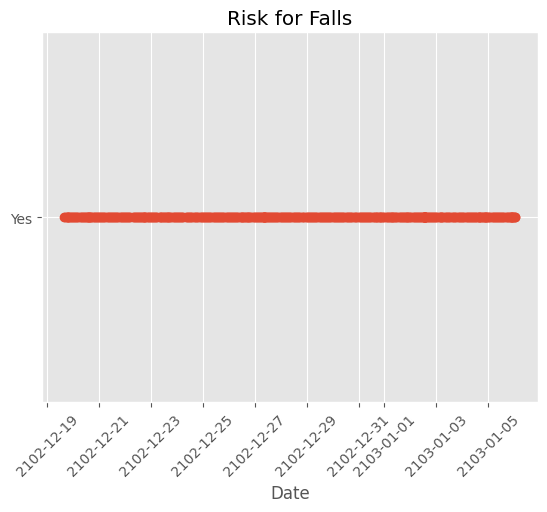

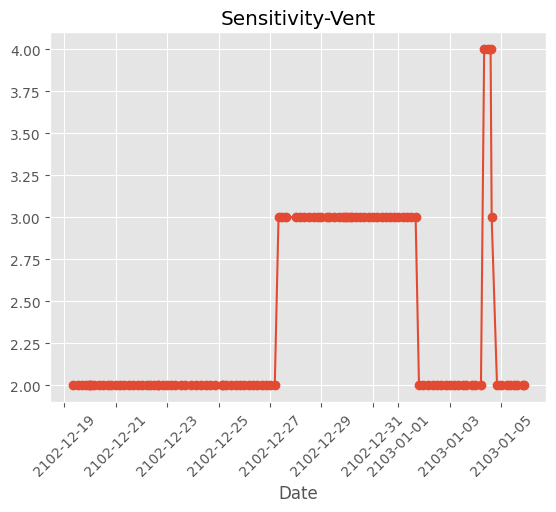

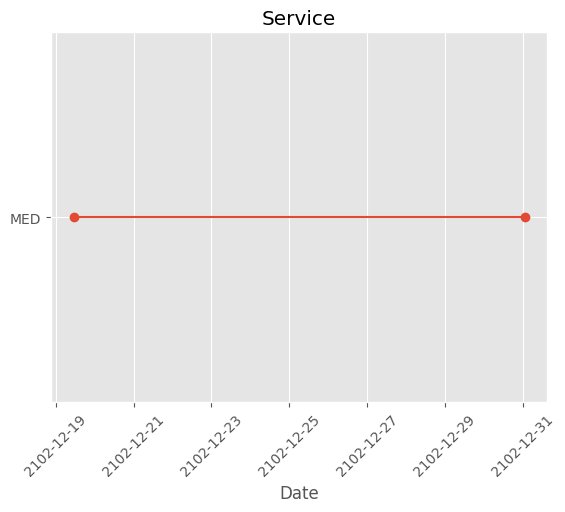

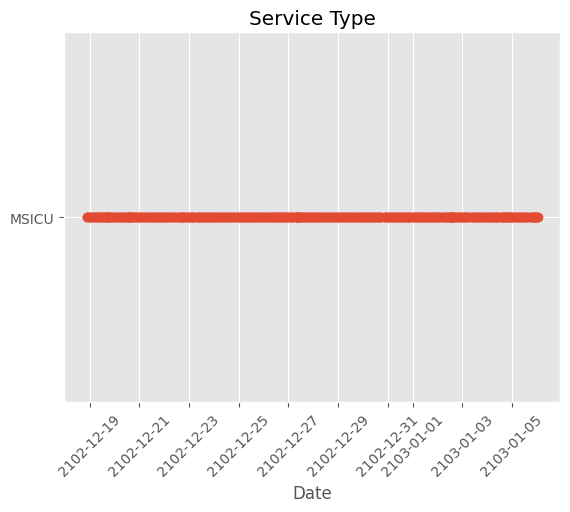

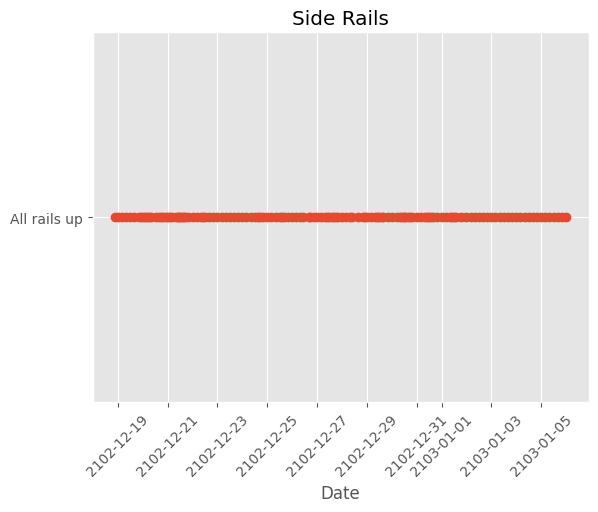

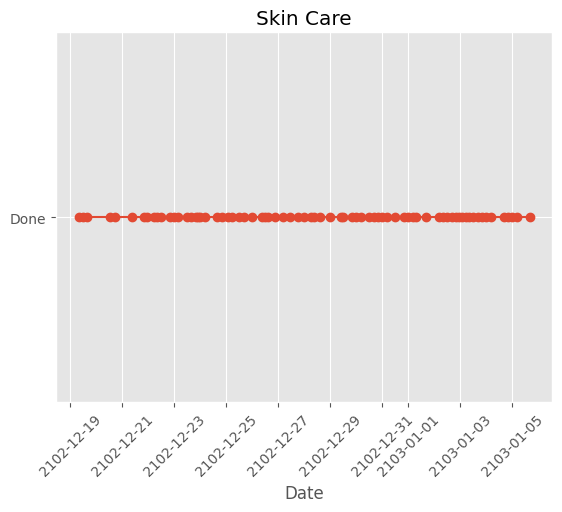

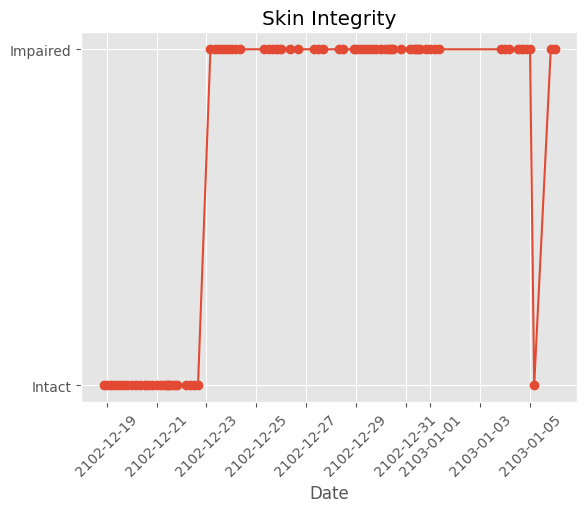

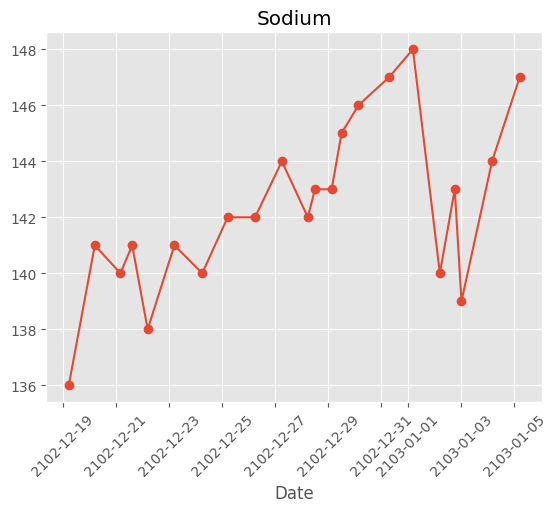

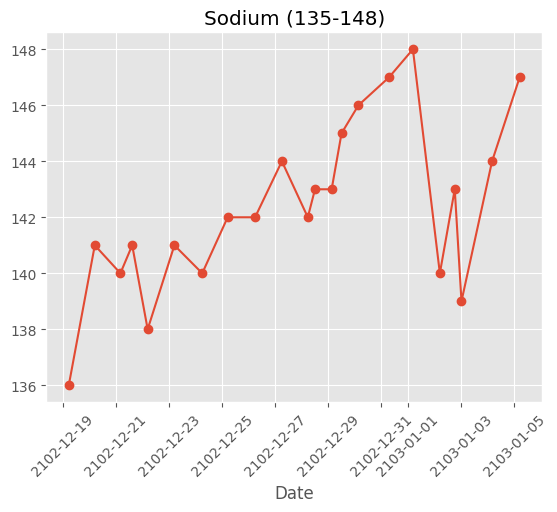

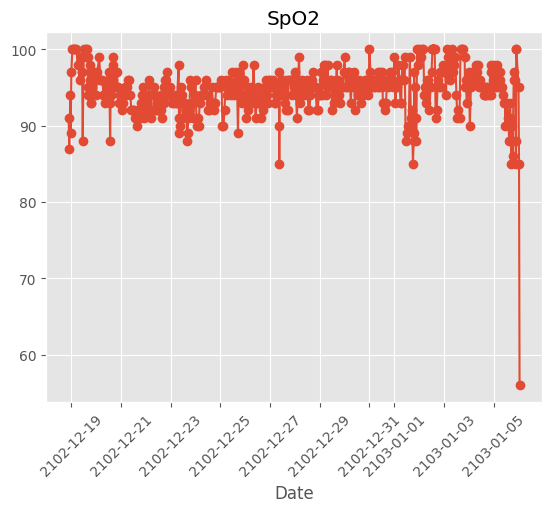

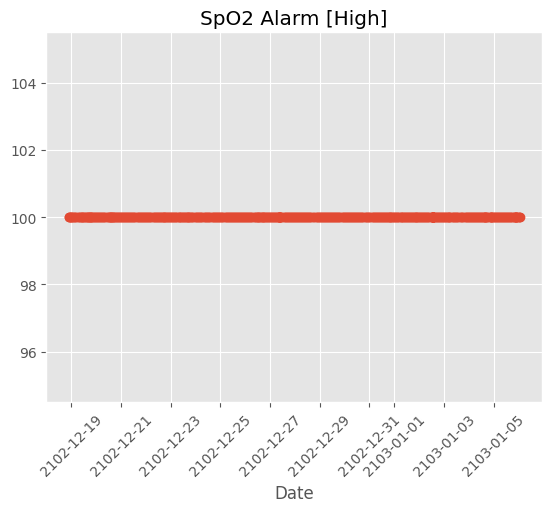

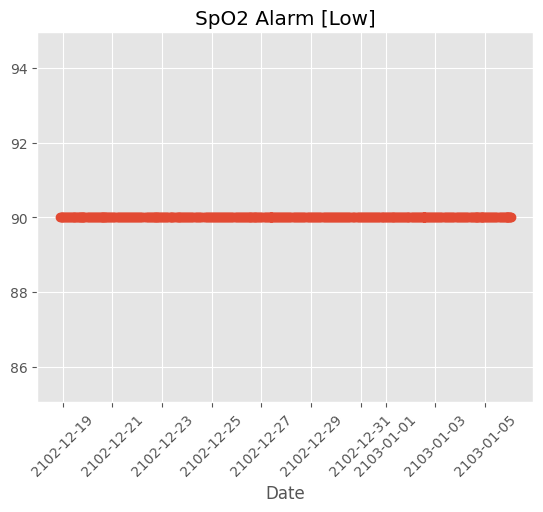

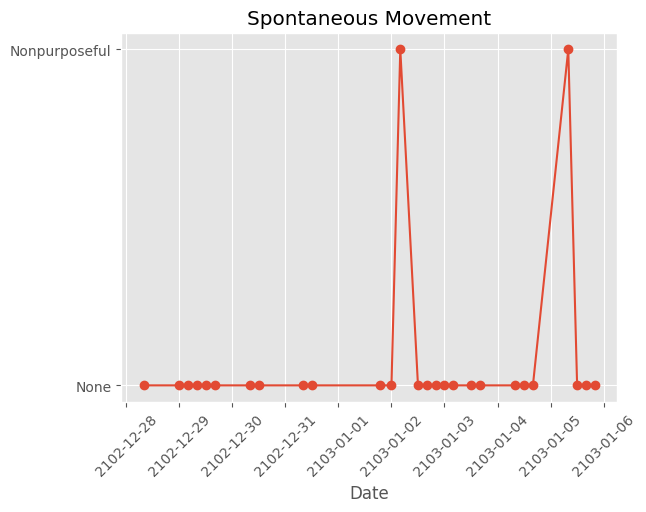

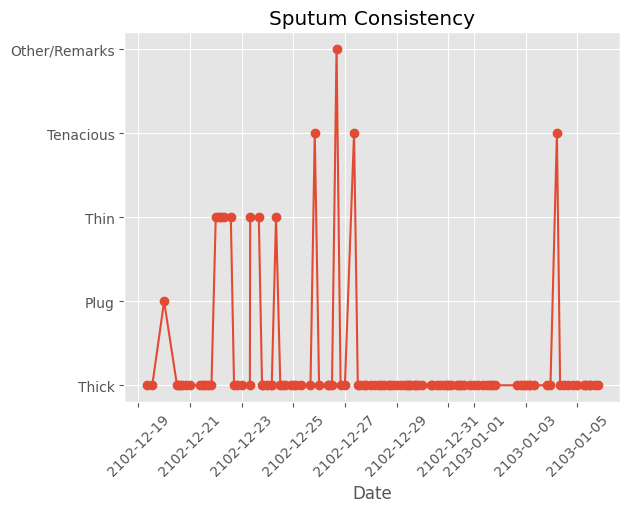

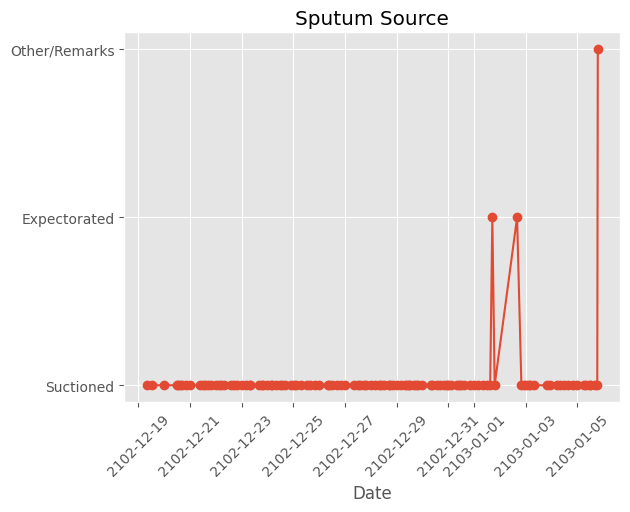

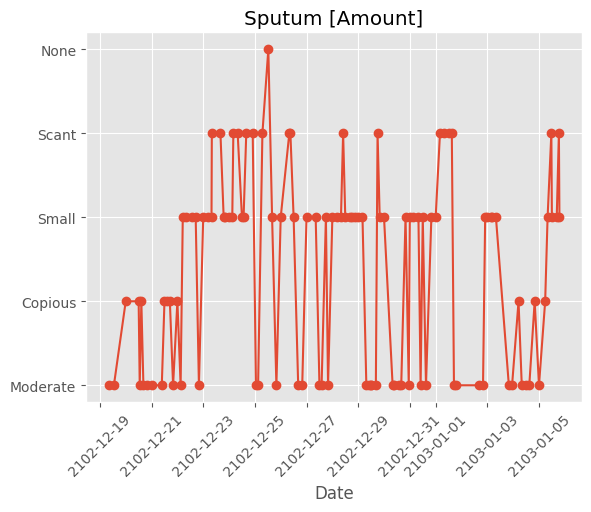

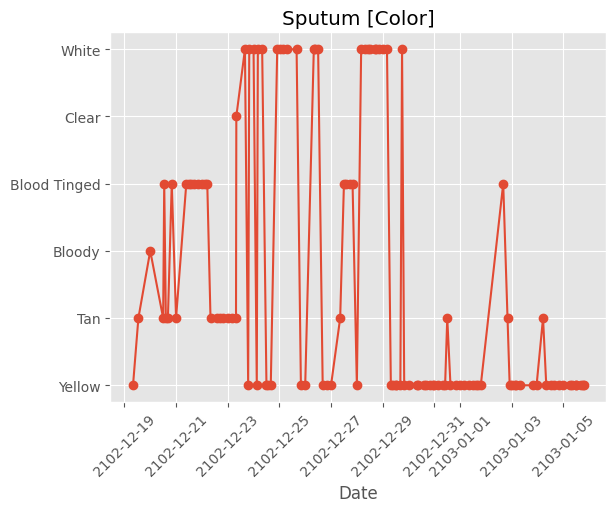

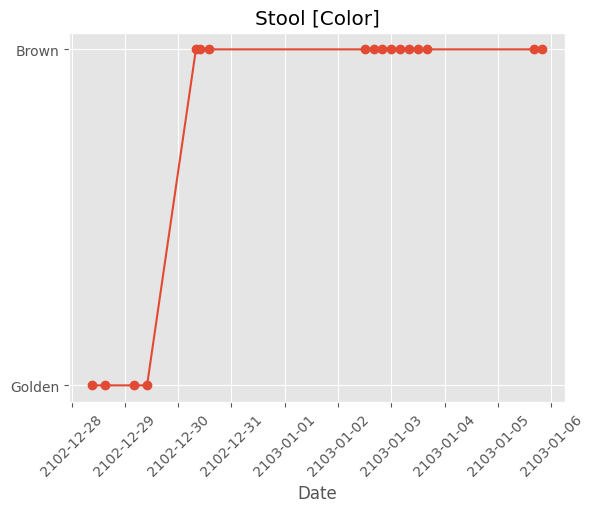

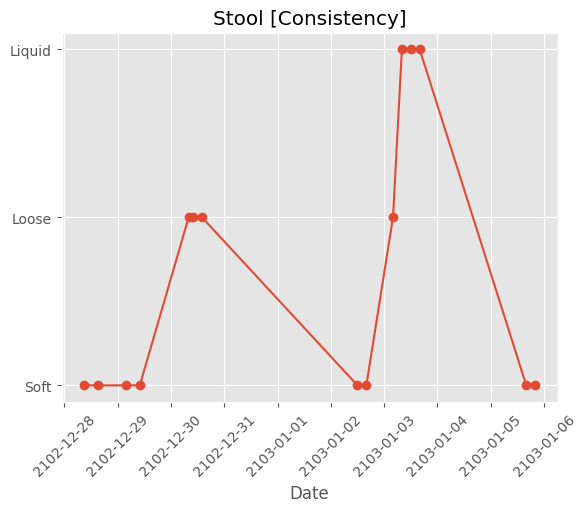

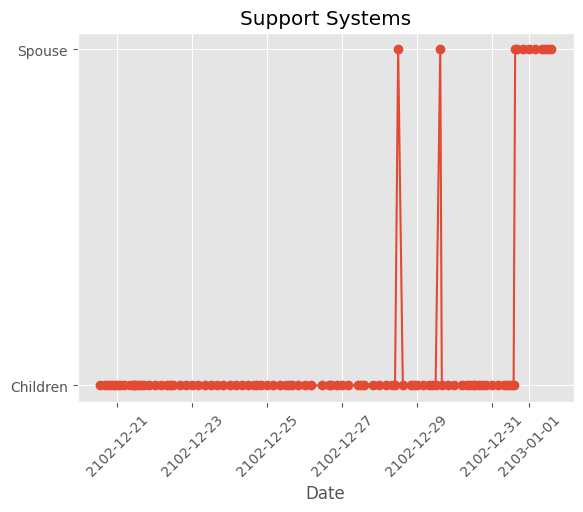

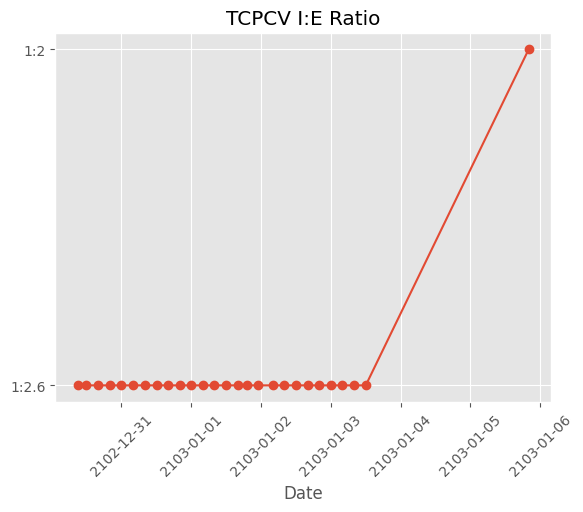

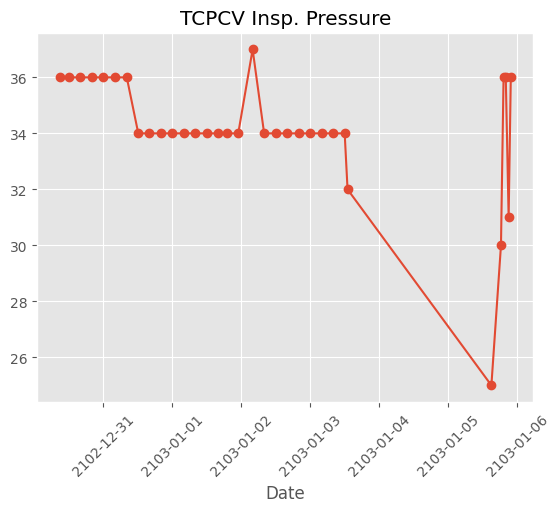

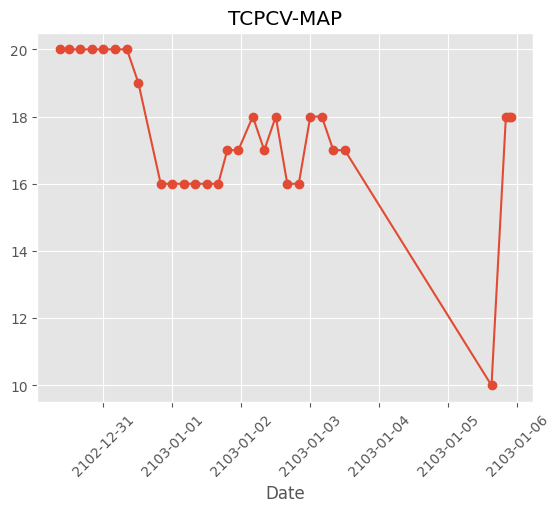

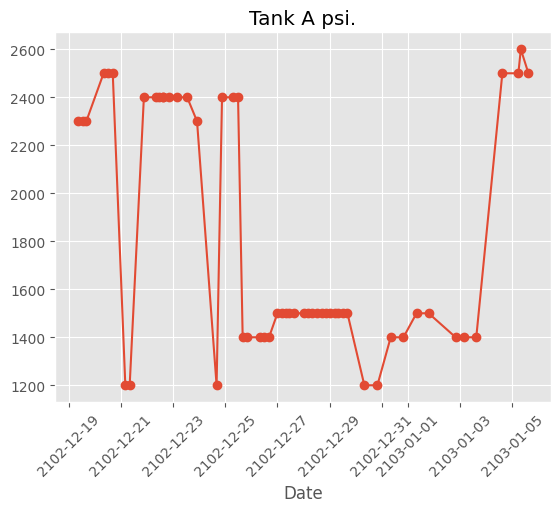

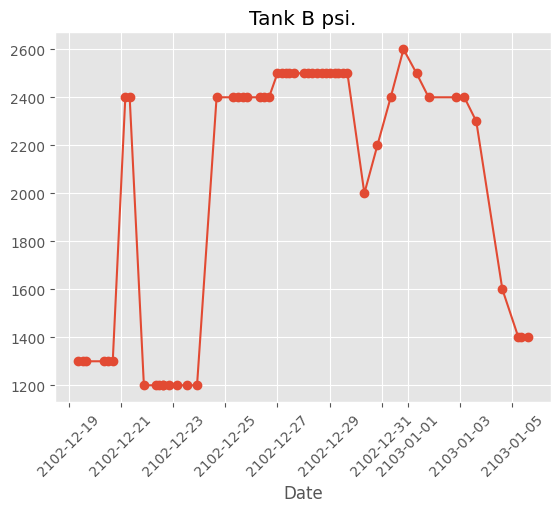

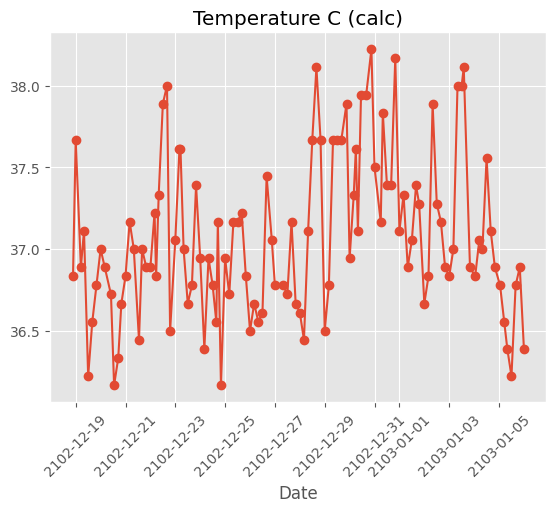

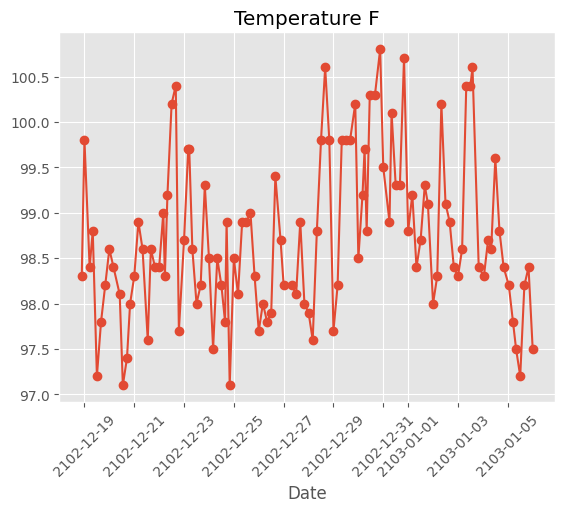

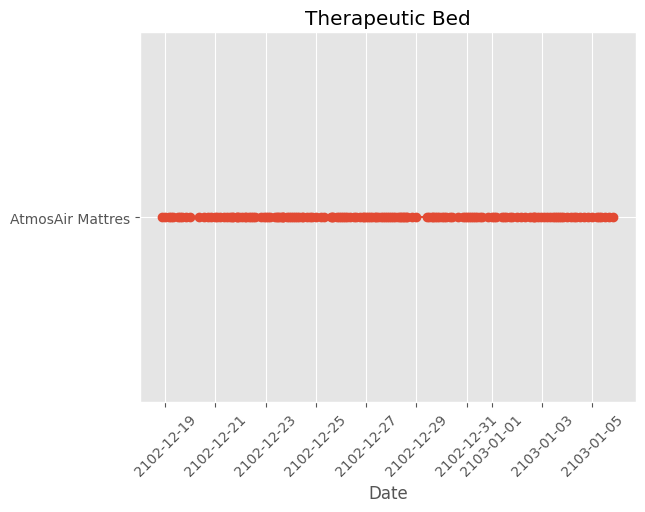

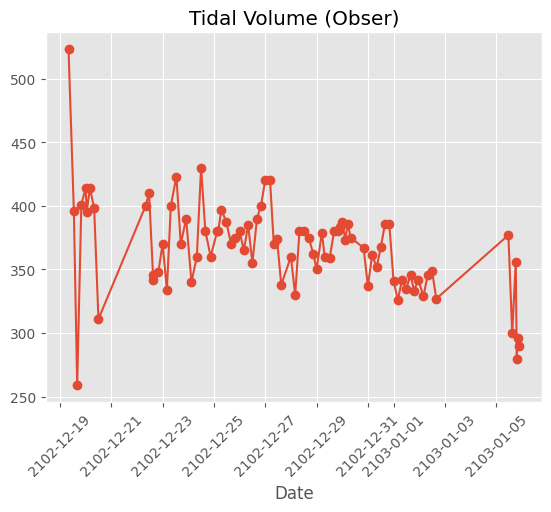

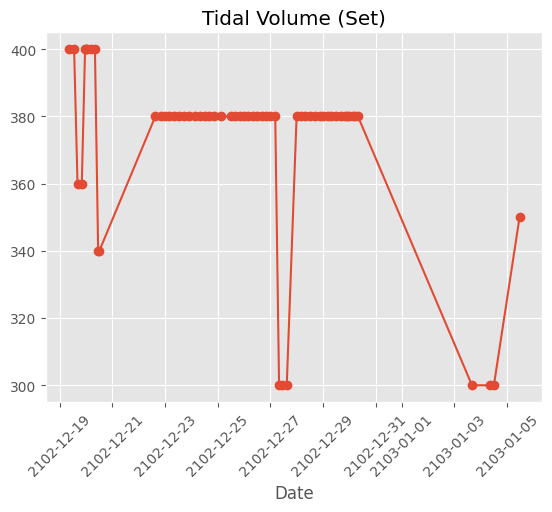

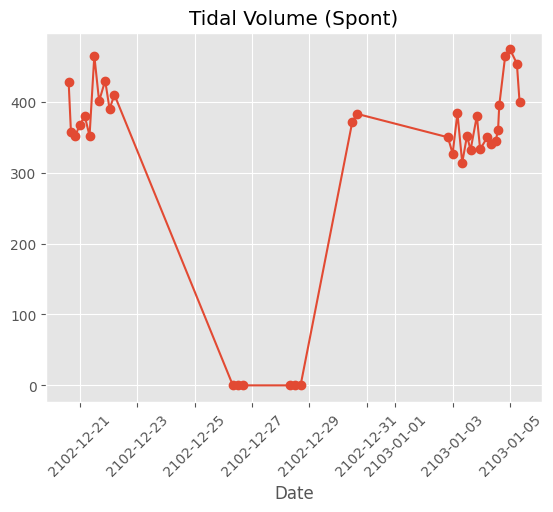

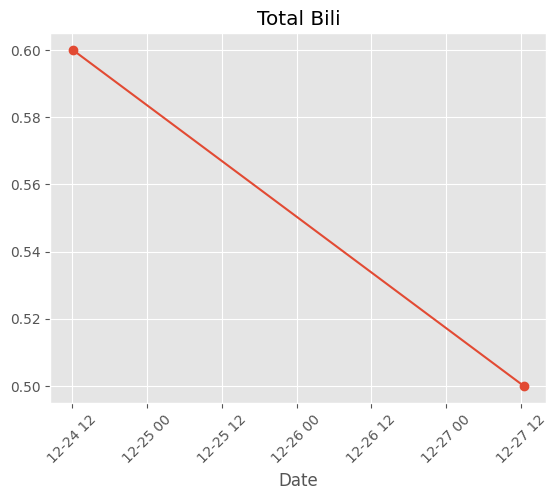

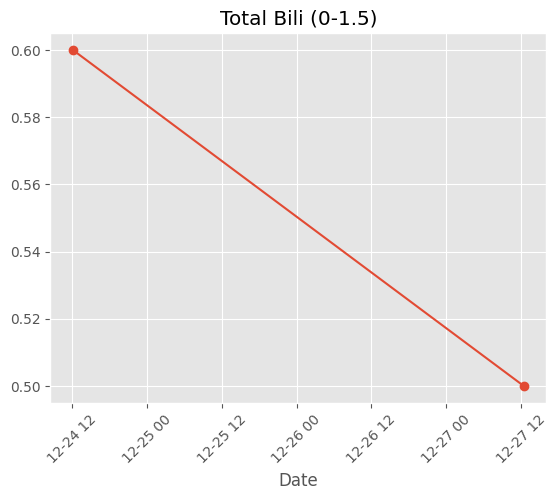

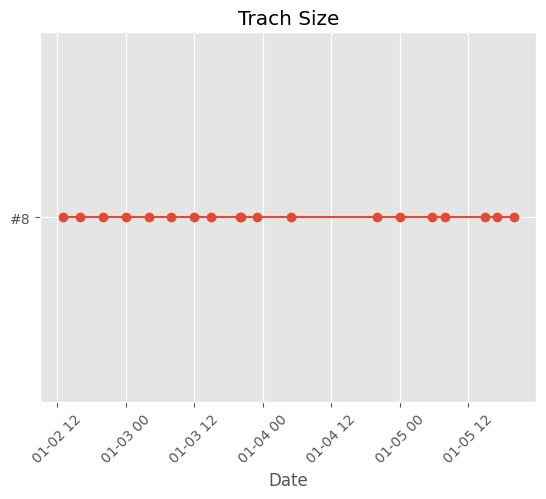

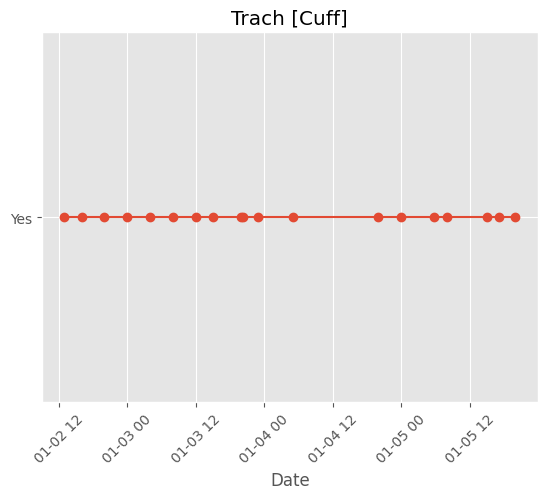

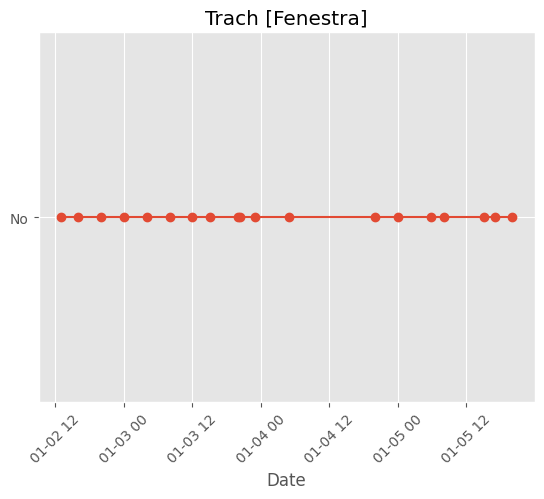

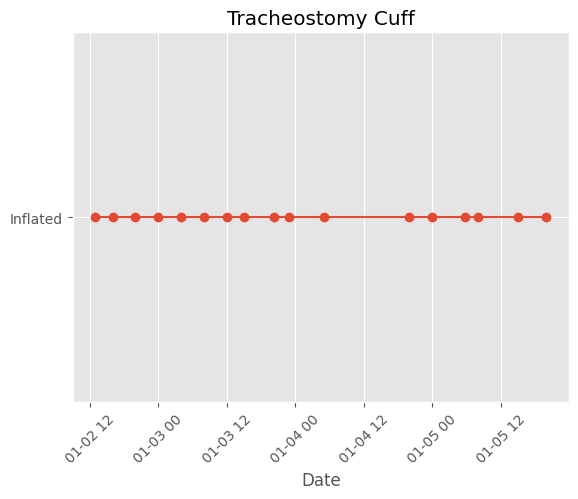

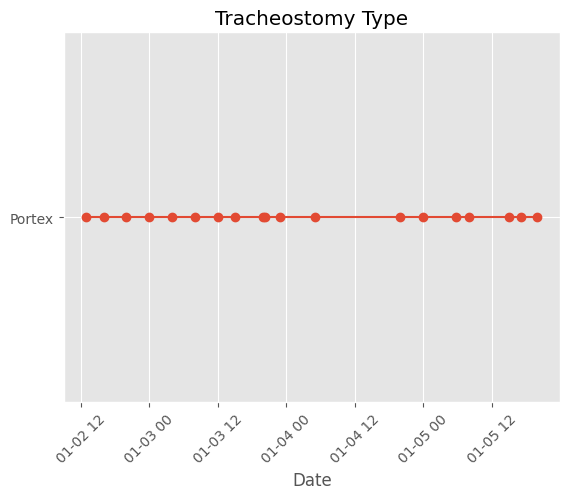

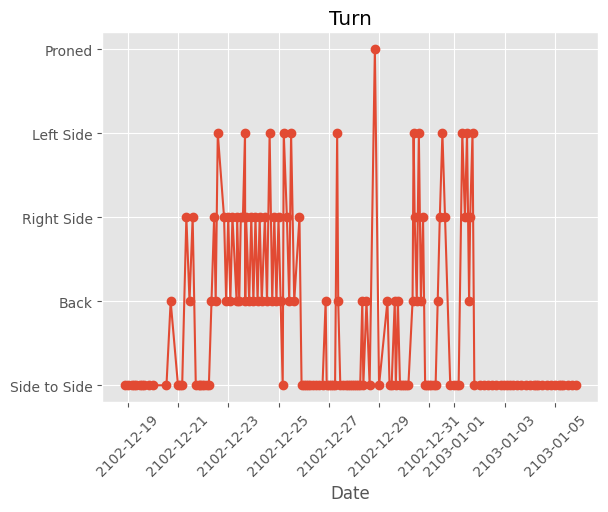

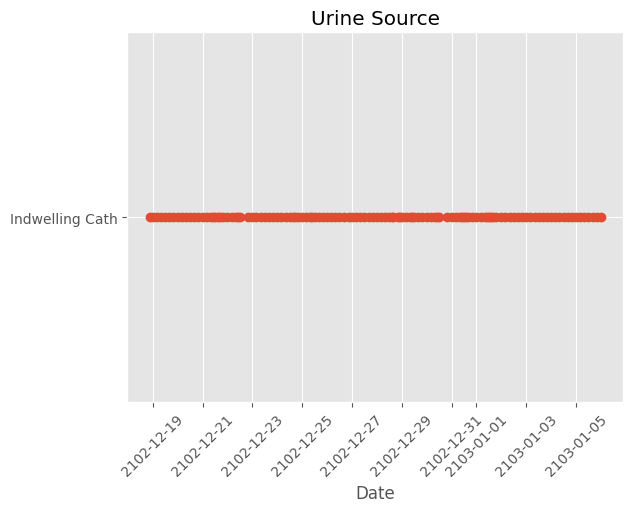

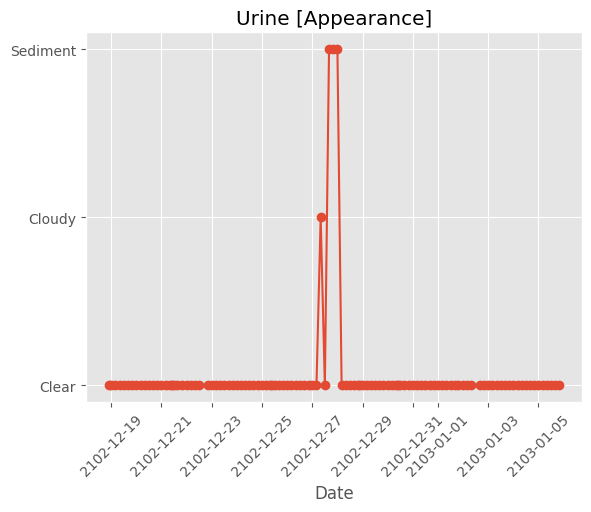

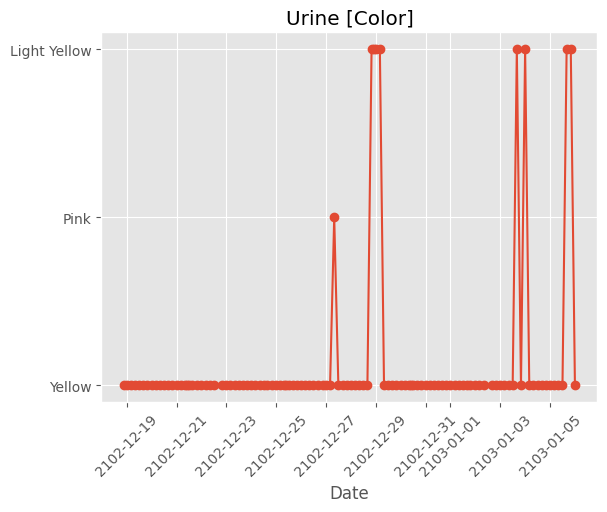

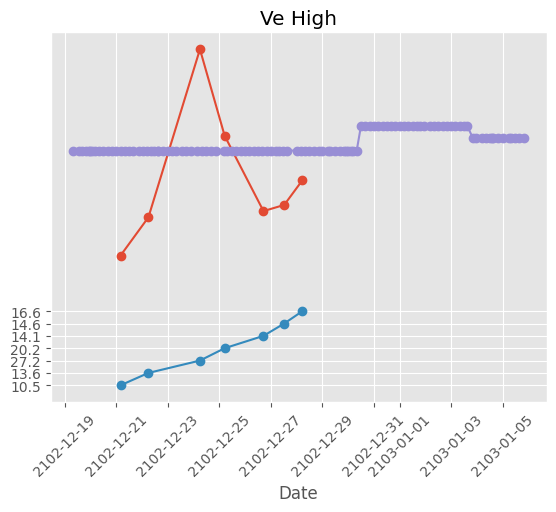

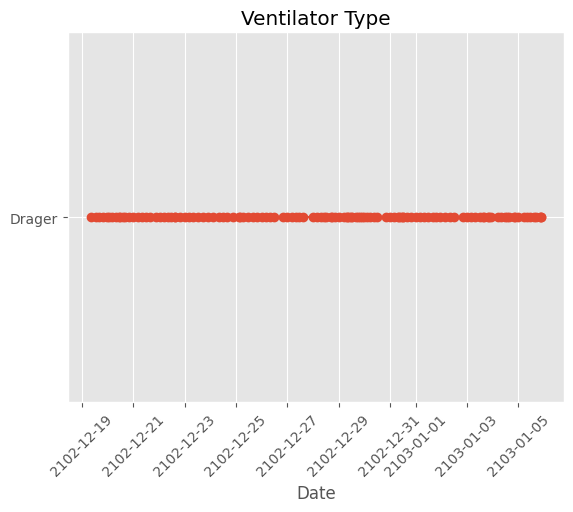

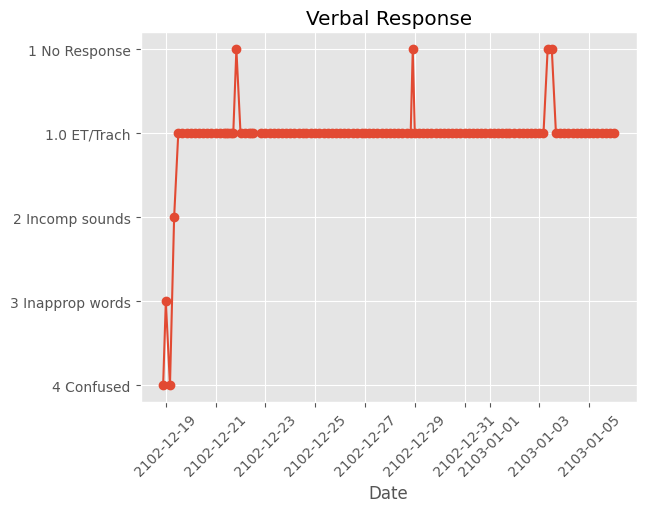

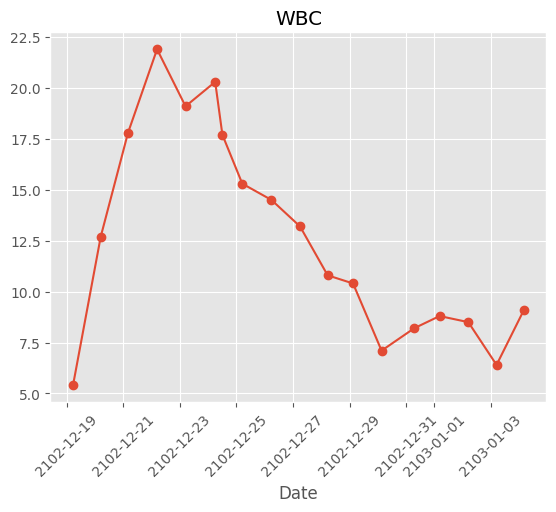

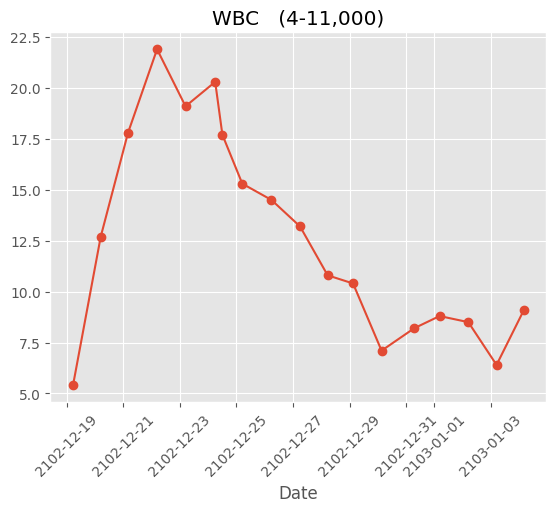

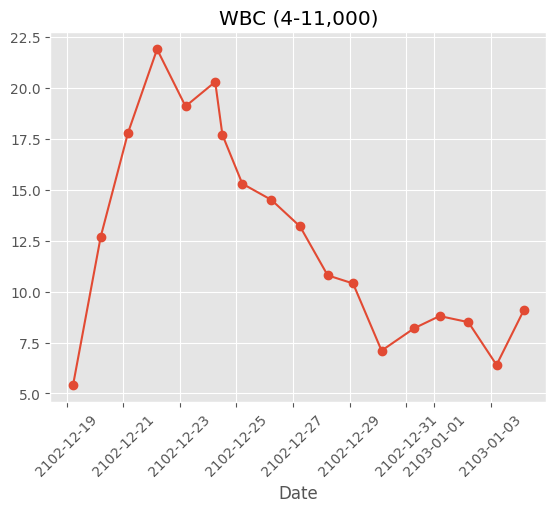

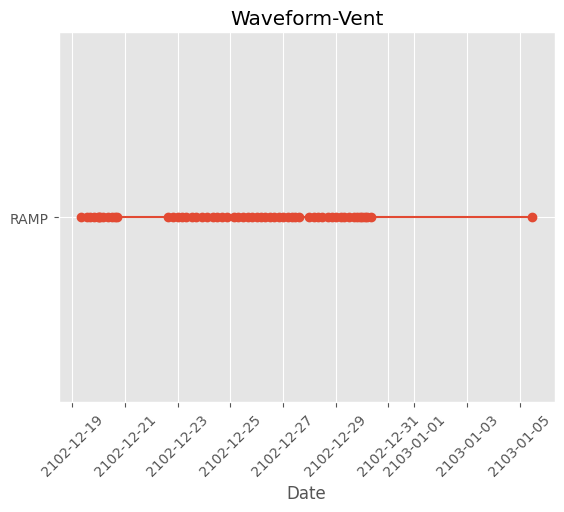

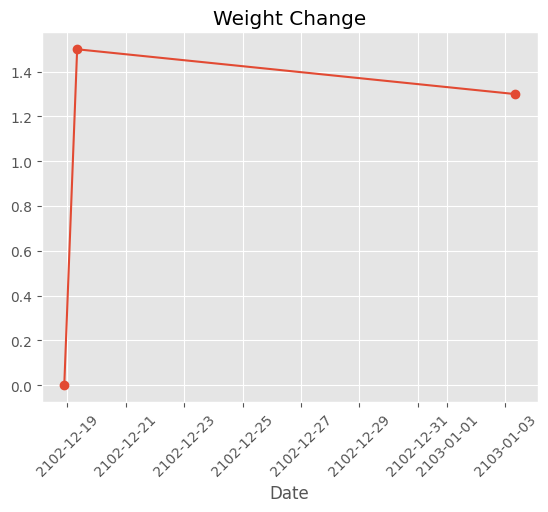

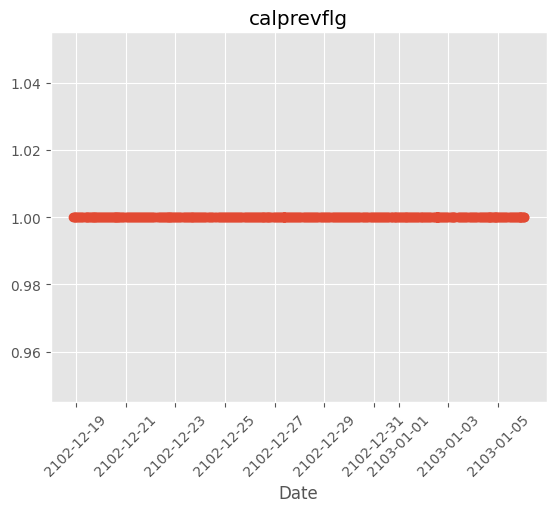

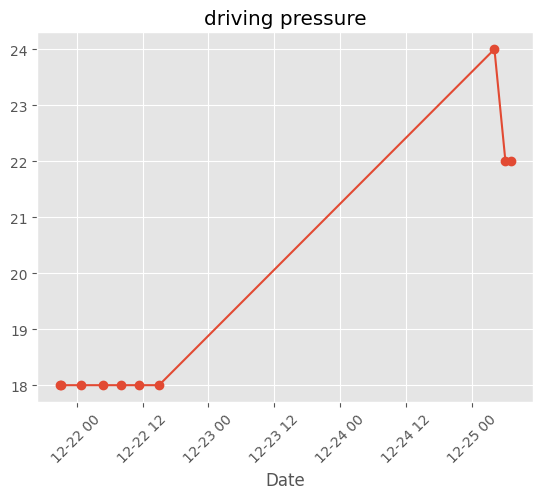

In [37]:
# plot_path = "plots/" + str(subject_id) + "/"
# if not os.path.exists(plot_path):
#     os.mkdir(plot_path)
# else:
#     for file in os.listdir(plot_path):
#         os.remove(os.path.join(plot_path, file))
        
for label in np.unique(df_CHARTEVENTS["label"]):
    try:
        df_work_of_breathing = df_CHARTEVENTS[df_CHARTEVENTS["label"]==label]

        if None not in list(df_work_of_breathing["value"]) and len(list(df_work_of_breathing["value"]))>1:
            try:
                list_plot = list(map(float, list(df_work_of_breathing["value"])))
                plt.plot(df_work_of_breathing["charttime"], list_plot, 'o-')
                plt.xlabel("Date")
                plt.xticks(rotation=45)
                plt.title(label)
                plt.savefig(plot_path+f'{label}.png')
                plt.show()
            except:
                list_plot = df_work_of_breathing["value"]
                plt.plot(df_work_of_breathing["charttime"], list_plot, 'o-')
                plt.xlabel("Date")
                plt.xticks(rotation=45)
                plt.title(label)
                plt.savefig(plot_path+f'{label}.png')
                plt.show()
            
    except:
        pass

In [38]:
query = query_schema + """
SELECT label, fluid, value, value, flag, charttime
FROM LABEVENTS
JOIN D_LABITEMS ON D_LABITEMS.itemid = LABEVENTS.itemid
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
save_info(df, "LAB_EVENTS")
df.head(195)

Number of rows : 863


label  fluid value value      flag  \
0                            Nitrite  Urine   NEG   NEG      None   
1     Alanine Aminotransferase (ALT)  Blood     6     6      None   
2               Alkaline Phosphatase  Blood    92    92      None   
3                          Anion Gap  Blood    19    19      None   
4    Asparate Aminotransferase (AST)  Blood    43    43  abnormal   
..                               ...    ...   ...   ...       ...   
190                      Bicarbonate  Blood    15    15  abnormal   
191                   Calcium, Total  Blood   7.3   7.3  abnormal   
192                         Chloride  Blood   114   114  abnormal   
193                       Creatinine  Blood   1.0   1.0      None   
194                          Glucose  Blood    71    71      None   

              charttime  
0   2103-01-01 17:30:00  
1   2102-12-18 14:40:00  
2   2102-12-18 14:40:00  
3   2102-12-18 14:40:00  
4   2102-12-18 14:40:00  
..                  ...  
190 2102-12-20 04:52:00  
191 2102-12-20 04:52:00  
192 2102-12-20 04:52:00  
193 2102-12-20 04:52:00  
194 2102-12-20 04:52:00  

[195 rows x 6 columns]

In [39]:
query = query_schema + """
SELECT *
FROM MICROBIOLOGYEVENTS
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
save_info(df, "MICROBIOLOGY_EVENTS")
df.head(10)

Number of rows : 29


row_id  subject_id  hadm_id  chartdate           charttime  spec_itemid  \
0  406963       30941   164022 2102-12-18 2102-12-18 14:40:00        70012   
1  406964       30941   164022 2102-12-18 2102-12-18 15:20:00        70079   
2  406965       30941   164022 2102-12-18 2102-12-18 20:50:00        70012   
3  406966       30941   164022 2102-12-19 2102-12-19 02:02:00        70079   
4  406967       30941   164022 2102-12-19 2102-12-19 11:25:00        70062   
5  406968       30941   164022 2102-12-19 2102-12-19 11:25:00        70062   
6  406969       30941   164022 2102-12-19 2102-12-19 11:25:00        70062   
7  406970       30941   164022 2102-12-19 2102-12-19 11:25:00        70062   
8  406971       30941   164022 2102-12-19 2102-12-19 11:25:00        70062   
9  406972       30941   164022 2102-12-19 2102-12-19 11:25:00        70062   

  spec_type_desc  org_itemid             org_name  isolate_num  ab_itemid  \
0  BLOOD CULTURE         NaN                 None          NaN        NaN   
1          URINE         NaN                 None          NaN        NaN   
2  BLOOD CULTURE         NaN                 None          NaN        NaN   
3          URINE         NaN                 None          NaN        NaN   
4         SPUTUM     80023.0  STAPH AUREUS COAG +          1.0    90012.0   
5         SPUTUM     80023.0  STAPH AUREUS COAG +          1.0    90025.0   
6         SPUTUM     80023.0  STAPH AUREUS COAG +          1.0    90008.0   
7         SPUTUM     80023.0  STAPH AUREUS COAG +          1.0    90016.0   
8         SPUTUM     80023.0  STAPH AUREUS COAG +          1.0    90002.0   
9         SPUTUM     80023.0  STAPH AUREUS COAG +          1.0    90006.0   

              ab_name dilution_text dilution_comparison  dilution_value  \
0                None          None                None             NaN   
1                None          None                None             NaN   
2                None          None                None             NaN   
3                None          None                None             NaN   
4          GENTAMICIN         <=0.5                  <=             1.0   
5        LEVOFLOXACIN          0.25                   =             0.0   
6  TRIMETHOPRIM/SULFA         <=0.5                  <=             1.0   
7           OXACILLIN           0.5                   =             1.0   
8          PENICILLIN         =>0.5                  =>             1.0   
9        ERYTHROMYCIN        <=0.25                  <=             0.0   

  interpretation  
0           None  
1           None  
2           None  
3           None  
4              S  
5              S  
6              S  
7              S  
8              R  
9              S

In [18]:
query = query_schema + """
SELECT *
FROM PRESCRIPTIONS
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
save_info(df, "PRESCRIPTIONS")
df.head(100)

Number of rows : 149


row_id  subject_id  hadm_id  icustay_id  startdate    enddate drug_type  \
0   2932854       30941   164022    276555.0 2102-12-19 2103-01-06      MAIN   
1   2932855       30941   164022    276555.0 2102-12-19 2103-01-05      MAIN   
2   2932856       30941   164022    276555.0 2102-12-19 2102-12-19      MAIN   
3   2932857       30941   164022    276555.0 2102-12-19 2102-12-21      MAIN   
4   2932858       30941   164022    276555.0 2102-12-19 2102-12-28      MAIN   
..      ...         ...      ...         ...        ...        ...       ...   
95  2934363       30941   164022    276555.0 2102-12-25 2102-12-25      BASE   
96  2934364       30941   164022    276555.0 2102-12-25 2102-12-29      BASE   
97  2934365       30941   164022    276555.0 2102-12-25 2102-12-26      BASE   
98  2934366       30941   164022    276555.0 2103-01-01 2103-01-02      BASE   
99  2934367       30941   164022    276555.0 2103-01-02 2103-01-02      BASE   

                              drug                   drug_name_poe  \
0          Influenza Virus Vaccine         Influenza Virus Vaccine   
1                          Heparin                         Heparin   
2   Carbidopa-Levodopa CR (50-200)  Carbidopa-Levodopa CR (50-200)   
3             Dipyridamole-Aspirin            Dipyridamole-Aspirin   
4                      Mirtazapine                     Mirtazapine   
..                             ...                             ...   
95                              NS                            None   
96                             D5W                            None   
97                              NS                            None   
98                             D5W                            None   
99                             D5W                            None   

                 drug_name_generic formulary_drug_cd     gsn          ndc  \
0          Influenza Virus Vaccine              INFV  061242  58160087346   
1                   Heparin Sodium            HEPA5I  006549  00641040025   
2   Carbidopa-Levodopa CR (50-200)         SINC50200  016043  00056052168   
3             Dipyridamole-Aspirin           AGGRCAP  040303  00597000160   
4                      Mirtazapine            MIRT15  046450  51079008620   
..                             ...               ...     ...          ...   
95                            None            NS1000  001210  00338004904   
96                            None            D5W250  001972  00338001702   
97                            None            NS1000  001210  00338004904   
98                            None           D5W1000  001972  00338001704   
99                            None            D5W250  001972  00338001702   

                prod_strength dose_val_rx dose_unit_rx form_val_disp  \
0               0.5mL Syringe         0.5           ml             1   
1   5000 Units / mL- 1mL Vial        5000         UNIT             1   
2               50-200 mg Tab           1          TAB             1   
3            25-200mg Capsule           1          CAP             1   
4                    15mg Tab          15           mg             1   
..                        ...         ...          ...           ...   
95                 1000mL Bag        1000           ml             1   
96                  250mL Bag         250           ml           250   
97                 1000mL Bag        1000           ml             1   
98                 1000mL Bag        1000           ml          1000   
99                  250mL Bag         250           ml           250   

   form_unit_disp    route  
0             SYR       IM  
1              ml       SC  
2             TAB       PO  
3             CAP       PO  
4             TAB       PO  
..            ...      ...  
95            BAG       IV  
96             ml       IV  
97            BAG       IV  
98             ml       IV  
99             ml  IV DRIP  

[100 rows x 19 columns]

In [19]:
query = query_schema + """
SELECT *
FROM INPUTEVENTS_MV
WHERE subject_id = {subject_id}
"""

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
if len(df) == 0:
    query = query_schema + """
    SELECT *
    FROM INPUTEVENTS_CV
    WHERE subject_id = {subject_id}
    """

df = pd.read_sql_query(query.format(subject_id=subject_id), con)
print("Number of rows :", len(df))
df.head()

Number of rows : 1856


row_id  subject_id  hadm_id  icustay_id           charttime  itemid  \
0  554676       30941   164022      276555 2102-12-18 23:00:00   30013   
1  554677       30941   164022      276555 2102-12-19 02:00:00   30013   
2  554678       30941   164022      276555 2102-12-19 10:00:00   30013   
3  554679       30941   164022      276555 2102-12-19 11:00:00   30013   
4  554680       30941   164022      276555 2102-12-19 16:00:00   30013   

   amount amountuom  rate rateuom  ...  orderid  linkorderid  stopped  \
0   500.0        ml   NaN    None  ...   718899       718899     None   
1   250.0        ml   NaN    None  ...  1590472       718899     None   
2    50.0        ml   NaN    None  ...   321390       718899     None   
3  1000.0        ml   NaN    None  ...  9896164       718899     None   
4   250.0        ml   NaN    None  ...  7727835       718899     None   

   newbottle originalamount  originalamountuom     originalroute originalrate  \
0        NaN          100.0                 ml  Intravenous Push          NaN   
1        NaN          100.0                 ml  Intravenous Push          NaN   
2        NaN          100.0                 ml  Intravenous Push          NaN   
3        NaN          100.0                 ml  Intravenous Push          NaN   
4        NaN          100.0                 ml  Intravenous Push          NaN   

  originalrateuom  originalsite  
0            None          None  
1            None          None  
2            None          None  
3            None          None  
4            None          None  

[5 rows x 22 columns]